In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, PrecisionRecallDisplay
)
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             PrecisionRecallDisplay)
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
import warnings
import xgboost as xgb
from sklearn.tree import export_text
import scorecardpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [9]:
dataset = pd.read_csv('Customer_Churn.csv')

In [10]:
# Select the relevant columns based on the initial code
column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 5]
column_12 = dataset.iloc[:, 12]
column_13 = dataset.iloc[:, 13]

# Filter records based on specified conditions and get the indices
filtered_rows = dataset[(column_4 == 0) & (column_13 == 1) & (column_0 == 0)]

# Calculate global statistics for each of the specified columns
stats = {
    'mean': dataset.mean(),
    'median': dataset.median(),
    'std': dataset.std(),
    'min': dataset.min(),
    'max': dataset.max()
}

# Display statistics for reference
print("Global Dataset Statistics:")
print(pd.DataFrame(stats))

# Function to identify how far each value in the filtered rows is from the dataset’s overall stats
def compare_to_global_stats(row, global_stats):
    deviations = {}
    for column in row.index:
        deviations[column] = {
            'value': row[column],
            'deviation_from_mean': row[column] - global_stats['mean'][column],
            'deviation_from_median': row[column] - global_stats['median'][column],
            'std_dev_from_mean': (row[column] - global_stats['mean'][column]) / global_stats['std'][column] if global_stats['std'][column] != 0 else 0
        }
    return deviations

# Compare each row in the filtered dataset to the global statistics and display the results
outlier_analysis = []
for idx, row in filtered_rows.iterrows():
    print(f"\nAnalysis for Row Index {idx}:")
    deviations = compare_to_global_stats(row, stats)
    outlier_analysis.append(deviations)
    print(pd.DataFrame(deviations).transpose())



Global Dataset Statistics:
                                mean   median          std   min       max
Call  Failure               7.627937     6.00     7.263886   0.0     36.00
Complains                   0.076508     0.00     0.265851   0.0      1.00
Subscription  Length       32.541905    35.00     8.573482   3.0     47.00
Charge  Amount              0.942857     0.00     1.521072   0.0     10.00
Seconds of Use           4472.459683  2990.00  4197.908687   0.0  17090.00
Frequency of use           69.460635    54.00    57.413308   0.0    255.00
Frequency of SMS           73.174921    21.00   112.237560   0.0    522.00
Distinct Called Numbers    23.509841    21.00    17.217337   0.0     97.00
Age Group                   2.826032     3.00     0.892555   1.0      5.00
Tariff Plan                 1.077778     1.00     0.267864   1.0      2.00
Status                      1.248254     1.00     0.432069   1.0      2.00
Age                        30.998413    30.00     8.831095  15.0     55.0

In [3]:
# Access relevant columns
column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]  
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13]

# Filter records with Churn value 0
outliers_ch0 = dataset[(column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 0)]

# Filter records with Churn value 1
outliers_ch1 = dataset[(column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1)]

# Combine both into one dataset
outlier = pd.concat([outliers_ch0, outliers_ch1])




In [4]:
# Print total number of columns and their names
print(f"\nTotal number of columns: {len(outlier.columns)}")
print("\nColumn names:")
for idx, col in enumerate(outlier.columns, 1):
    print(f"{idx}. {col}")

# Perform analysis
analysis_results = {}
for column in outlier.columns:
    column_data = {
        'dtype': str(outlier[column].dtype),
        'null_count': outlier[column].isnull().sum(),
        'null_percentage': (outlier[column].isnull().sum() / len(outlier)) * 100,
        'unique_values': outlier[column].nunique(),
    }
    
    if pd.api.types.is_numeric_dtype(outlier[column]):
        column_data.update({
            'min': outlier[column].min(),
            'max': outlier[column].max(),
            'mean': outlier[column].mean(),
            'median': outlier[column].median(),
            'skew': outlier[column].skew(),
        })
    else:
        column_data.update({
            'min': None,
            'max': None,
            'mean': None,
            'median': None,
            'skew': None,
        })
    
    analysis_results[column] = column_data

# Convert analysis_results to a DataFrame
results_df = pd.DataFrame.from_dict(analysis_results, orient='index')

# Print outlier shape
print(f"\nDataset Shape: {outlier.shape[0]} rows × {outlier.shape[1]} columns")

# Print detailed column analysis as a table
print("\nDetailed Column Analysis:")
print(tabulate(results_df, headers='keys', tablefmt='grid'))



Total number of columns: 14

Column names:
1. Call  Failure
2. Complains
3. Subscription  Length
4. Charge  Amount
5. Seconds of Use
6. Frequency of use
7. Frequency of SMS
8. Distinct Called Numbers
9. Age Group
10. Tariff Plan
11. Status
12. Age
13. Customer Value
14. Churn

Dataset Shape: 154 rows × 14 columns

Detailed Column Analysis:
+-------------------------+---------+--------------+-------------------+-----------------+-------+-------+------------+----------+-----------+
|                         | dtype   |   null_count |   null_percentage |   unique_values |   min |   max |       mean |   median |      skew |
+=========================+=========+==============+===================+=================+=======+=======+============+==========+===========+
| Call  Failure           | int64   |            0 |                 0 |               1 |     0 |   0   |  0         |        0 |  0        |
+-------------------------+---------+--------------+-------------------+-------------

In [82]:
dataset = pd.read_csv('Customer_Churn.csv')
# Access relevant columns
column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]  
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13]

# Calculate zero counts and indices for Churn value 0
zero_count_ch0 = ((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 0)).sum()
print(f"Number of records with Churn value 0 in specified columns: {zero_count_ch0}")

zero_indices_ch0 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 0))].index.tolist()
print(f"Index of records with Churn value 0 in specified columns: {zero_indices_ch0}")

# Calculate zero counts and indices for Churn value 1
zero_count_ch1 = ((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1)).sum()


zero_indices_ch1 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1))].index.tolist()

Number of records with Churn value 0 in specified columns: 73
Index of records with Churn value 0 in specified columns: [132, 201, 232, 241, 301, 329, 341, 401, 432, 441, 501, 532, 541, 601, 632, 732, 901, 917, 932, 940, 941, 1051, 1082, 1151, 1182, 1191, 1232, 1251, 1282, 1291, 1351, 1366, 1367, 1379, 1390, 1391, 1451, 1466, 1467, 1479, 1482, 1491, 1551, 1566, 1567, 1579, 1582, 1590, 1591, 1592, 1594, 1651, 1682, 1691, 1701, 1732, 1751, 1782, 1791, 1801, 1832, 1951, 1966, 1967, 1982, 1990, 1991, 2001, 2032, 2051, 2082, 3001, 3032]


In [58]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (84.3%)
Class 1: 396 (15.7%)

Test set proportions:
Class 0: 531 (84.3%)
Class 1: 99 (15.7%)


Results for CART Classifier (Gini):
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       531
           1       0.77      0.76      0.77        99

    accuracy                           0.93       630
   macro avg       0.86      0.86      0.86       630
weighted avg       0.93      0.93      0.93       630



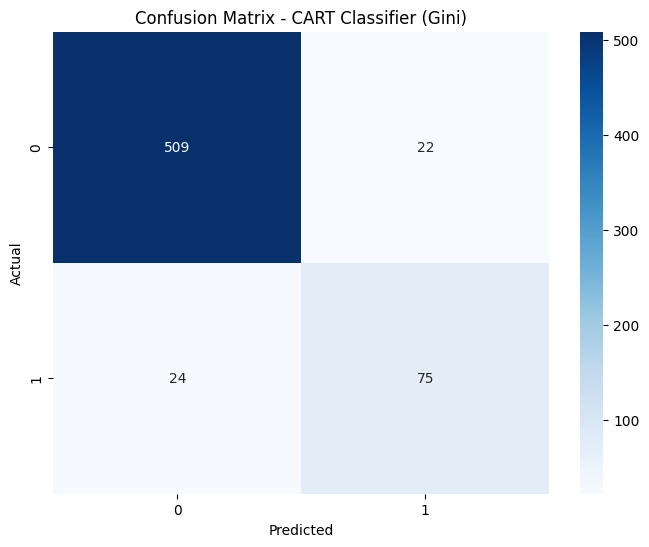

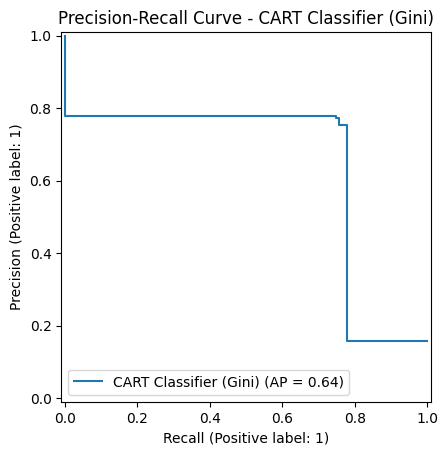

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       531
           1       0.84      0.83      0.83        99

    accuracy                           0.95       630
   macro avg       0.90      0.90      0.90       630
weighted avg       0.95      0.95      0.95       630



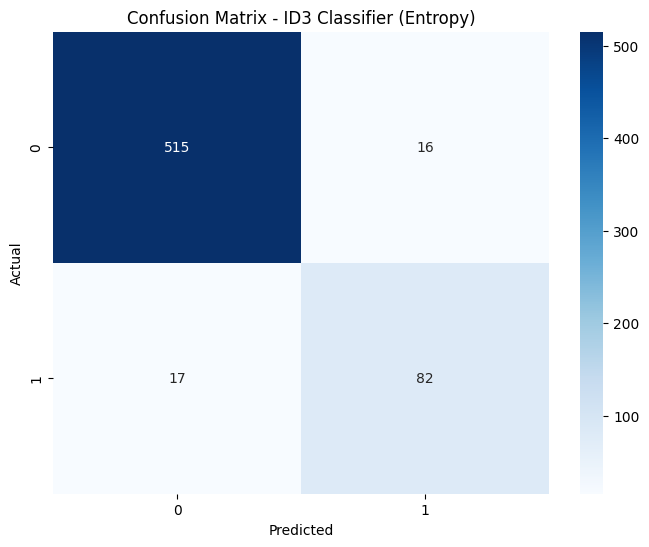

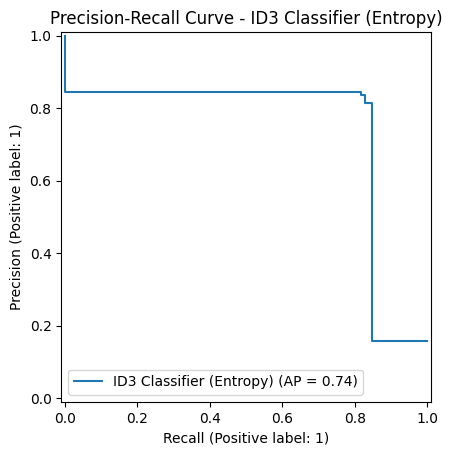

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       531
           1       0.84      0.83      0.83        99

    accuracy                           0.95       630
   macro avg       0.90      0.90      0.90       630
weighted avg       0.95      0.95      0.95       630



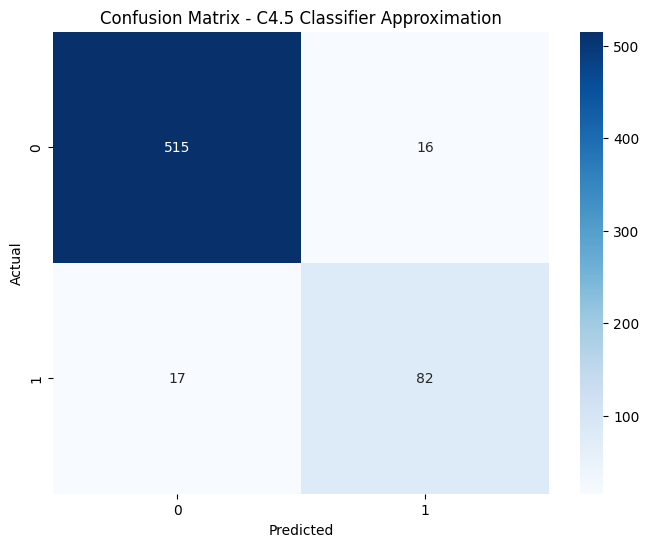

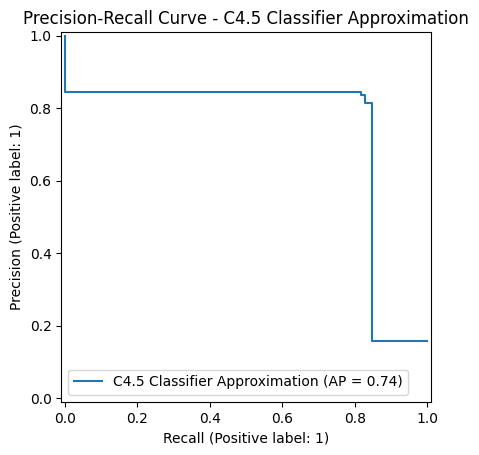

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       531
           1       0.79      0.77      0.78        99

    accuracy                           0.93       630
   macro avg       0.87      0.87      0.87       630
weighted avg       0.93      0.93      0.93       630



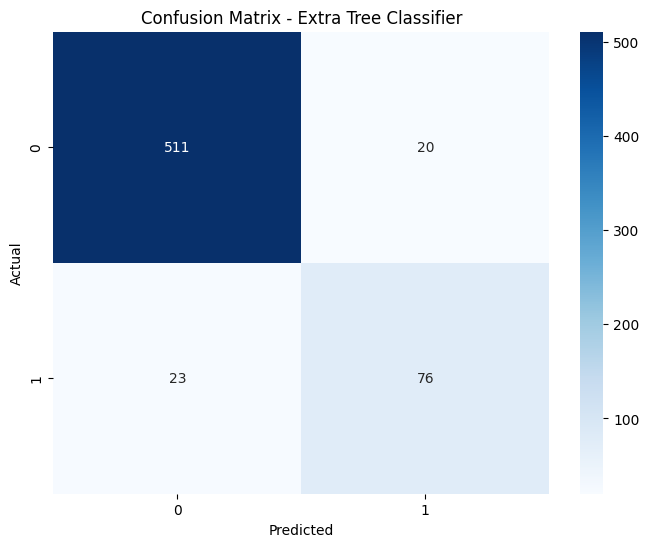

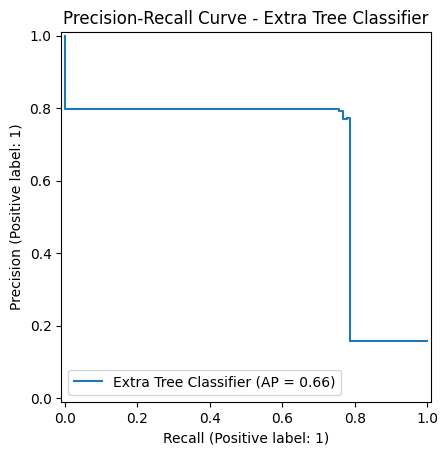

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       531
           1       0.89      0.86      0.88        99

    accuracy                           0.96       630
   macro avg       0.93      0.92      0.93       630
weighted avg       0.96      0.96      0.96       630



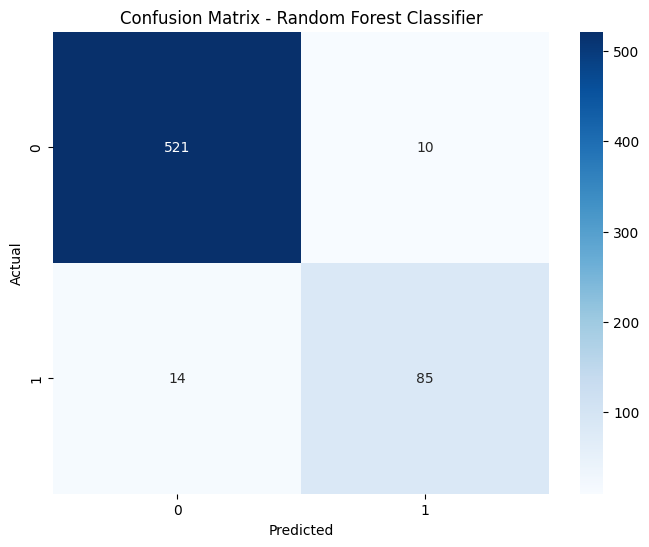

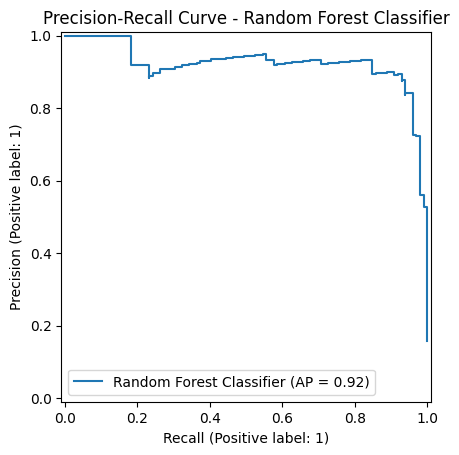

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       531
           1       0.88      0.78      0.82        99

    accuracy                           0.95       630
   macro avg       0.92      0.88      0.90       630
weighted avg       0.95      0.95      0.95       630



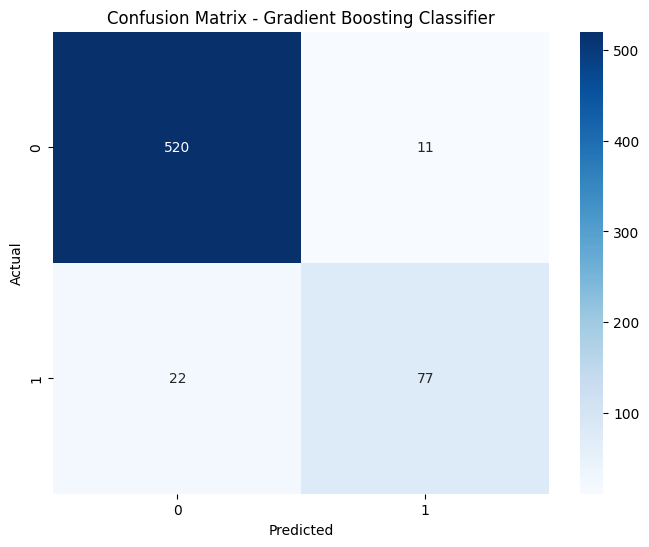

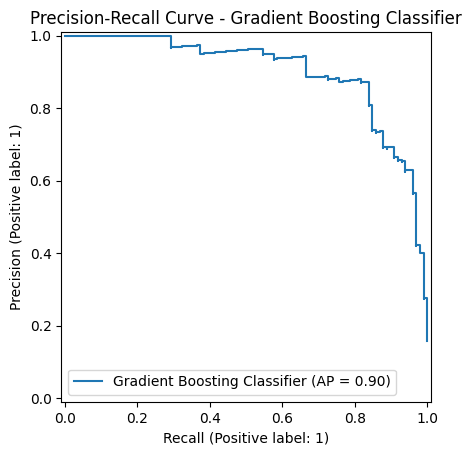

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       531
           1       0.80      0.82      0.81        99

    accuracy                           0.94       630
   macro avg       0.88      0.89      0.89       630
weighted avg       0.94      0.94      0.94       630



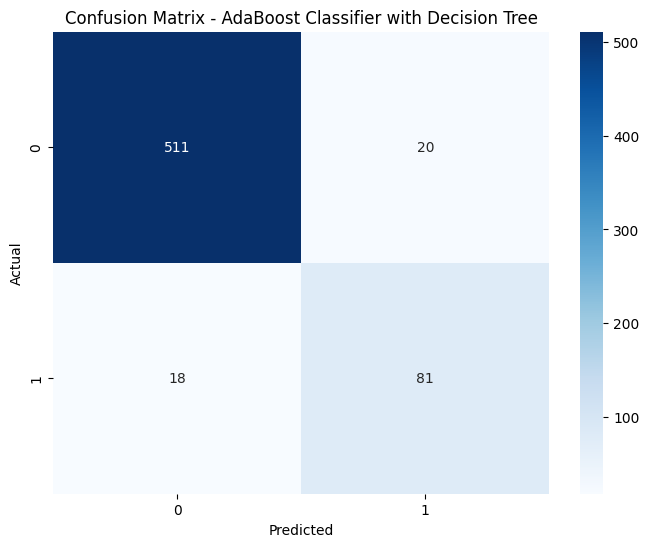

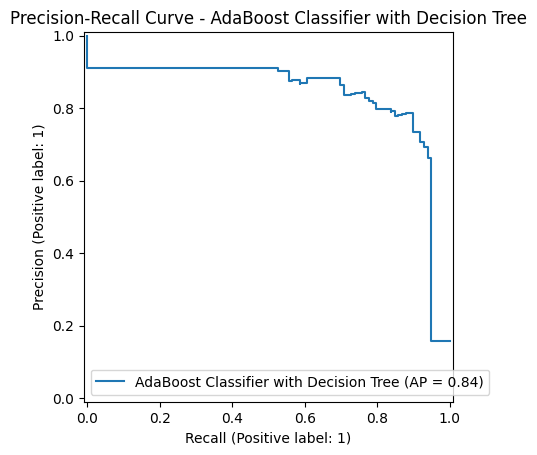

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.88      0.89      0.88        99

    accuracy                           0.96       630
   macro avg       0.93      0.93      0.93       630
weighted avg       0.96      0.96      0.96       630



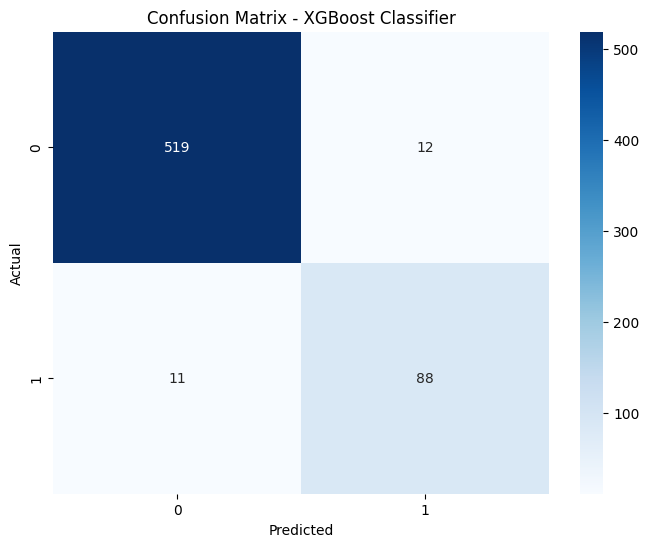

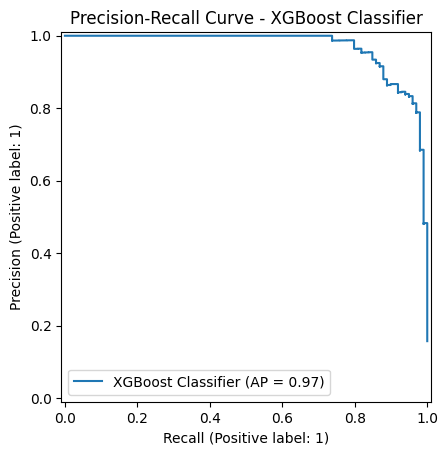

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




In [31]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [66]:
dataset = dataset.drop(index=zero_indices_ch1)
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (86.5%)
Class 1: 331 (13.5%)

Test set proportions:
Class 0: 531 (86.5%)
Class 1: 83 (13.5%)


Results for CART Classifier (Gini):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.88      0.84      0.86        83

    accuracy                           0.96       614
   macro avg       0.93      0.91      0.92       614
weighted avg       0.96      0.96      0.96       614



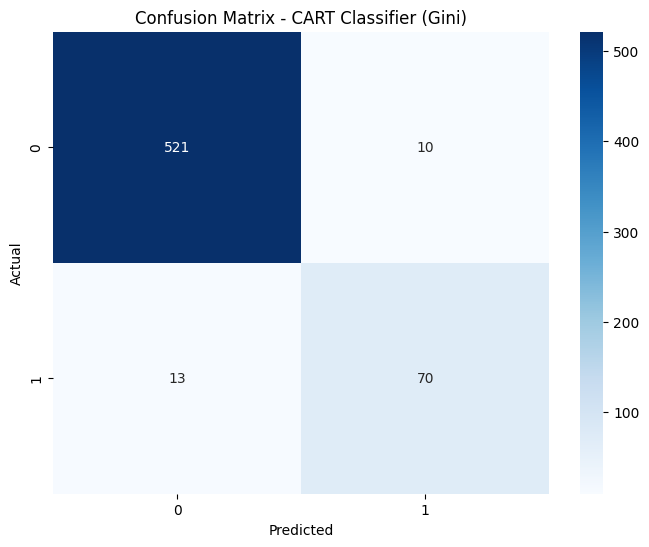

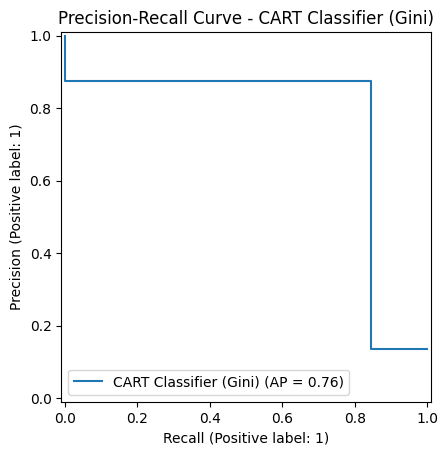

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.86      0.86      0.86        83

    accuracy                           0.96       614
   macro avg       0.92      0.92      0.92       614
weighted avg       0.96      0.96      0.96       614



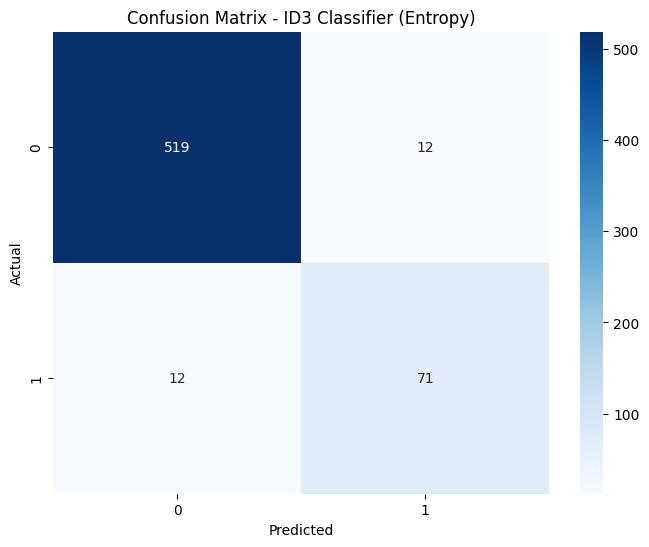

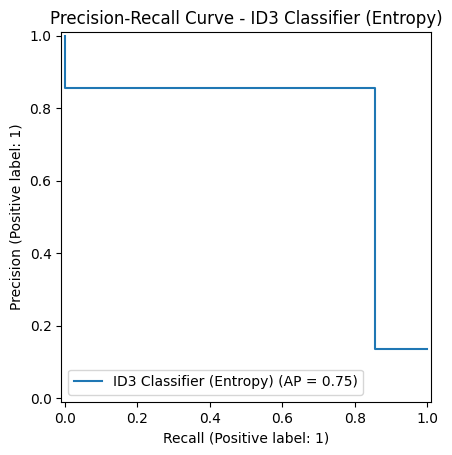

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.86      0.86      0.86        83

    accuracy                           0.96       614
   macro avg       0.92      0.92      0.92       614
weighted avg       0.96      0.96      0.96       614



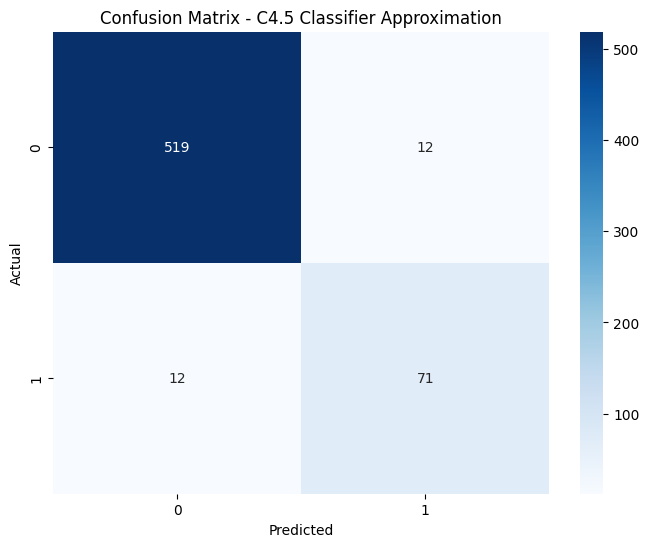

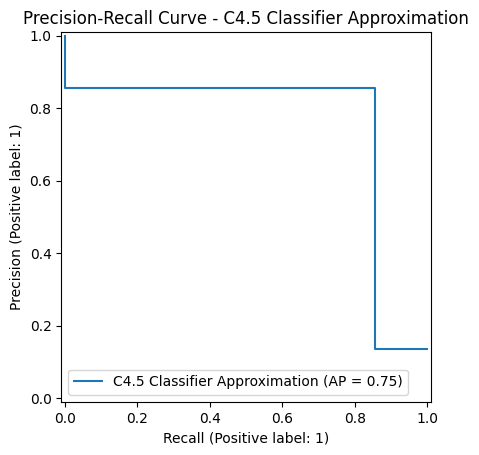

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.85      0.86      0.85        83

    accuracy                           0.96       614
   macro avg       0.91      0.92      0.91       614
weighted avg       0.96      0.96      0.96       614



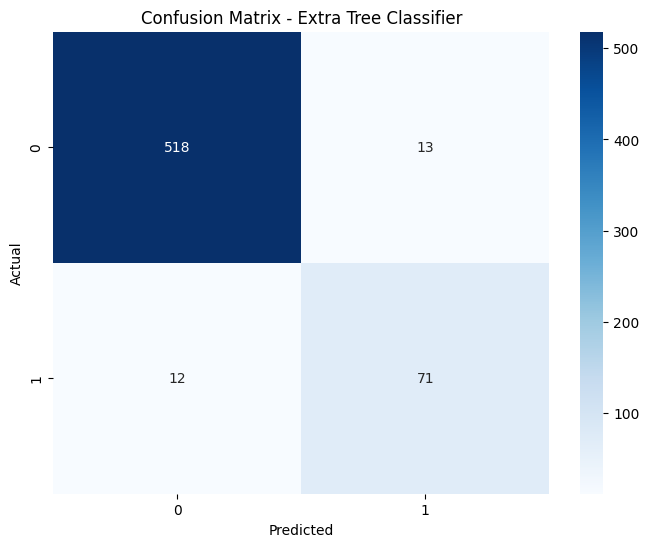

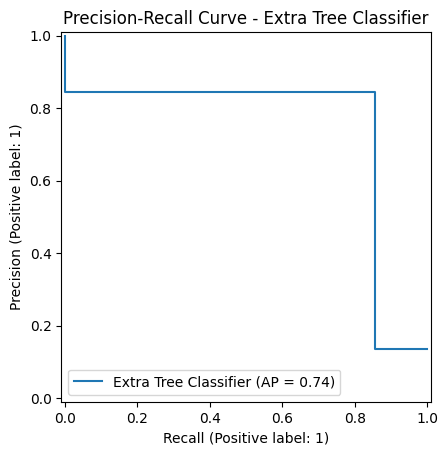

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       531
           1       0.97      0.83      0.90        83

    accuracy                           0.97       614
   macro avg       0.97      0.91      0.94       614
weighted avg       0.97      0.97      0.97       614



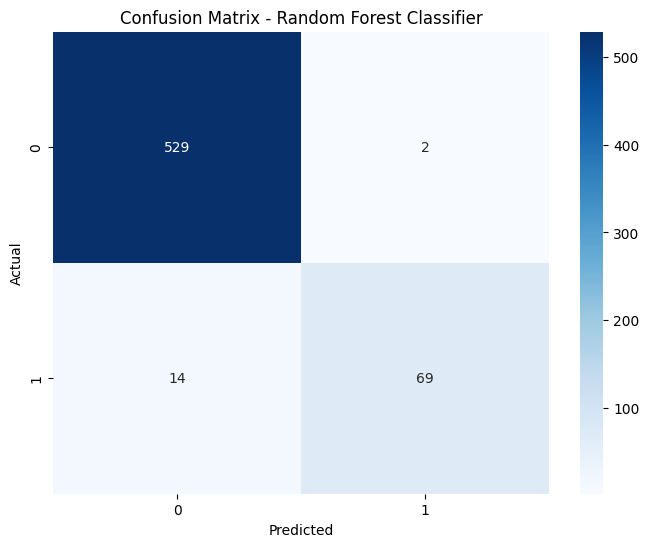

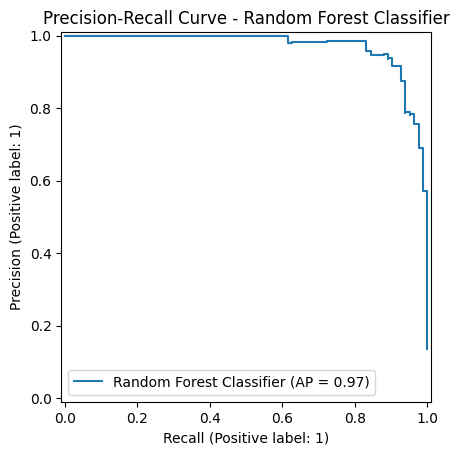

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       531
           1       0.95      0.76      0.85        83

    accuracy                           0.96       614
   macro avg       0.96      0.88      0.91       614
weighted avg       0.96      0.96      0.96       614



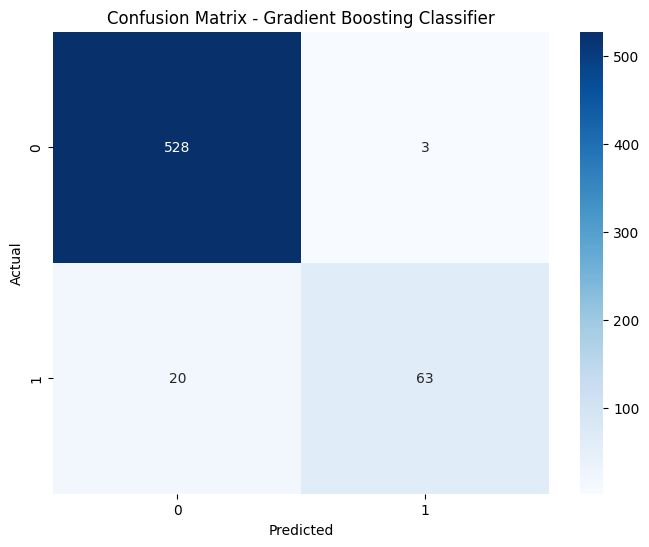

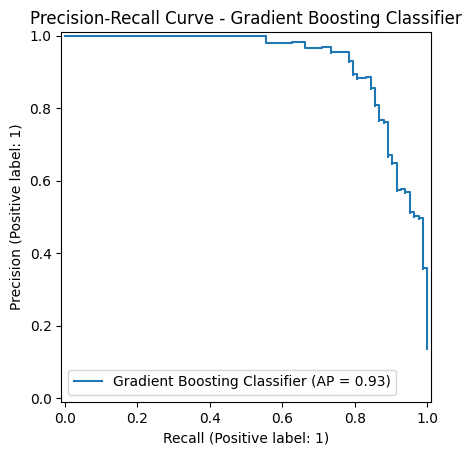

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.86      0.81      0.83        83

    accuracy                           0.96       614
   macro avg       0.91      0.89      0.90       614
weighted avg       0.96      0.96      0.96       614



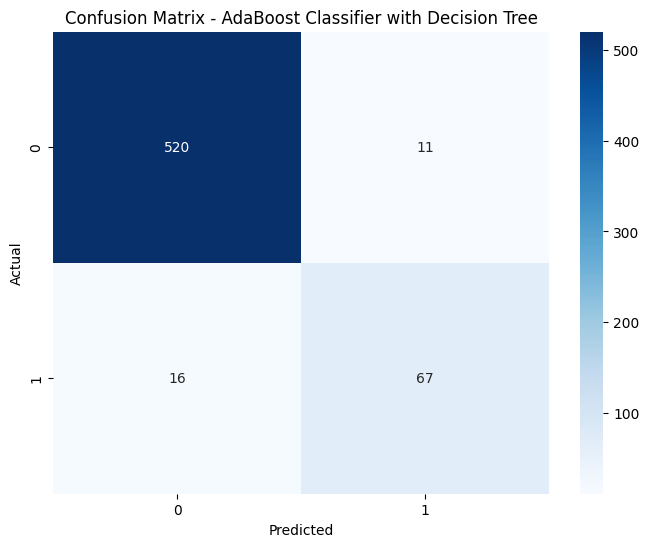

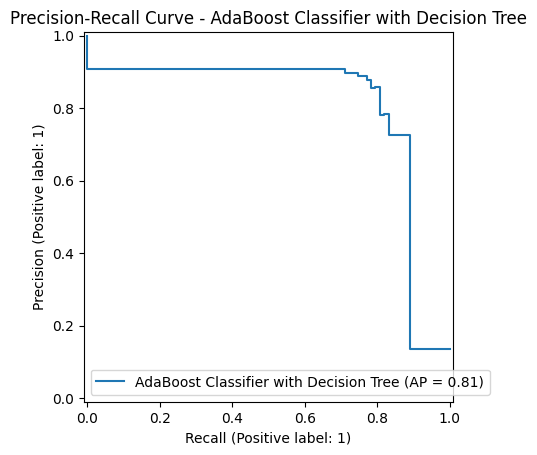

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.97      0.84      0.90        83

    accuracy                           0.98       614
   macro avg       0.97      0.92      0.94       614
weighted avg       0.98      0.98      0.97       614



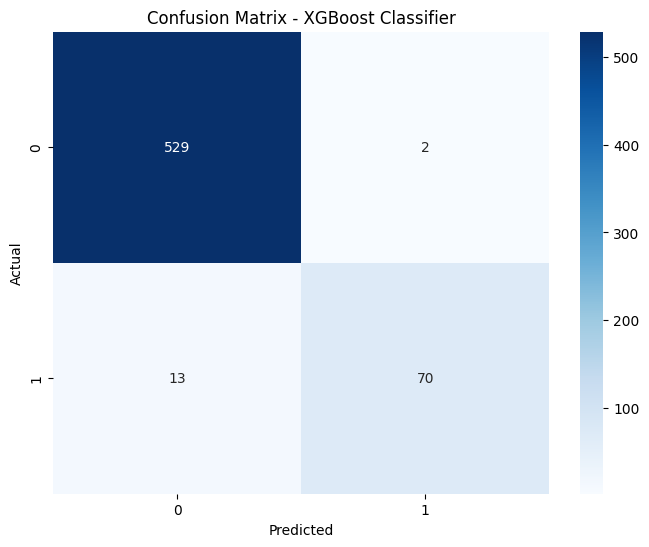

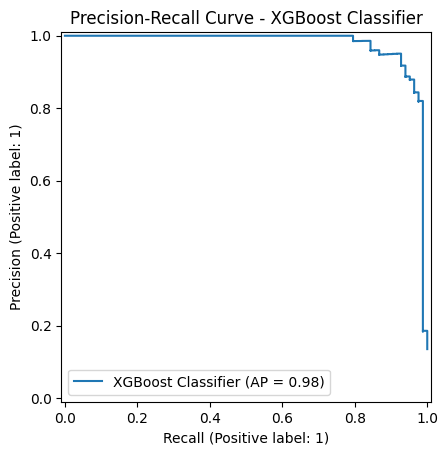

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




In [67]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [69]:

dataset = dataset.drop(index=zero_indices_ch0)
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2065 (83.9%)
Class 1: 396 (16.1%)

Test set proportions:
Class 0: 517 (83.9%)
Class 1: 99 (16.1%)


Results for CART Classifier (Gini):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       517
           1       0.87      0.87      0.87        99

    accuracy                           0.96       616
   macro avg       0.92      0.92      0.92       616
weighted avg       0.96      0.96      0.96       616



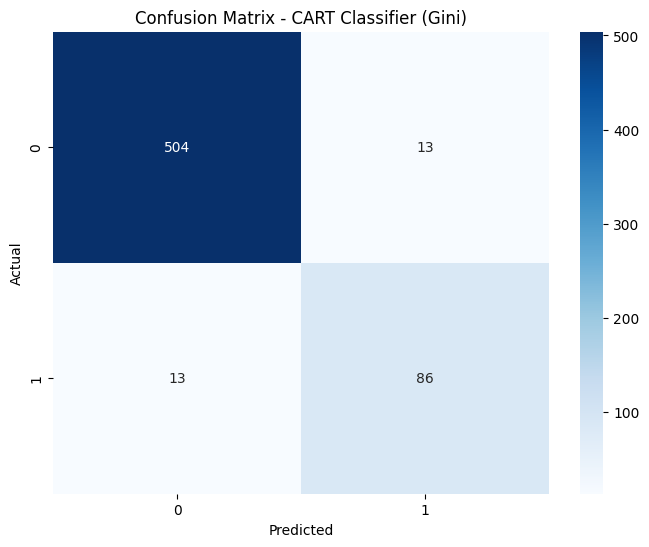

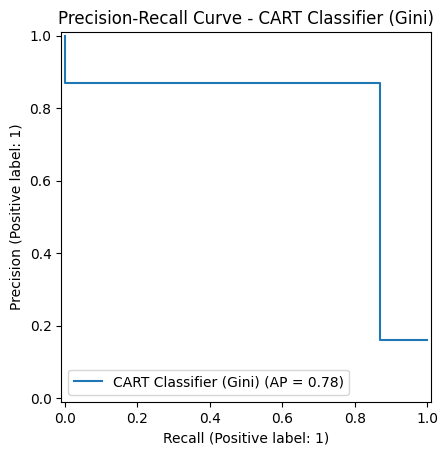

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.91      0.87      0.89        99

    accuracy                           0.96       616
   macro avg       0.94      0.93      0.93       616
weighted avg       0.96      0.96      0.96       616



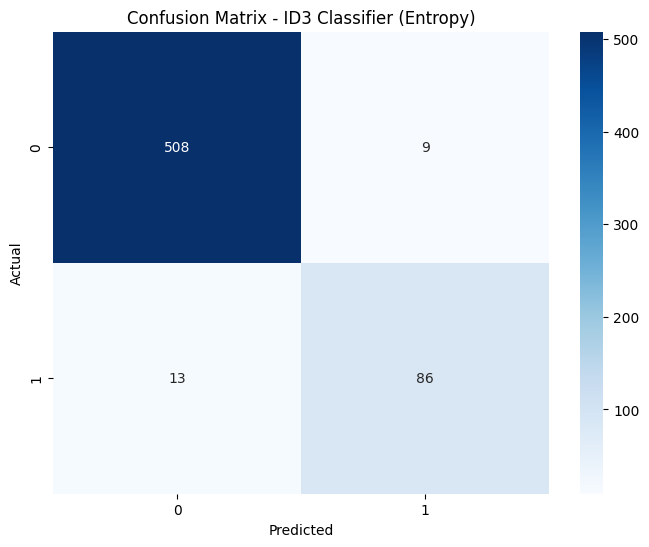

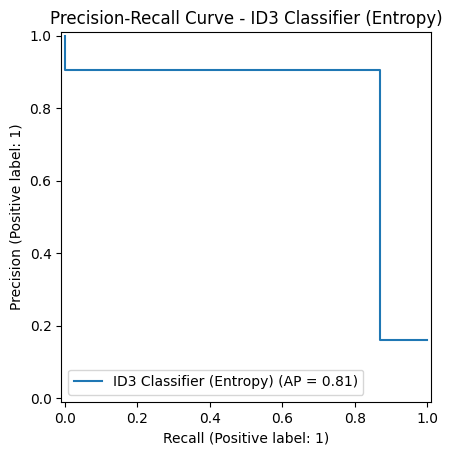

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.91      0.87      0.89        99

    accuracy                           0.96       616
   macro avg       0.94      0.93      0.93       616
weighted avg       0.96      0.96      0.96       616



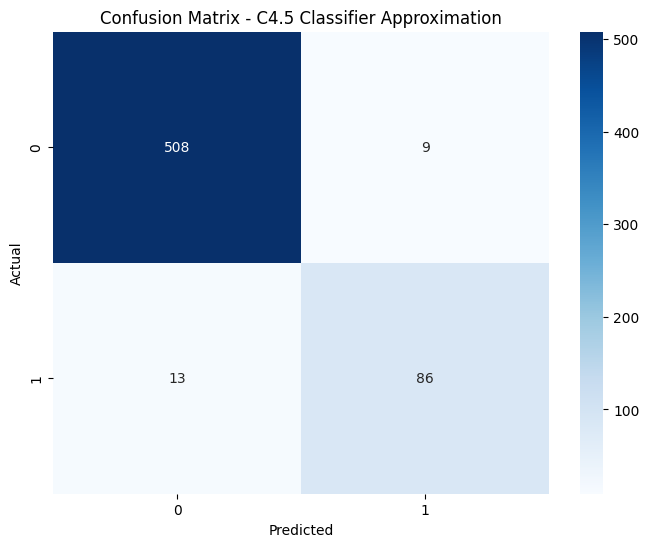

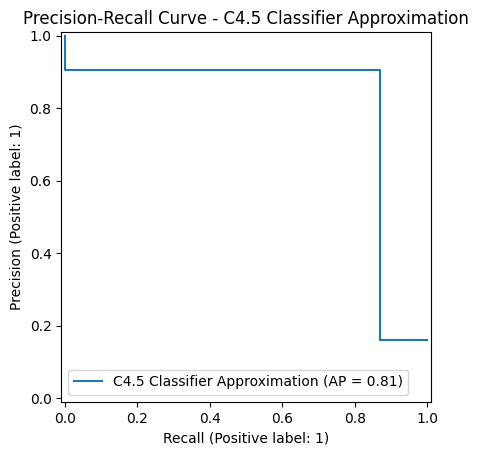

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       517
           1       0.88      0.87      0.87        99

    accuracy                           0.96       616
   macro avg       0.93      0.92      0.92       616
weighted avg       0.96      0.96      0.96       616



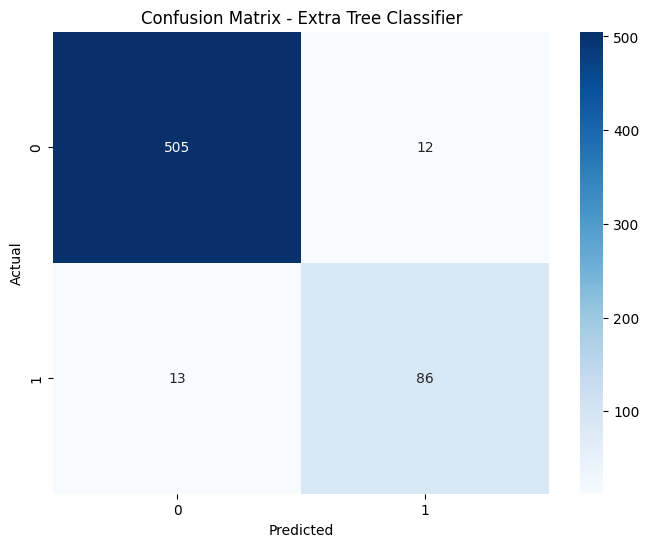

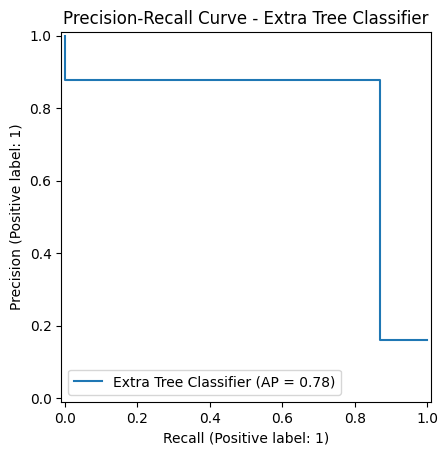

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       517
           1       0.97      0.89      0.93        99

    accuracy                           0.98       616
   macro avg       0.97      0.94      0.96       616
weighted avg       0.98      0.98      0.98       616



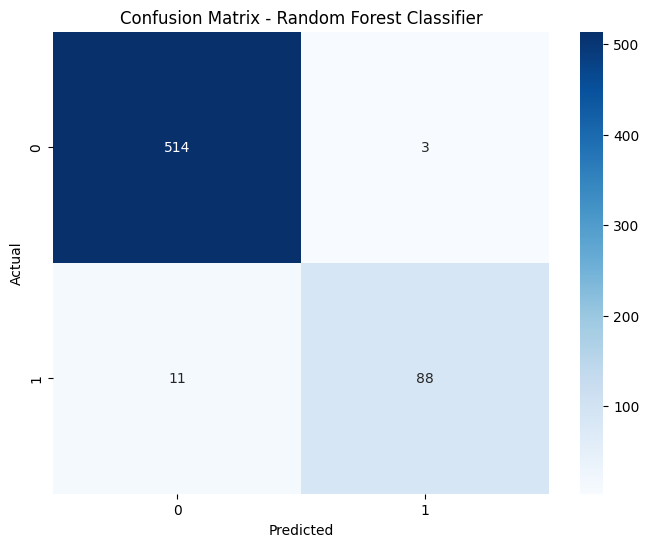

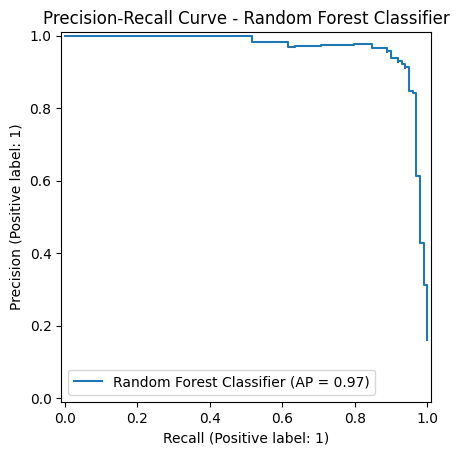

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       517
           1       0.96      0.80      0.87        99

    accuracy                           0.96       616
   macro avg       0.96      0.90      0.93       616
weighted avg       0.96      0.96      0.96       616



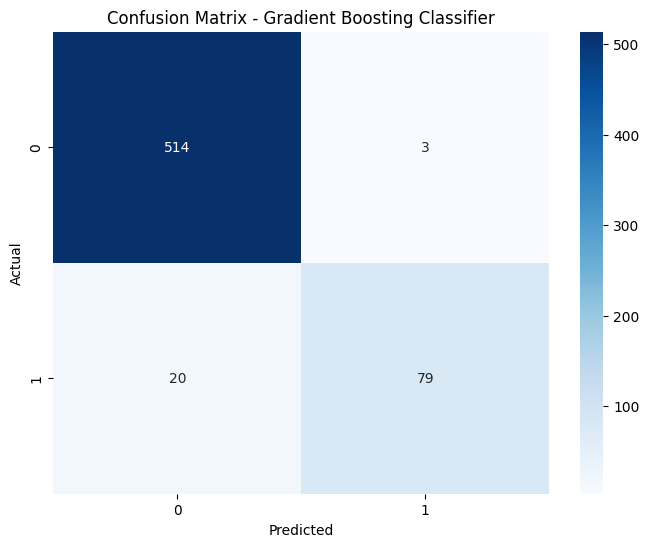

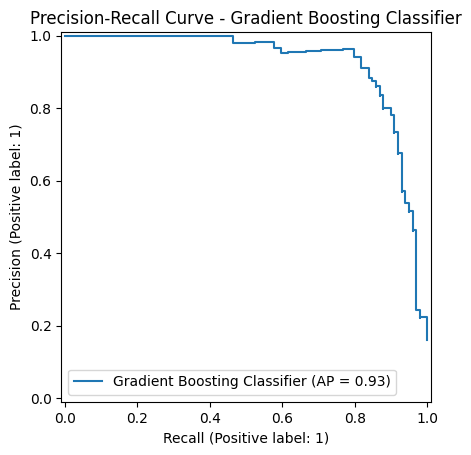

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       517
           1       0.83      0.84      0.83        99

    accuracy                           0.95       616
   macro avg       0.90      0.90      0.90       616
weighted avg       0.95      0.95      0.95       616



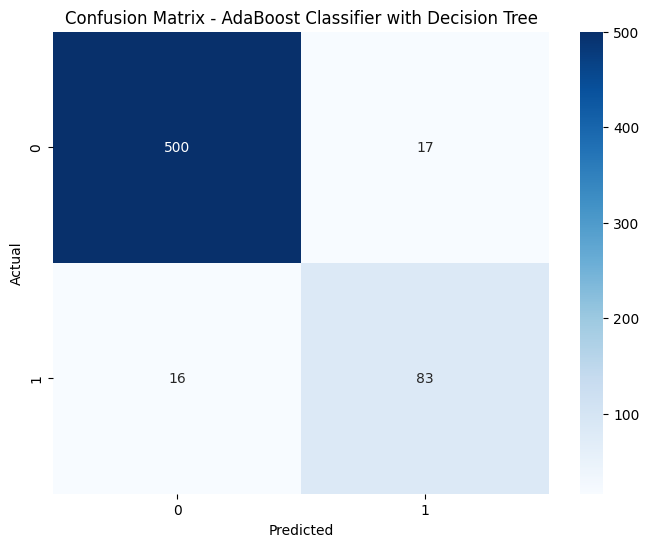

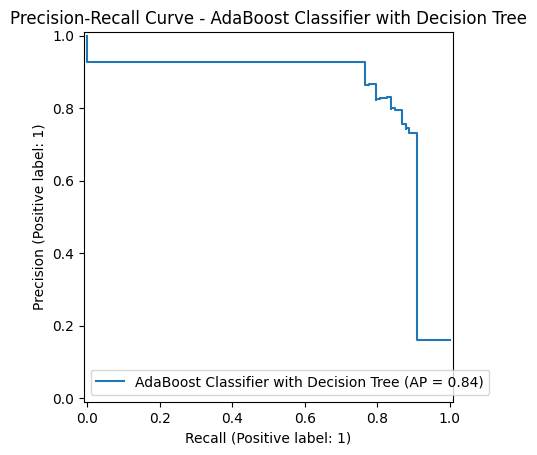

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       517
           1       0.94      0.90      0.92        99

    accuracy                           0.97       616
   macro avg       0.96      0.94      0.95       616
weighted avg       0.97      0.97      0.97       616



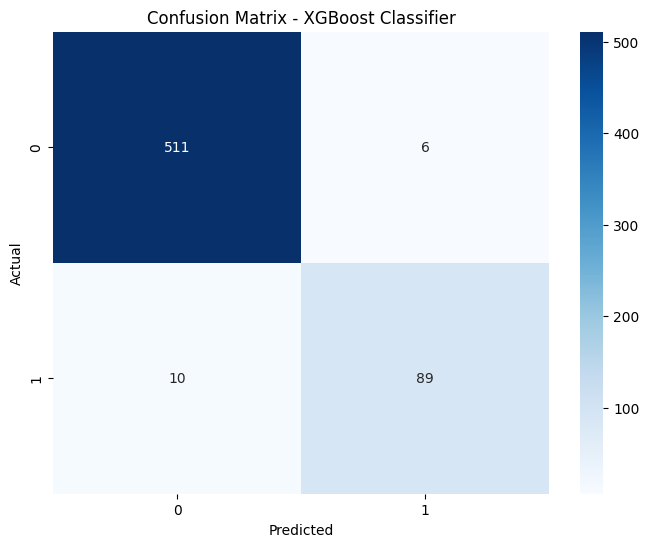

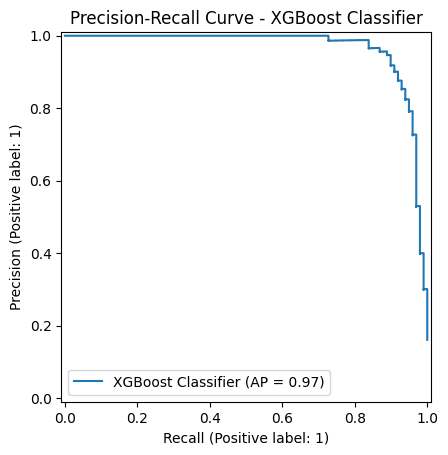

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




In [70]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [72]:
dataset = pd.read_csv('Customer_Churn.csv')
dataset = dataset.drop(index=zero_indices_ch1)
dataset = dataset.drop(index=zero_indices_ch0)
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2065 (86.2%)
Class 1: 331 (13.8%)

Test set proportions:
Class 0: 517 (86.2%)
Class 1: 83 (13.8%)


Results for CART Classifier (Gini):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       517
           1       0.88      0.82      0.85        83

    accuracy                           0.96       600
   macro avg       0.93      0.90      0.91       600
weighted avg       0.96      0.96      0.96       600



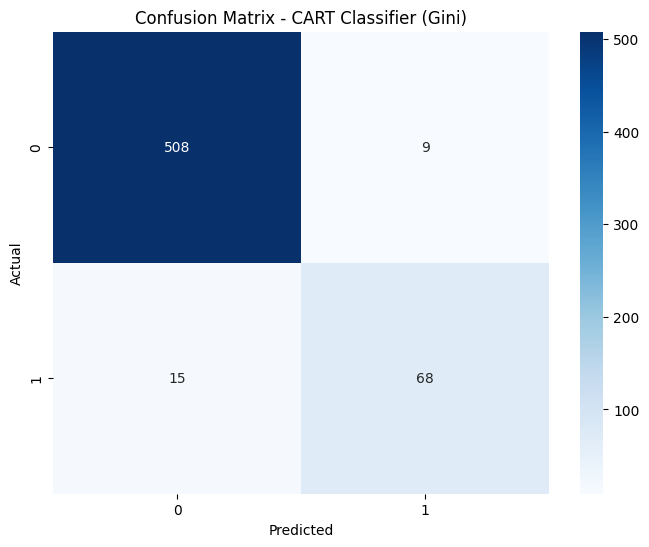

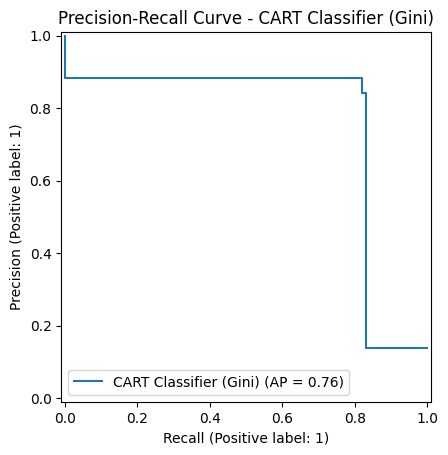

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.88      0.87      0.87        83

    accuracy                           0.96       600
   macro avg       0.93      0.92      0.93       600
weighted avg       0.96      0.96      0.96       600



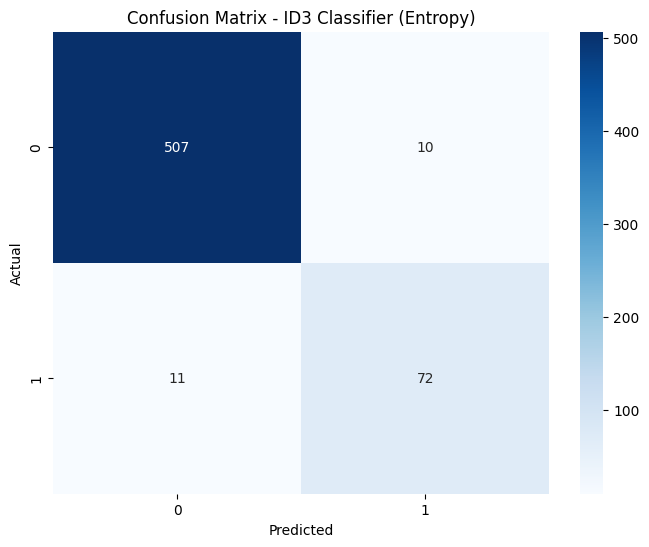

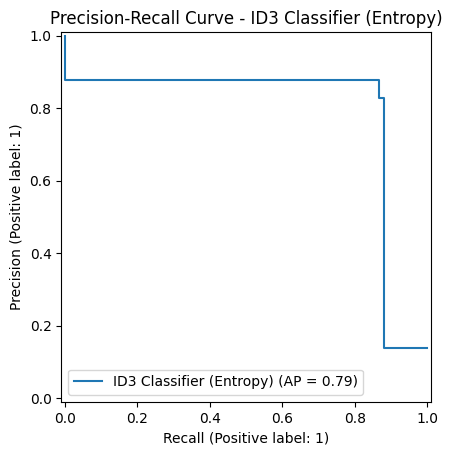

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.88      0.87      0.87        83

    accuracy                           0.96       600
   macro avg       0.93      0.92      0.93       600
weighted avg       0.96      0.96      0.96       600



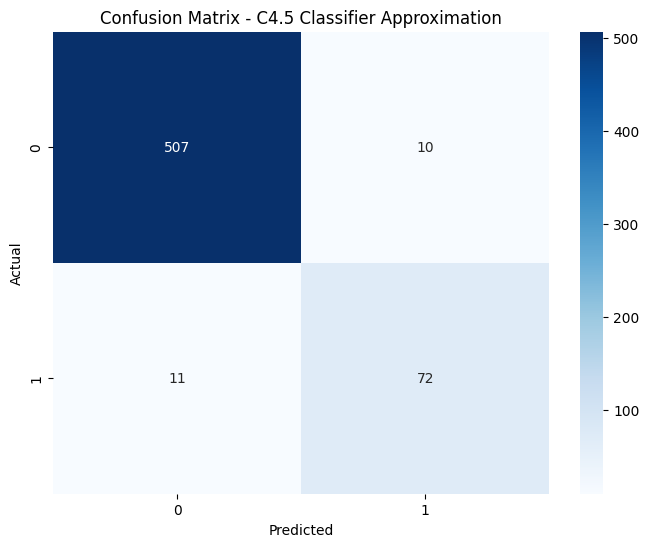

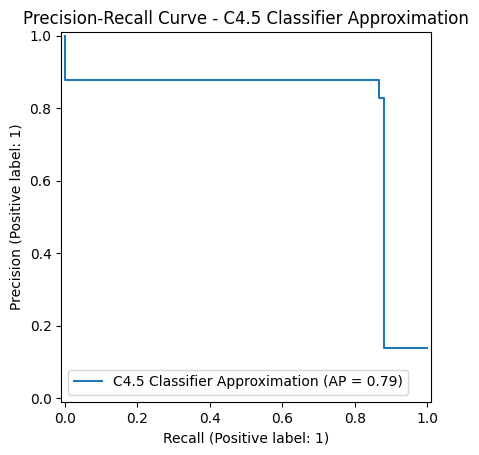

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       517
           1       0.81      0.75      0.78        83

    accuracy                           0.94       600
   macro avg       0.88      0.86      0.87       600
weighted avg       0.94      0.94      0.94       600



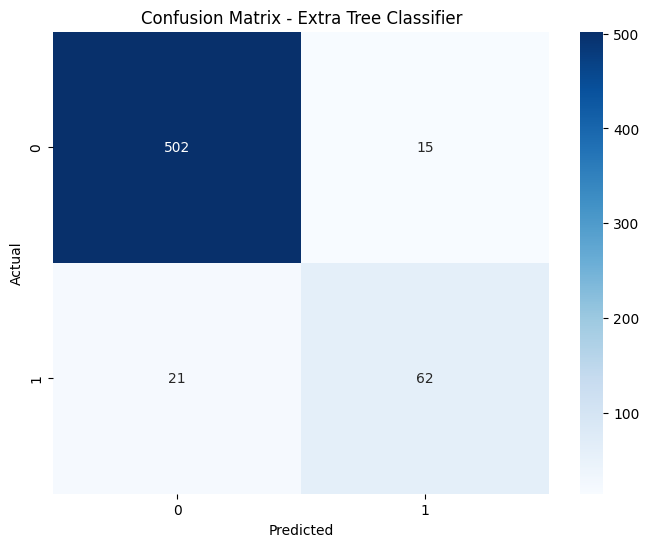

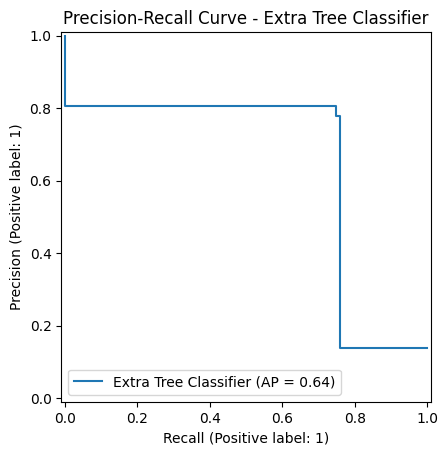

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       517
           1       0.96      0.82      0.88        83

    accuracy                           0.97       600
   macro avg       0.96      0.91      0.93       600
weighted avg       0.97      0.97      0.97       600



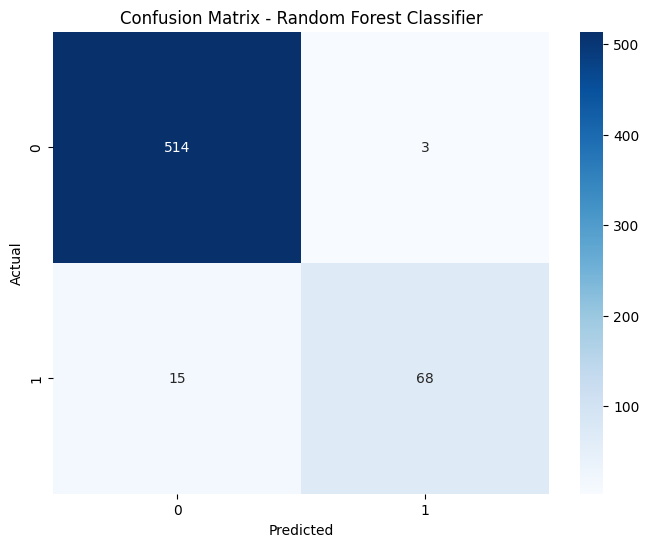

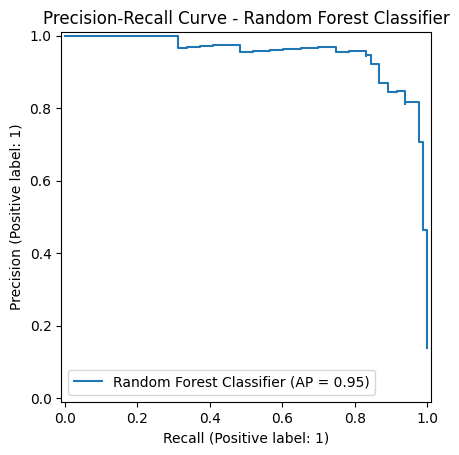

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       517
           1       0.93      0.75      0.83        83

    accuracy                           0.96       600
   macro avg       0.94      0.87      0.90       600
weighted avg       0.96      0.96      0.95       600



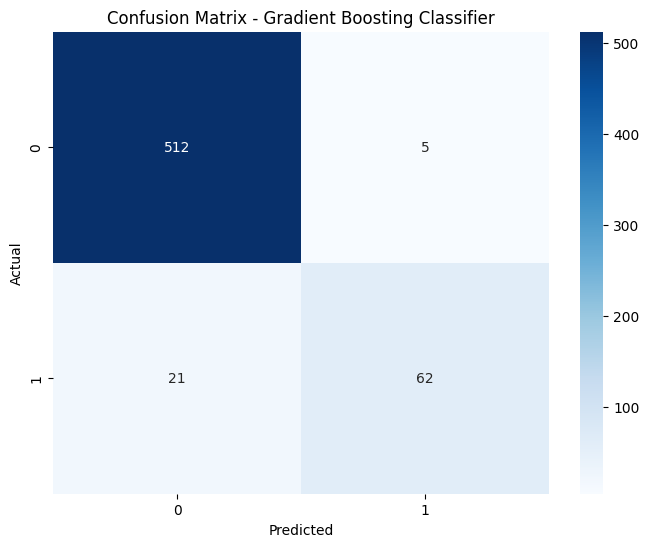

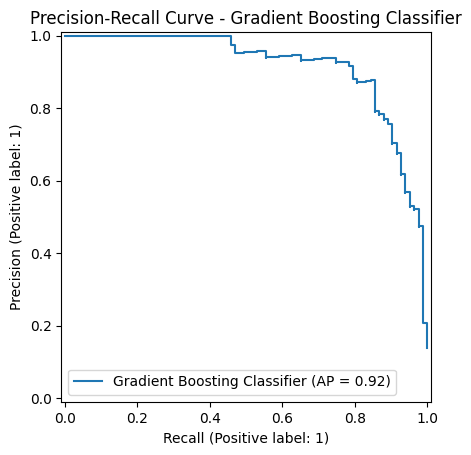

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       517
           1       0.85      0.84      0.85        83

    accuracy                           0.96       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.96      0.96      0.96       600



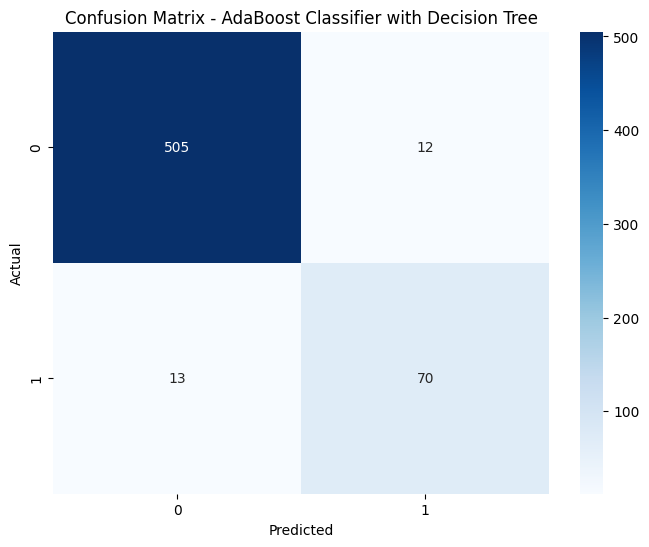

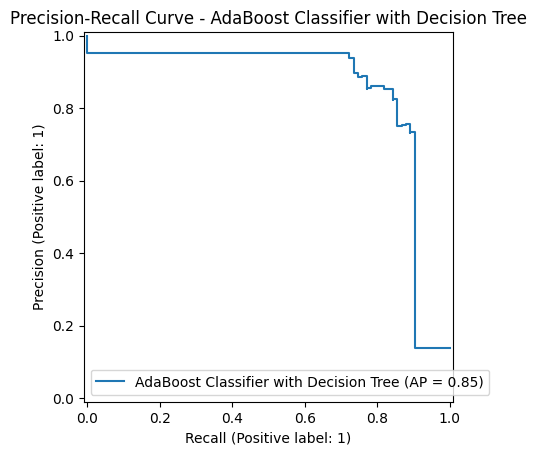

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       517
           1       0.95      0.84      0.89        83

    accuracy                           0.97       600
   macro avg       0.96      0.92      0.94       600
weighted avg       0.97      0.97      0.97       600



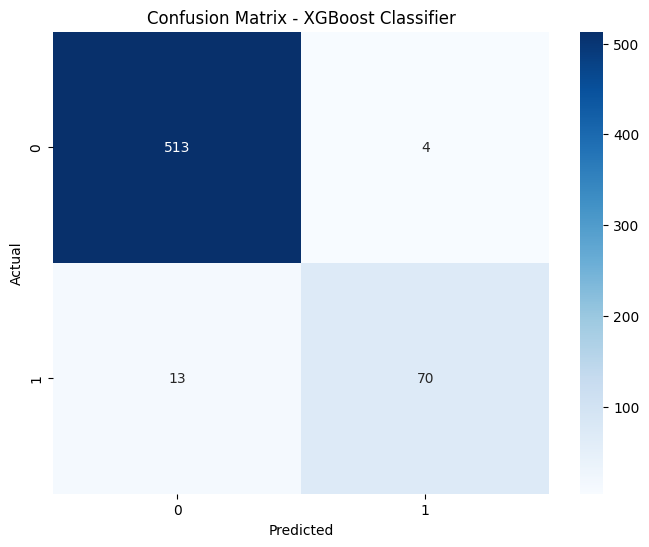

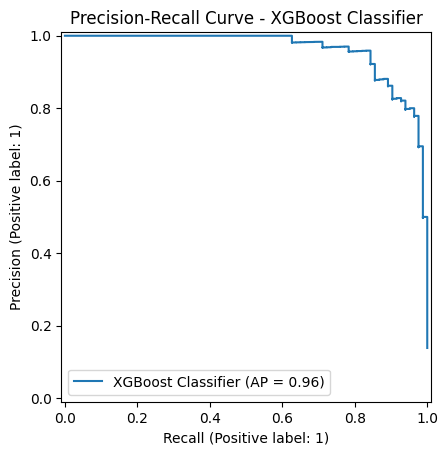

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




In [73]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [83]:
dataset = pd.read_csv('Customer_Churn.csv')



column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13]  

zero_count_ch0 = (
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 0)
).sum()

zero_indices_ch0 = dataset[
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 0)
].index.tolist()


zero_count_ch1 = (
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 1)
).sum()

zero_indices_ch1 = dataset[
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 1)
].index.tolist()


columns_to_fill = [0, 3, 4, 5, 6, 7, 12]


for col_idx in columns_to_fill:
    # Mean for Churn = 0
    mean_ch0 = dataset.loc[dataset.iloc[:, 13] == 0, dataset.columns[col_idx]].mean()
    # Mean for Churn = 1
    mean_ch1 = dataset.loc[dataset.iloc[:, 13] == 1, dataset.columns[col_idx]].mean()
    
    # Only modify rows in zero_indices_ch0 for this column
    dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = mean_ch0
    
    # Only modify rows in zero_indices_ch1 for this column
    dataset.loc[zero_indices_ch1, dataset.columns[col_idx]] = mean_ch1



C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\706836367.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.656120527306968' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = mean_ch0
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\706836367.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0757062146892655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = mean_ch0
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\706836367.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5014.224105461393' has dtype incompat

In [84]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (84.3%)
Class 1: 396 (15.7%)

Test set proportions:
Class 0: 531 (84.3%)
Class 1: 99 (15.7%)


Results for CART Classifier (Gini):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.87      0.84      0.86        99

    accuracy                           0.96       630
   macro avg       0.92      0.91      0.91       630
weighted avg       0.95      0.96      0.96       630



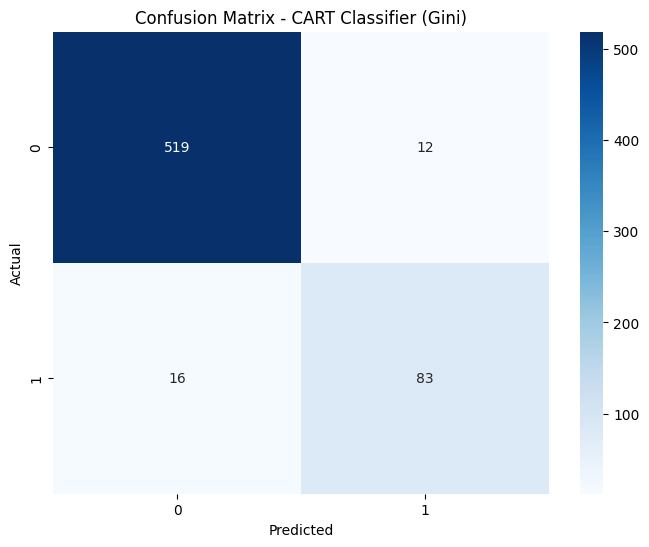

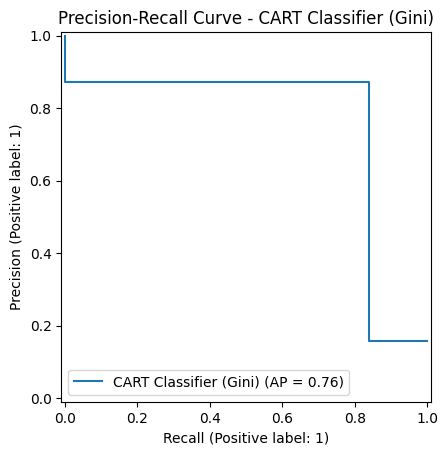

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.91      0.87      0.89        99

    accuracy                           0.97       630
   macro avg       0.94      0.93      0.93       630
weighted avg       0.96      0.97      0.96       630



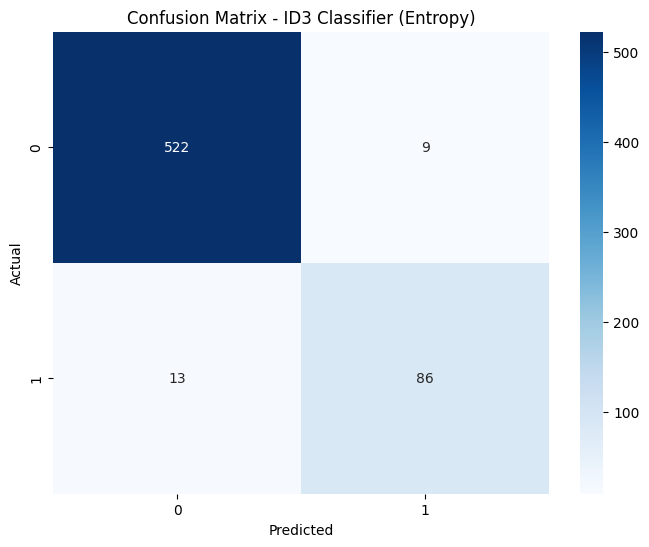

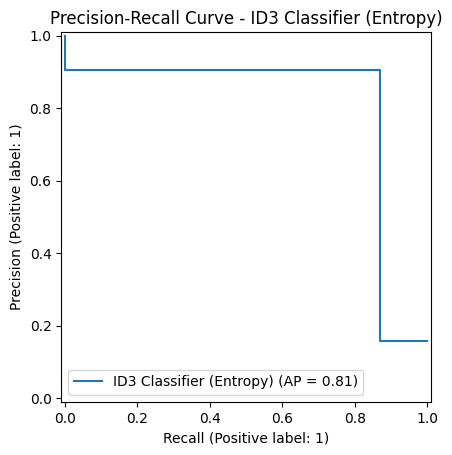

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.91      0.87      0.89        99

    accuracy                           0.97       630
   macro avg       0.94      0.93      0.93       630
weighted avg       0.96      0.97      0.96       630



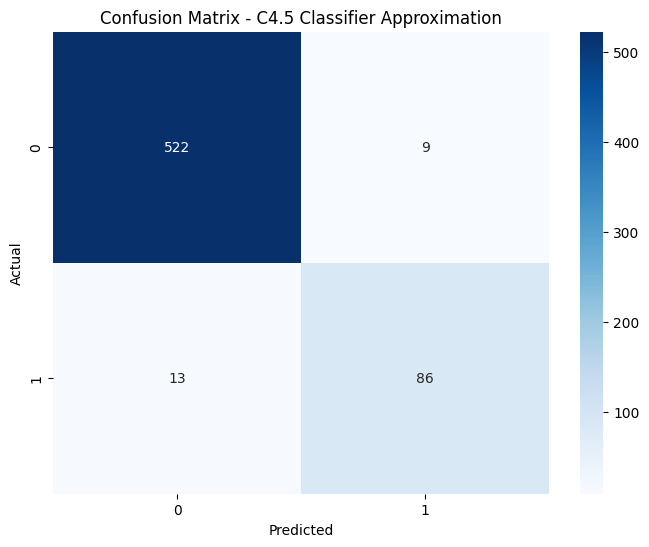

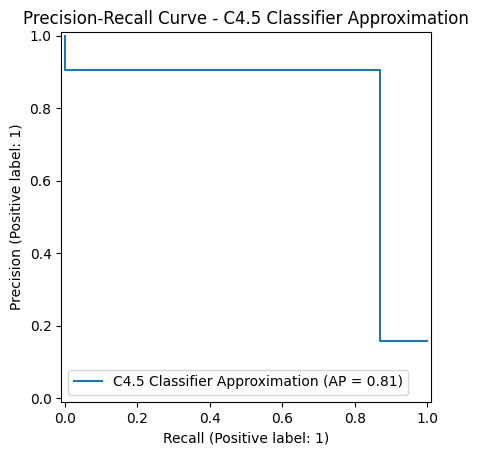

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       531
           1       0.88      0.79      0.83        99

    accuracy                           0.95       630
   macro avg       0.92      0.88      0.90       630
weighted avg       0.95      0.95      0.95       630



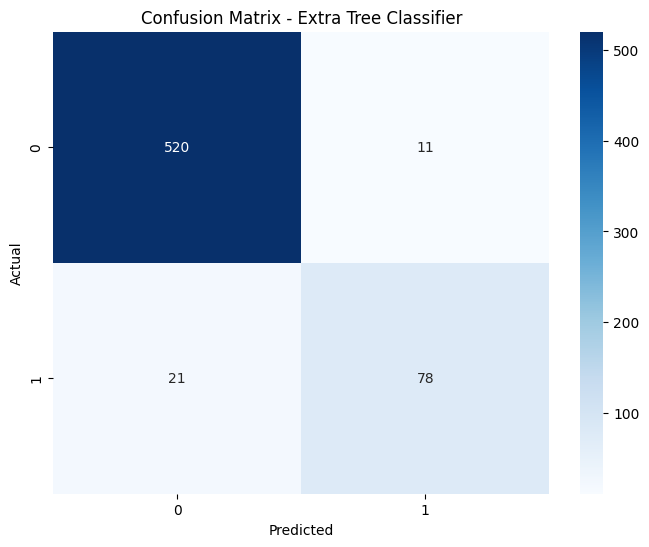

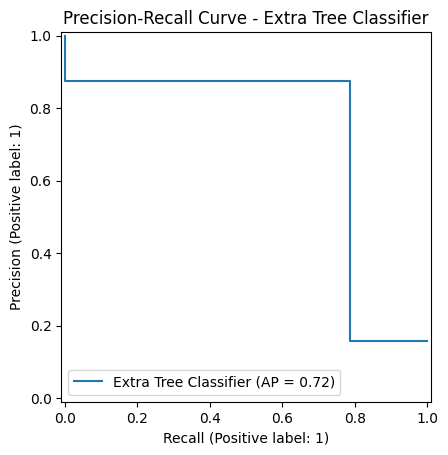

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.98      0.88      0.93        99

    accuracy                           0.98       630
   macro avg       0.98      0.94      0.96       630
weighted avg       0.98      0.98      0.98       630



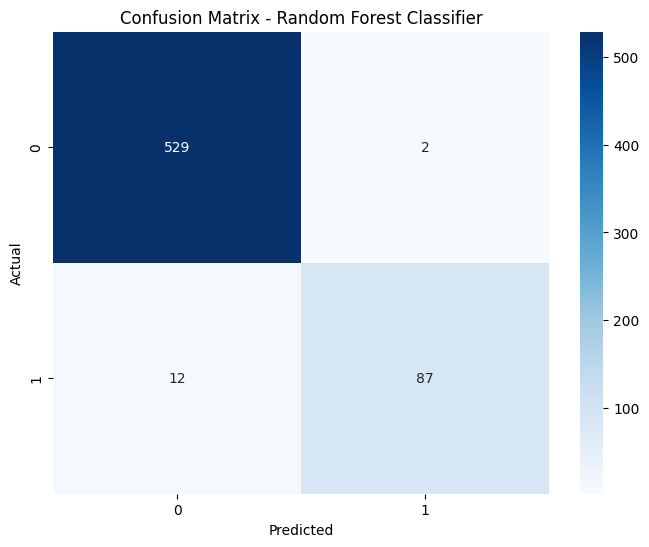

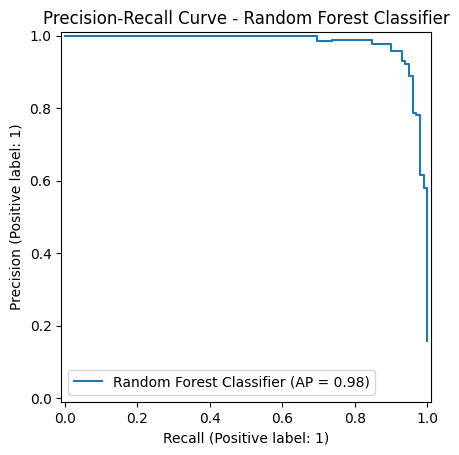

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       531
           1       0.93      0.77      0.84        99

    accuracy                           0.95       630
   macro avg       0.94      0.88      0.91       630
weighted avg       0.95      0.95      0.95       630



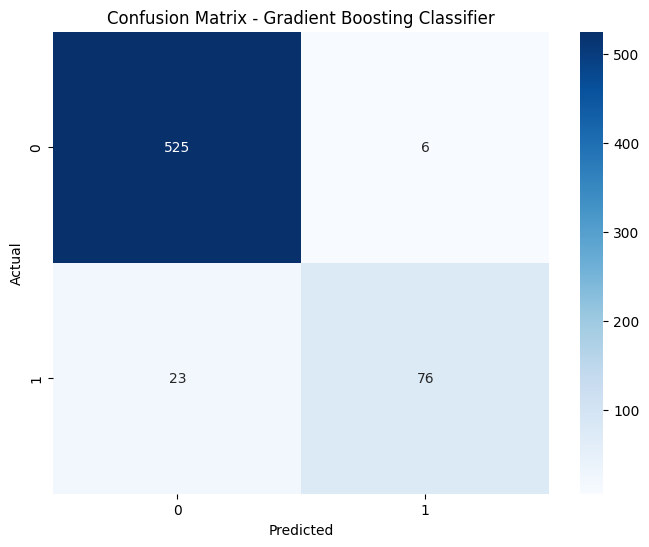

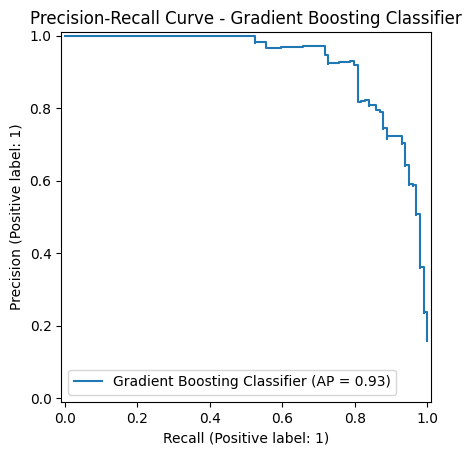

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       531
           1       0.86      0.88      0.87        99

    accuracy                           0.96       630
   macro avg       0.92      0.93      0.92       630
weighted avg       0.96      0.96      0.96       630



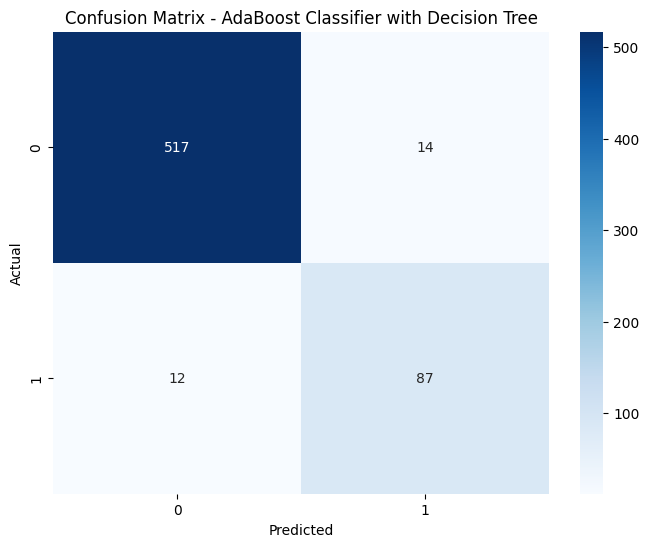

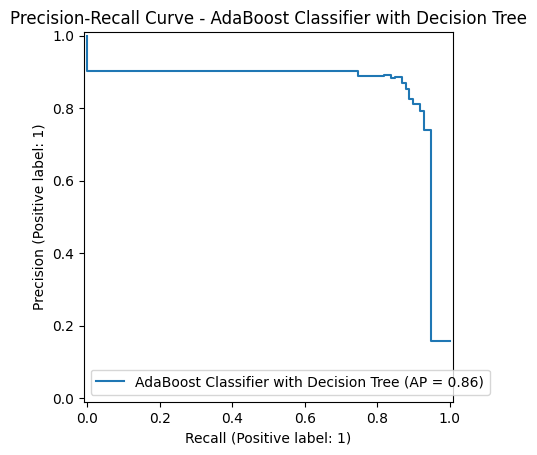

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.92      0.91      0.91        99

    accuracy                           0.97       630
   macro avg       0.95      0.95      0.95       630
weighted avg       0.97      0.97      0.97       630



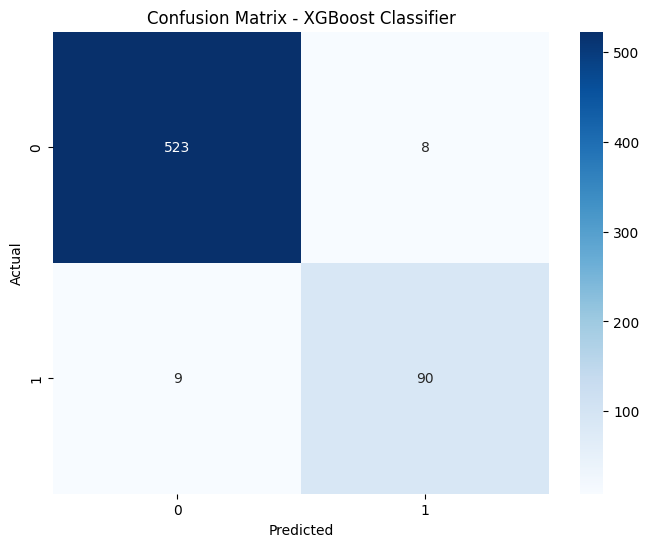

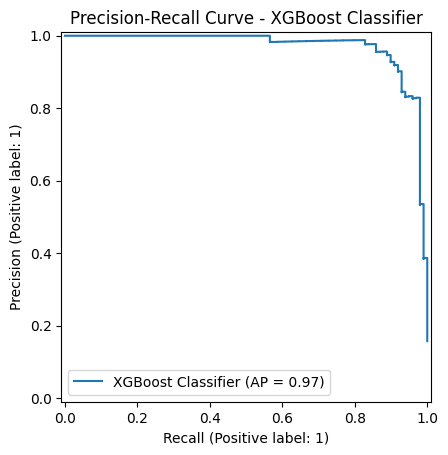

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




In [85]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [87]:

dataset = pd.read_csv('Customer_Churn.csv')


column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13] 


zero_count_ch0 = (
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 0)
).sum()

zero_indices_ch0 = dataset[
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 0)
].index.tolist()


zero_count_ch1 = (
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 1)
).sum()

zero_indices_ch1 = dataset[
    (column_0 == 0) &
    (column_4 == 0) &
    (column_5 == 0) &
    (column_13 == 1)
].index.tolist()




columns_to_fill = [0, 3, 4, 5, 6, 7, 12]

for col_idx in columns_to_fill:
    # Median for Churn = 0
    median_ch0 = dataset.loc[dataset.iloc[:, 13] == 0, dataset.columns[col_idx]].median()
    # Median for Churn = 1
    median_ch1 = dataset.loc[dataset.iloc[:, 13] == 1, dataset.columns[col_idx]].median()
    
    # Only modify rows in zero_indices_ch0 for this column
    dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = median_ch0
    
    # Only modify rows in zero_indices_ch1 for this column
    dataset.loc[zero_indices_ch1, dataset.columns[col_idx]] = median_ch1

# (Optional) Save the updated dataset to a new CSV file
dataset.to_csv("Customer_Churn_Filled_Median.csv", index=False)


In [88]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (84.3%)
Class 1: 396 (15.7%)

Test set proportions:
Class 0: 531 (84.3%)
Class 1: 99 (15.7%)


Results for CART Classifier (Gini):
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.86      0.83      0.85        99

    accuracy                           0.95       630
   macro avg       0.92      0.90      0.91       630
weighted avg       0.95      0.95      0.95       630



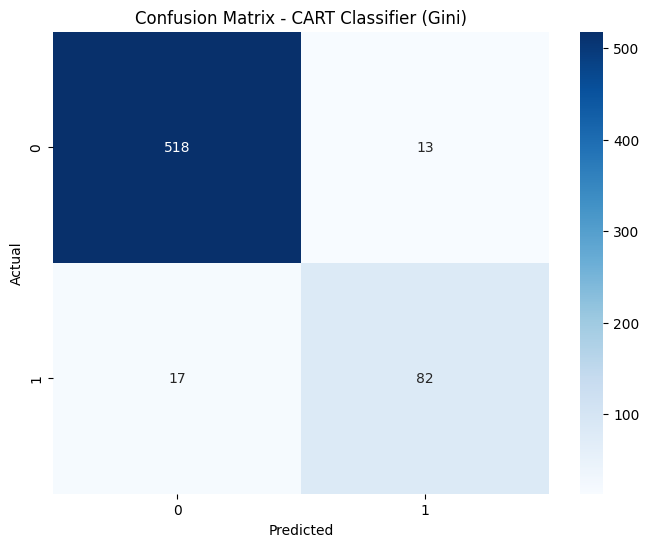

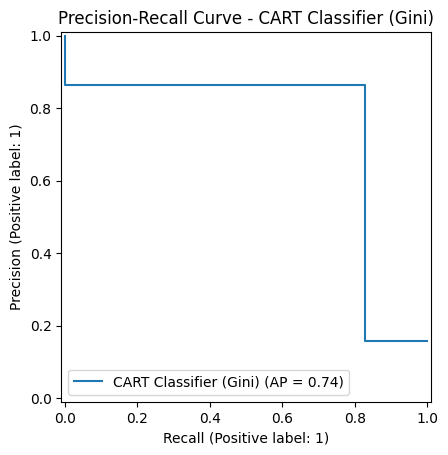

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.87      0.87      0.87        99

    accuracy                           0.96       630
   macro avg       0.92      0.92      0.92       630
weighted avg       0.96      0.96      0.96       630



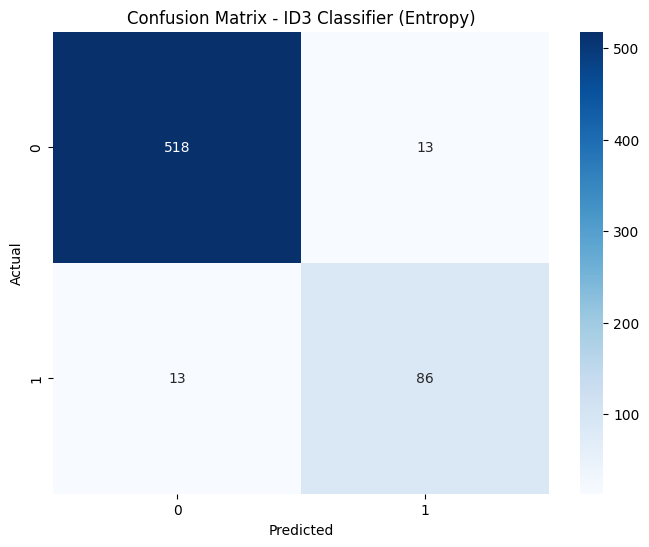

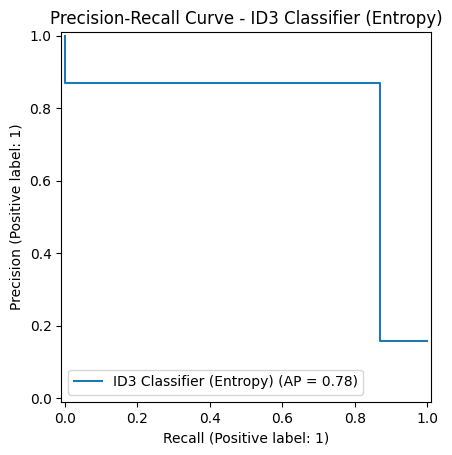

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.87      0.87      0.87        99

    accuracy                           0.96       630
   macro avg       0.92      0.92      0.92       630
weighted avg       0.96      0.96      0.96       630



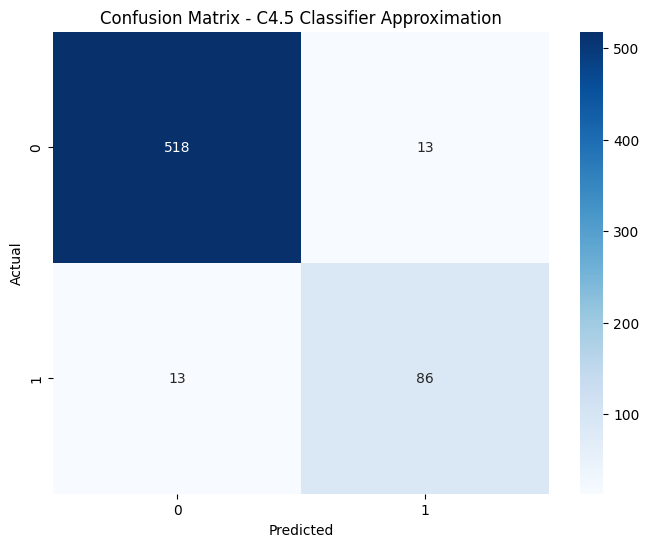

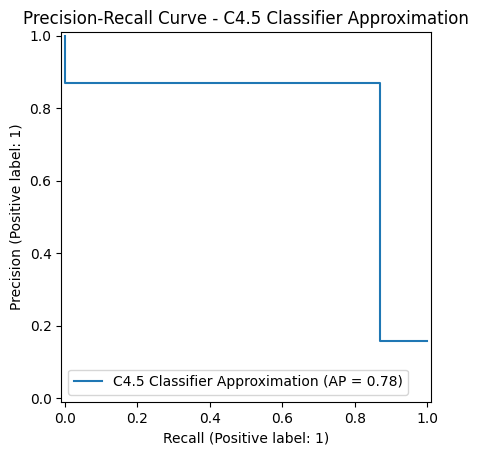

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       531
           1       0.89      0.84      0.86        99

    accuracy                           0.96       630
   macro avg       0.93      0.91      0.92       630
weighted avg       0.96      0.96      0.96       630



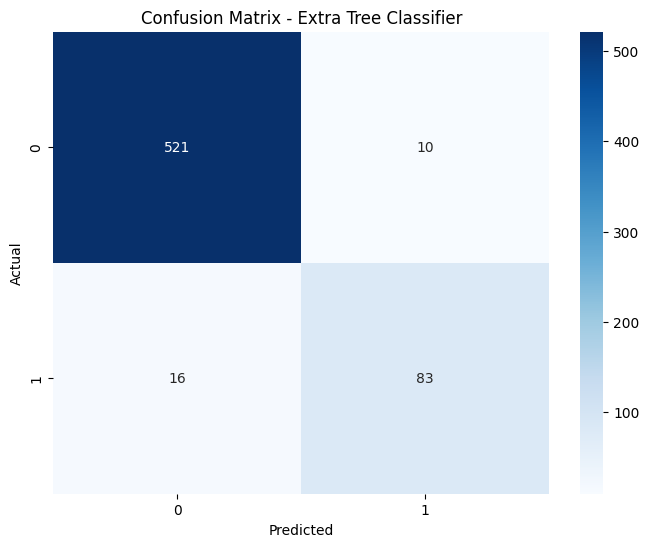

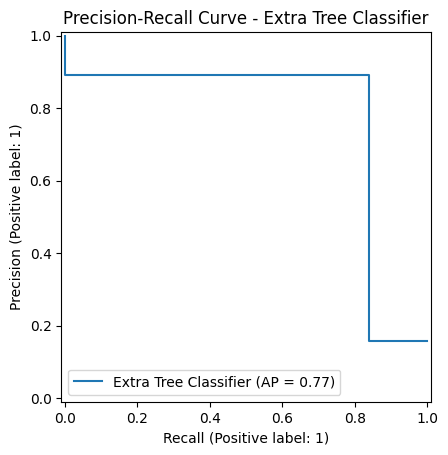

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]


Results for Random Forest Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.97      0.89      0.93        99

    accuracy                           0.98       630
   macro avg       0.97      0.94      0.96       630
weighted avg       0.98      0.98      0.98       630



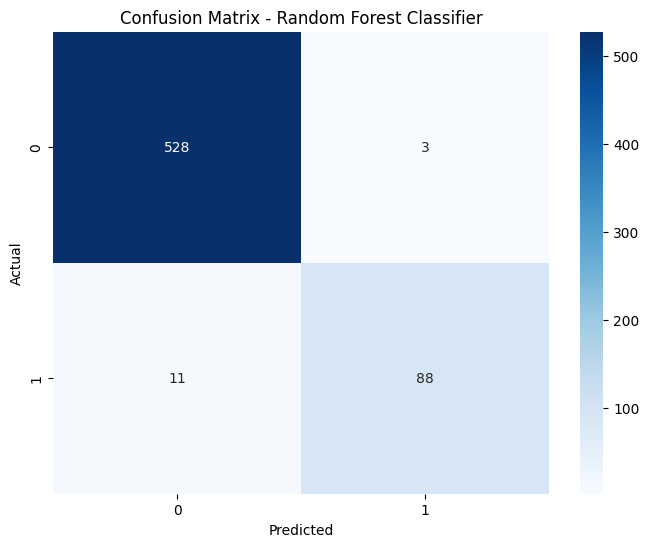

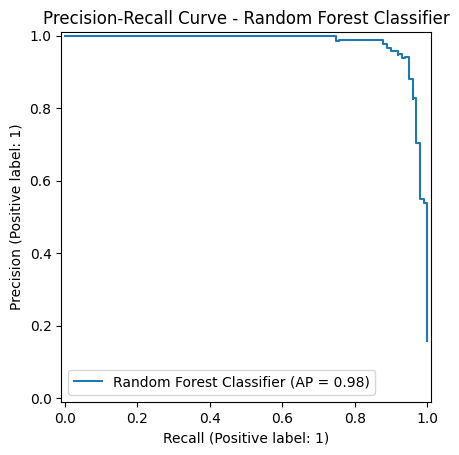

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       531
           1       0.95      0.76      0.84        99

    accuracy                           0.96       630
   macro avg       0.95      0.88      0.91       630
weighted avg       0.96      0.96      0.95       630



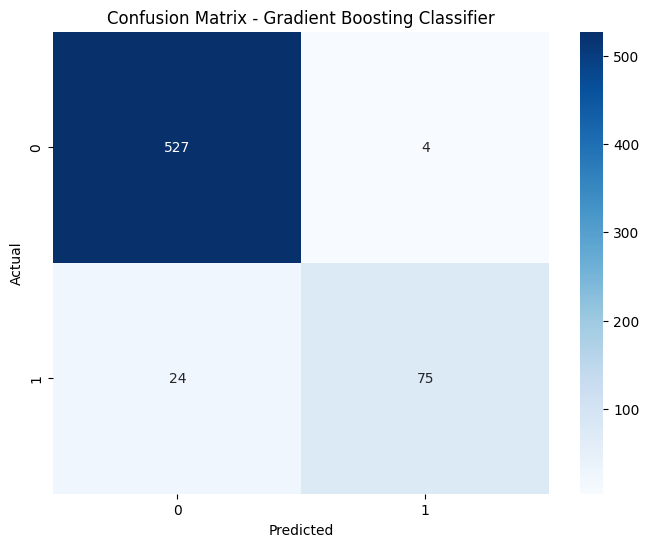

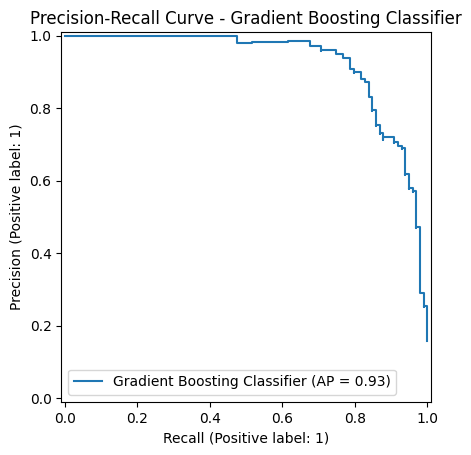

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       531
           1       0.85      0.84      0.84        99

    accuracy                           0.95       630
   macro avg       0.91      0.91      0.91       630
weighted avg       0.95      0.95      0.95       630



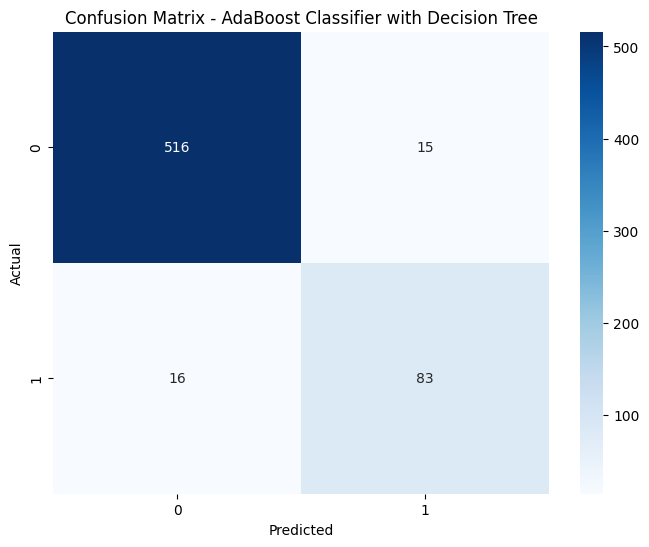

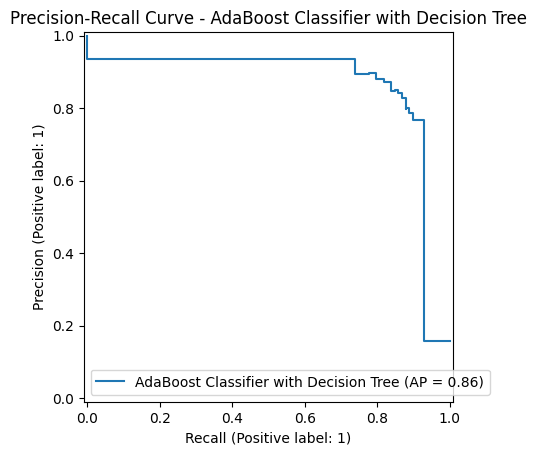

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       531
           1       0.95      0.92      0.93        99

    accuracy                           0.98       630
   macro avg       0.97      0.95      0.96       630
weighted avg       0.98      0.98      0.98       630



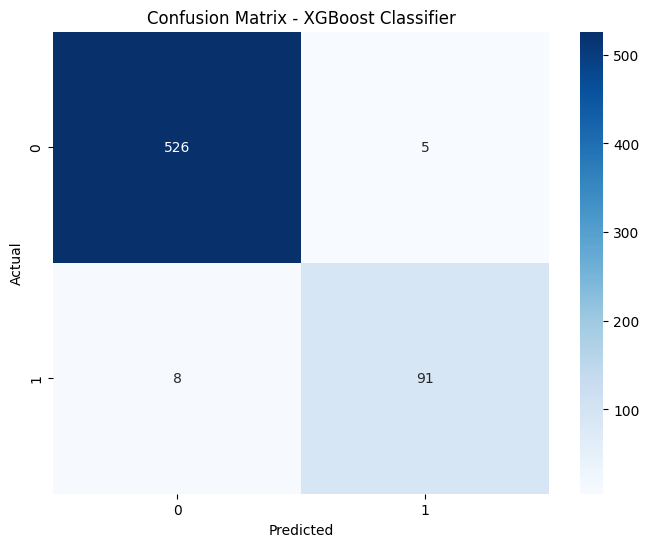

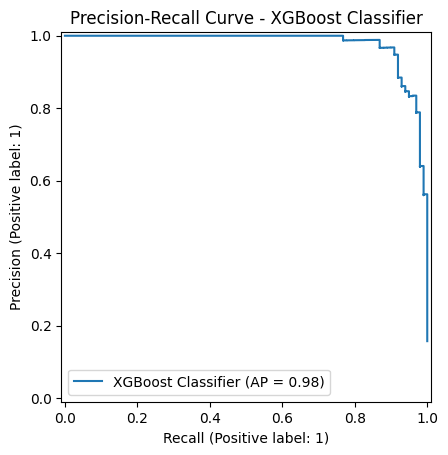

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




In [89]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [103]:
dataset = pd.read_csv('Customer_Churn.csv')


column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]  
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13]


zero_indices_ch0 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 0))].index.tolist()

dataset = dataset.drop(index=zero_indices_ch0)



zero_indices_ch1 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1))].index.tolist()


columns_to_fill = [0, 3, 4, 5, 6, 7, 12]


for col_idx in columns_to_fill:

    col_mean = dataset.iloc[:, col_idx].mean()
    
   
    dataset.loc[zero_indices_ch1, dataset.columns[col_idx]] = col_mean




C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\1342725818.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_indices_ch1 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1))].index.tolist()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\1342725818.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.808904777380565' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[zero_indices_ch1, dataset.columns[col_idx]] = col_mean
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\1342725818.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9642508937276568' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[zero_indices_ch1, datase

In [104]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2065 (83.9%)
Class 1: 396 (16.1%)

Test set proportions:
Class 0: 517 (83.9%)
Class 1: 99 (16.1%)


Results for CART Classifier (Gini):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       517
           1       0.90      0.84      0.87        99

    accuracy                           0.96       616
   macro avg       0.94      0.91      0.92       616
weighted avg       0.96      0.96      0.96       616



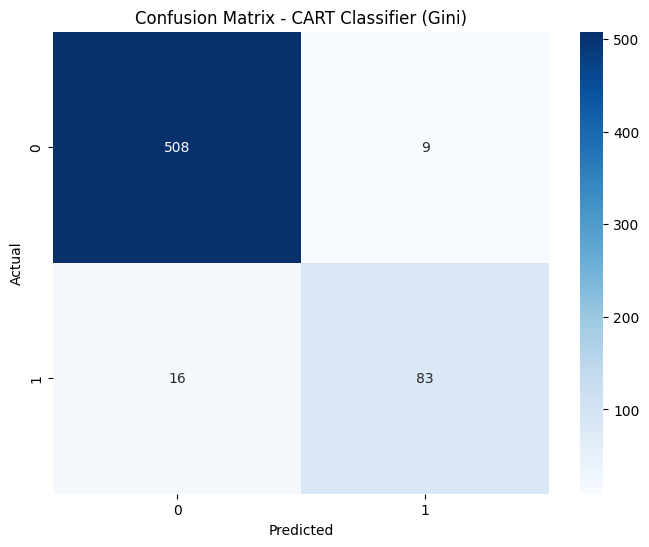

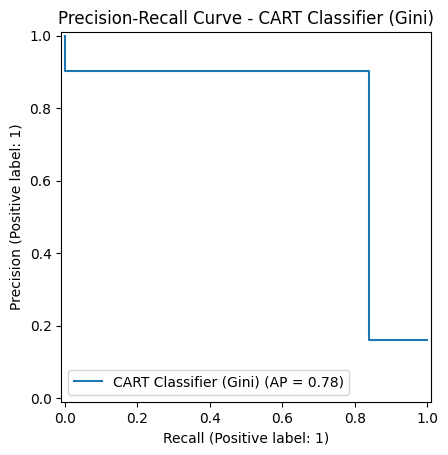

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       517
           1       0.89      0.83      0.86        99

    accuracy                           0.96       616
   macro avg       0.93      0.90      0.92       616
weighted avg       0.96      0.96      0.96       616



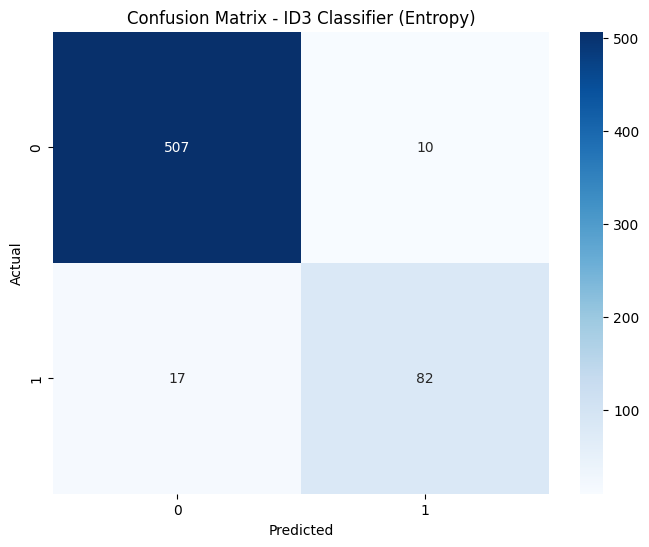

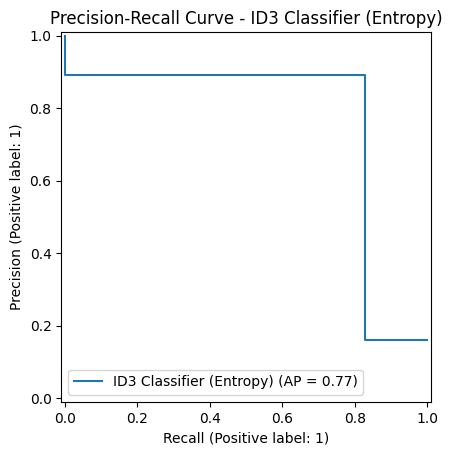

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       517
           1       0.89      0.83      0.86        99

    accuracy                           0.96       616
   macro avg       0.93      0.90      0.92       616
weighted avg       0.96      0.96      0.96       616



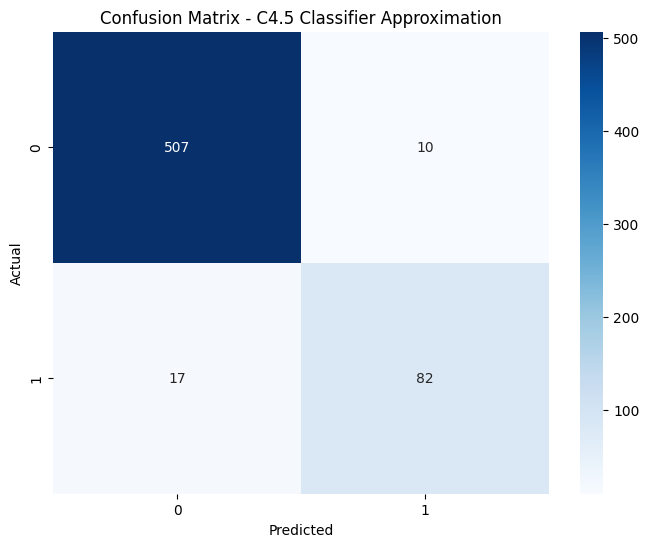

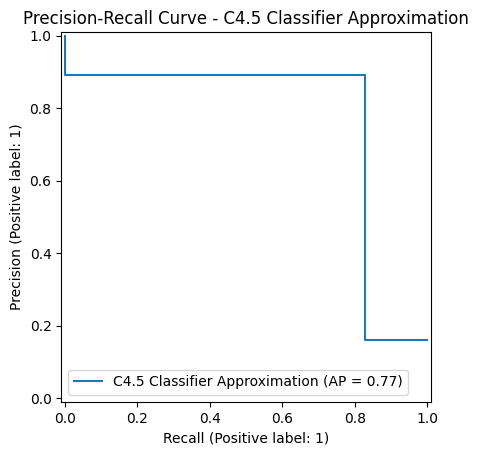

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       517
           1       0.88      0.84      0.86        99

    accuracy                           0.96       616
   macro avg       0.93      0.91      0.92       616
weighted avg       0.96      0.96      0.96       616



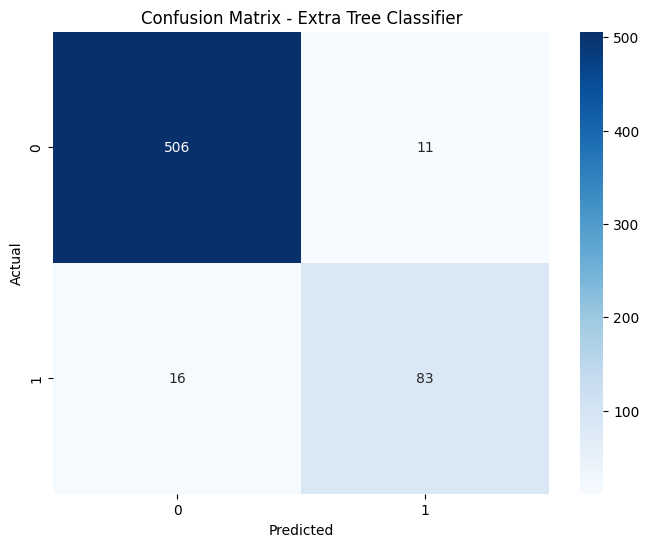

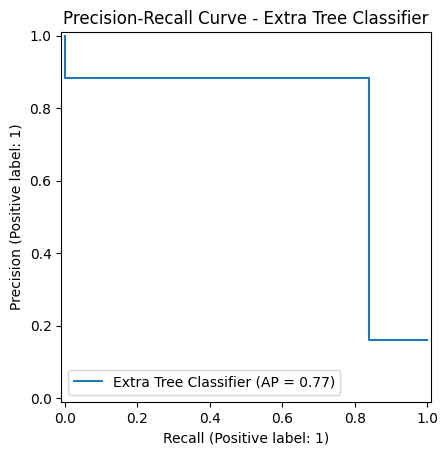

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       517
           1       0.97      0.89      0.93        99

    accuracy                           0.98       616
   macro avg       0.97      0.94      0.96       616
weighted avg       0.98      0.98      0.98       616



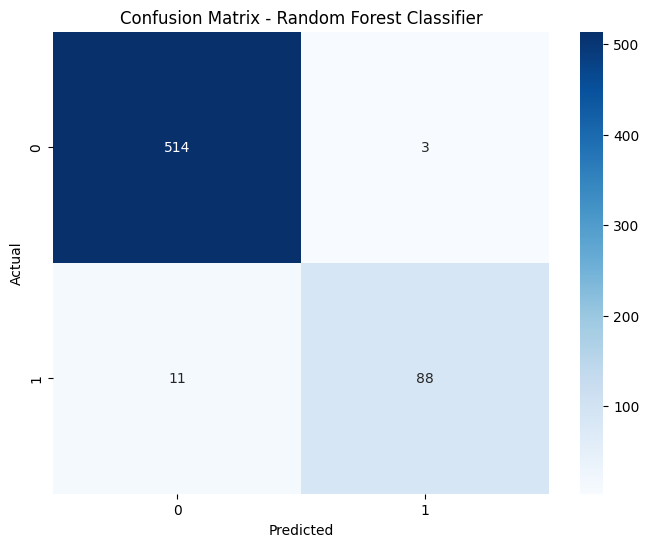

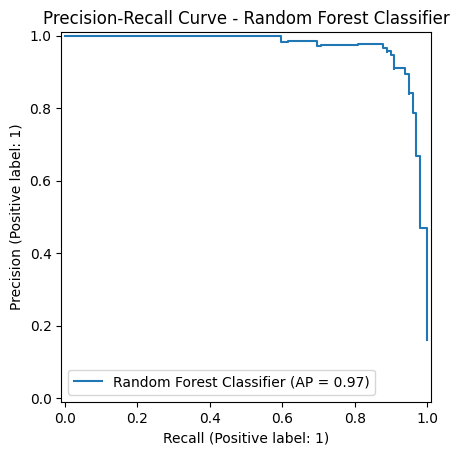

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       517
           1       0.96      0.75      0.84        99

    accuracy                           0.95       616
   macro avg       0.96      0.87      0.91       616
weighted avg       0.95      0.95      0.95       616



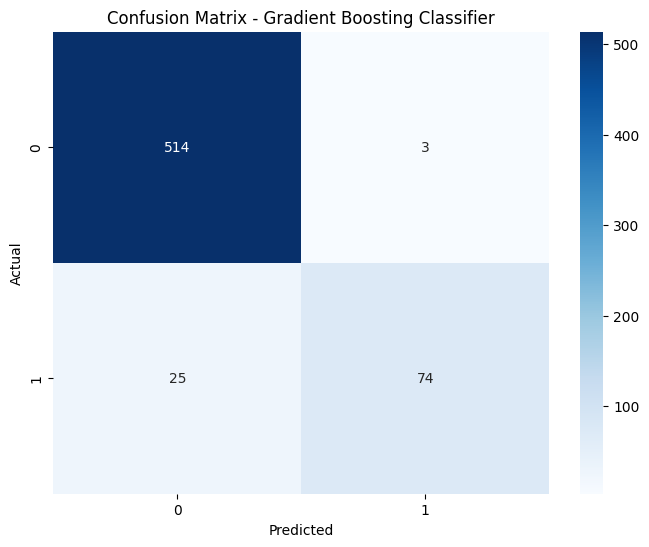

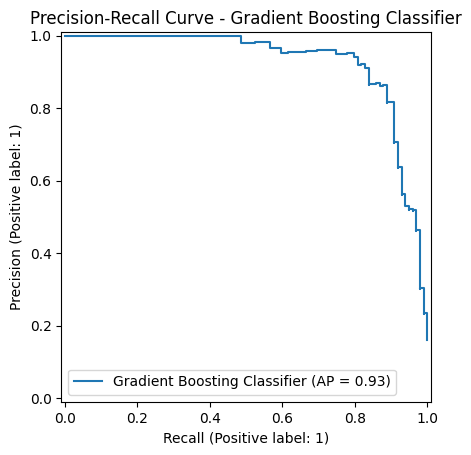

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       517
           1       0.92      0.86      0.89        99

    accuracy                           0.97       616
   macro avg       0.95      0.92      0.93       616
weighted avg       0.97      0.97      0.97       616



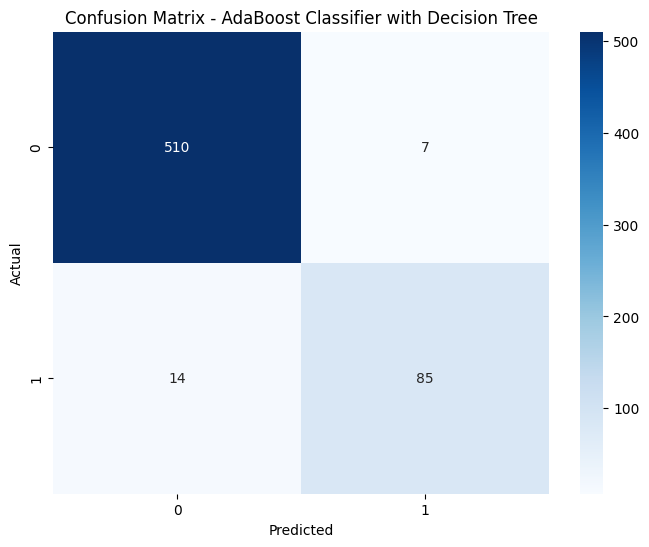

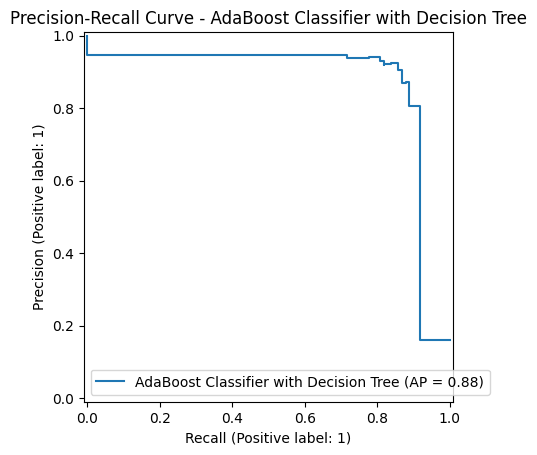

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       517
           1       0.94      0.88      0.91        99

    accuracy                           0.97       616
   macro avg       0.96      0.93      0.94       616
weighted avg       0.97      0.97      0.97       616



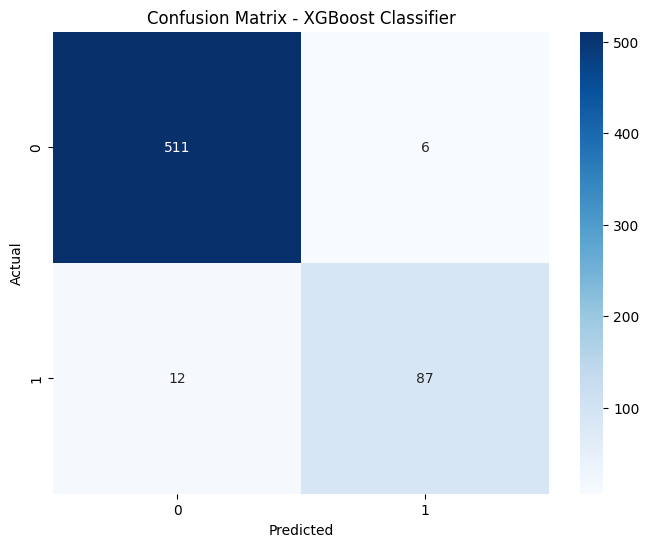

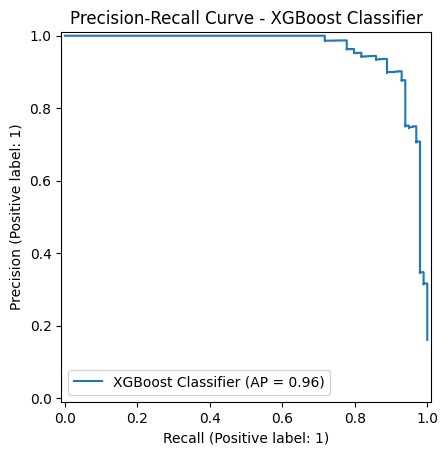

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




In [105]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [106]:
dataset = pd.read_csv('Customer_Churn.csv')


column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]  
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13]


zero_indices_ch0 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 0))].index.tolist()





zero_indices_ch1 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1))].index.tolist()

dataset = dataset.drop(index=zero_indices_ch1)

columns_to_fill = [0, 3, 4, 5, 6, 7, 12]


for col_idx in columns_to_fill:

    col_mean = dataset.iloc[:, col_idx].mean()
    
   
    dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = col_mean




C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\4010709647.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.829260345389377' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = col_mean
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\4010709647.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.967741935483871' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = col_mean
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\4010709647.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4590.501140436624' has dtype incomp

In [107]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (86.5%)
Class 1: 331 (13.5%)

Test set proportions:
Class 0: 531 (86.5%)
Class 1: 83 (13.5%)


Results for CART Classifier (Gini):
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       531
           1       0.77      0.81      0.79        83

    accuracy                           0.94       614
   macro avg       0.87      0.88      0.88       614
weighted avg       0.94      0.94      0.94       614



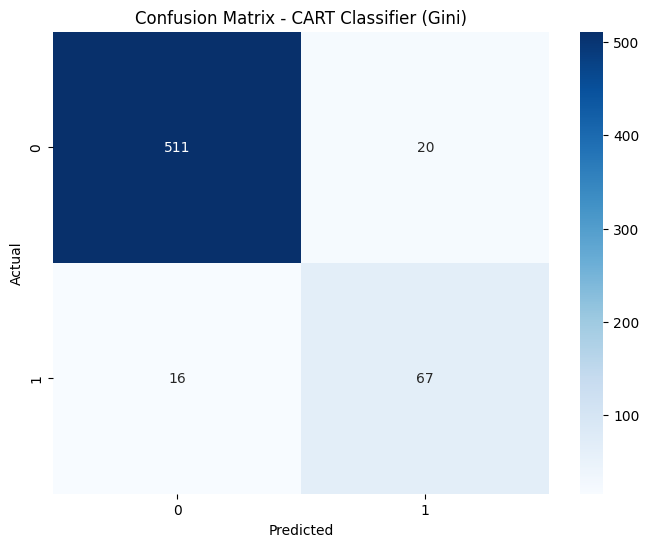

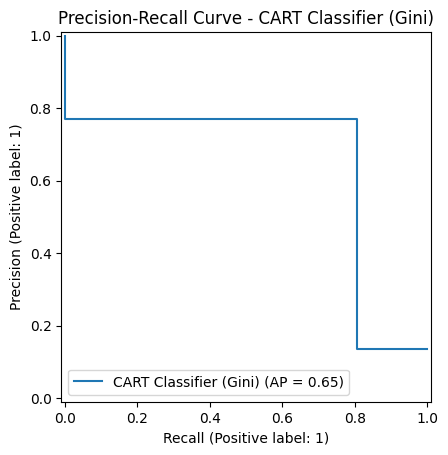

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.85      0.90      0.88        83

    accuracy                           0.97       614
   macro avg       0.92      0.94      0.93       614
weighted avg       0.97      0.97      0.97       614



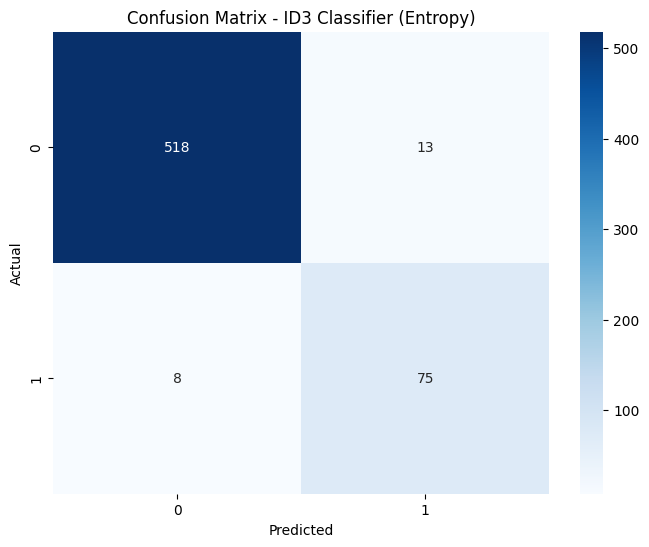

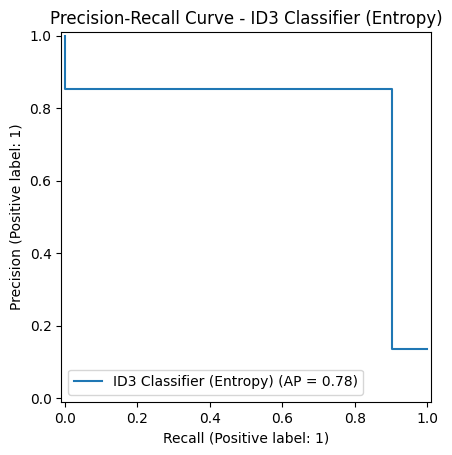

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.85      0.90      0.88        83

    accuracy                           0.97       614
   macro avg       0.92      0.94      0.93       614
weighted avg       0.97      0.97      0.97       614



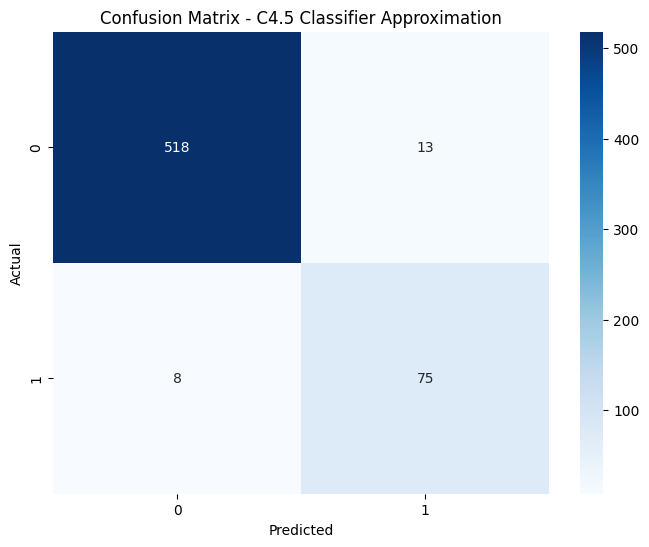

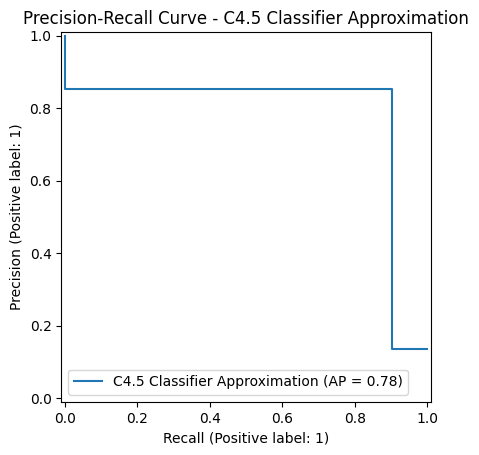

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       531
           1       0.77      0.90      0.83        83

    accuracy                           0.95       614
   macro avg       0.87      0.93      0.90       614
weighted avg       0.95      0.95      0.95       614



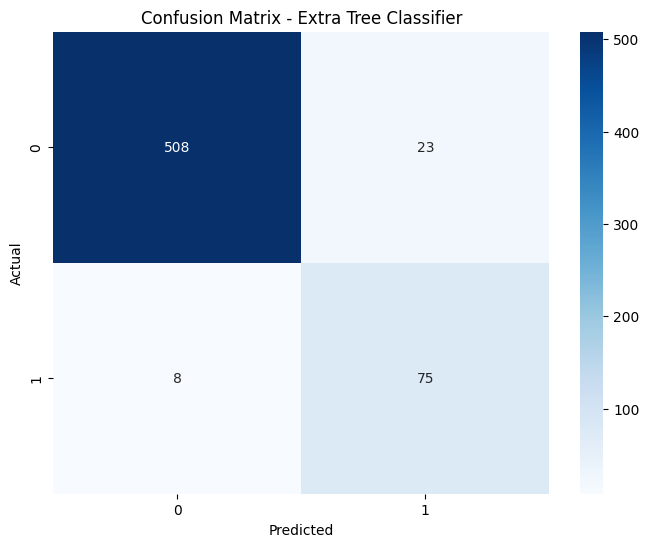

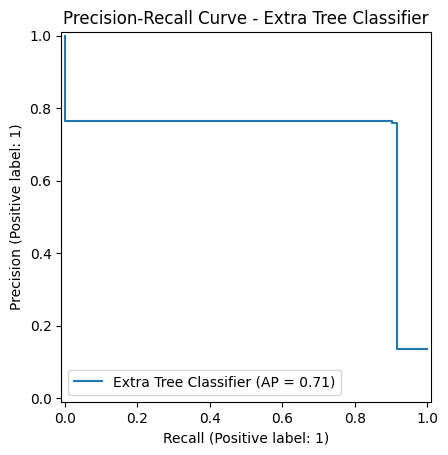

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       531
           1       0.97      0.83      0.90        83

    accuracy                           0.97       614
   macro avg       0.97      0.91      0.94       614
weighted avg       0.97      0.97      0.97       614



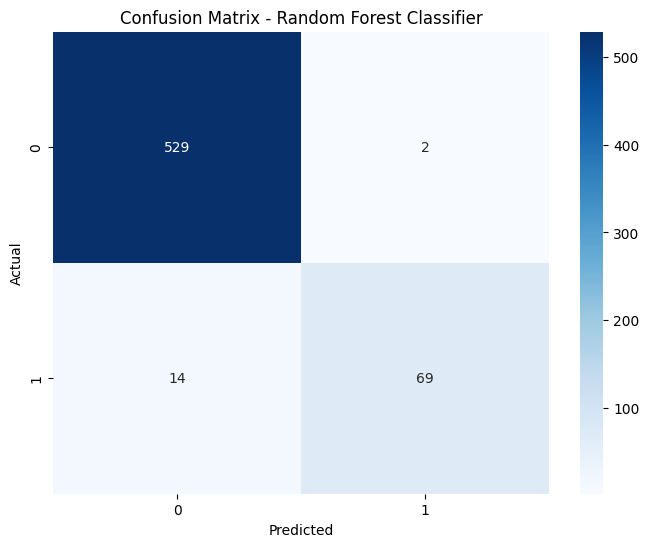

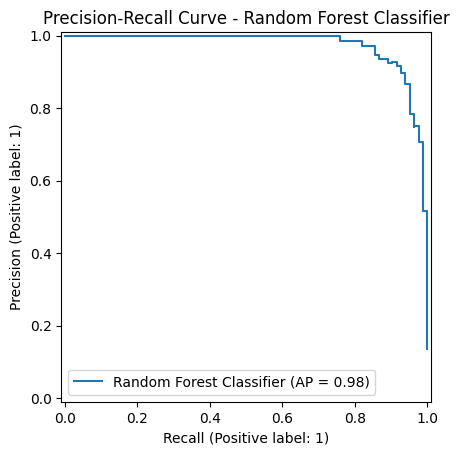

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       531
           1       0.95      0.76      0.85        83

    accuracy                           0.96       614
   macro avg       0.96      0.88      0.91       614
weighted avg       0.96      0.96      0.96       614



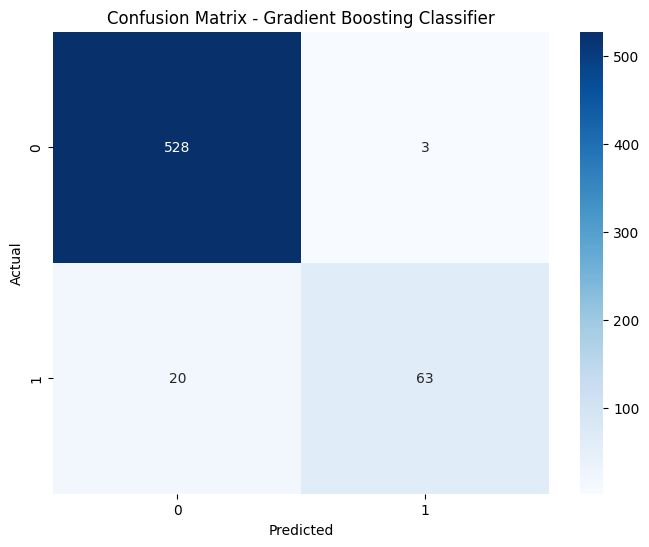

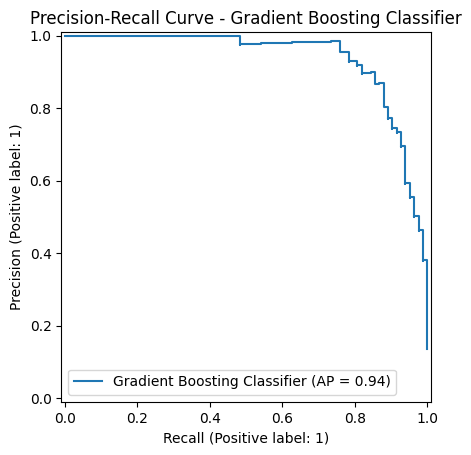

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       531
           1       0.83      0.84      0.84        83

    accuracy                           0.96       614
   macro avg       0.90      0.91      0.91       614
weighted avg       0.96      0.96      0.96       614



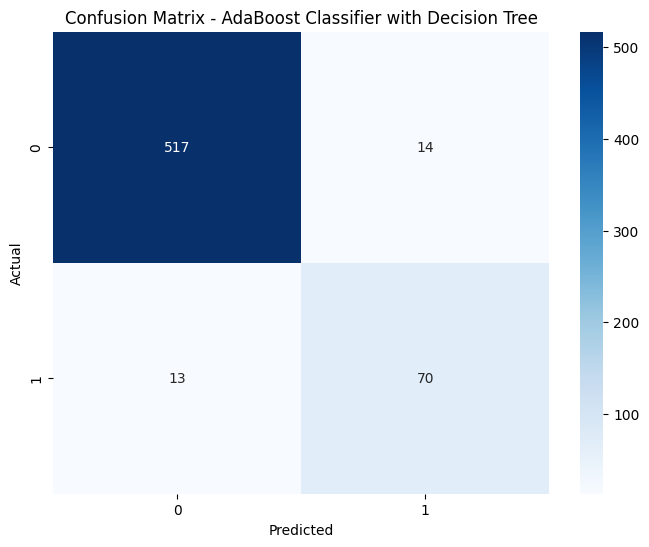

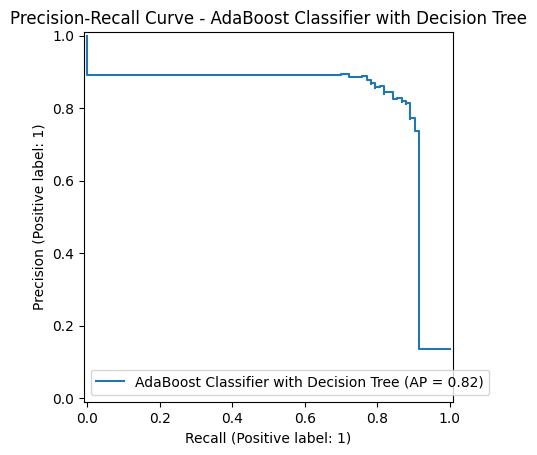

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.96      0.87      0.91        83

    accuracy                           0.98       614
   macro avg       0.97      0.93      0.95       614
weighted avg       0.98      0.98      0.98       614



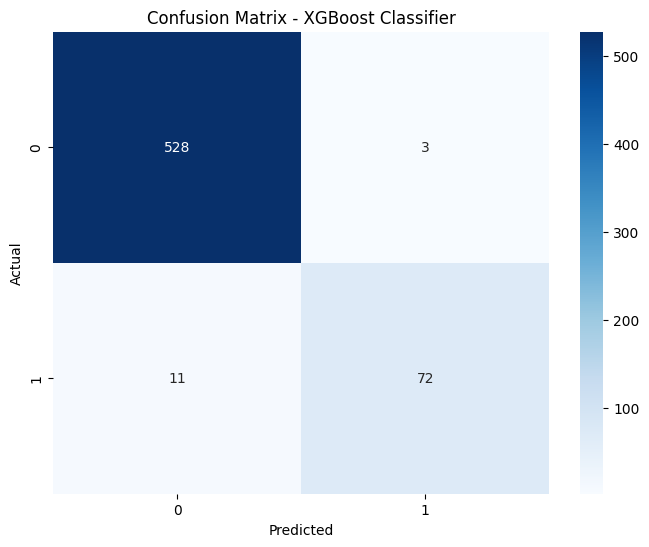

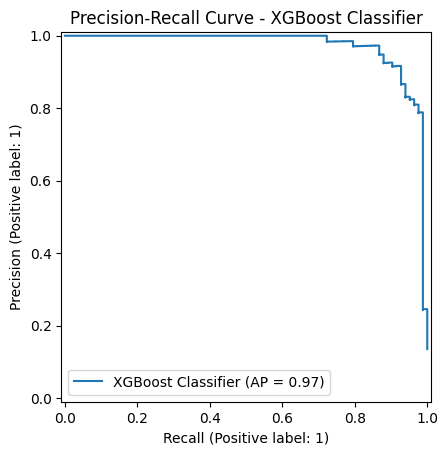

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




In [108]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [109]:
dataset = pd.read_csv('Customer_Churn.csv')


column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]  
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13]


zero_indices_ch0 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 0))].index.tolist()

dataset = dataset.drop(index=zero_indices_ch0)



zero_indices_ch1 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1))].index.tolist()


columns_to_fill = [0, 3, 4, 5, 6, 7, 12]


for col_idx in columns_to_fill:

    col_med = dataset.iloc[:, col_idx].median()
    
   
    dataset.loc[zero_indices_ch1, dataset.columns[col_idx]] = col_med




C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\874344879.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_indices_ch1 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1))].index.tolist()


In [110]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2065 (83.9%)
Class 1: 396 (16.1%)

Test set proportions:
Class 0: 517 (83.9%)
Class 1: 99 (16.1%)


Results for CART Classifier (Gini):
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       517
           1       0.88      0.81      0.84        99

    accuracy                           0.95       616
   macro avg       0.92      0.89      0.91       616
weighted avg       0.95      0.95      0.95       616



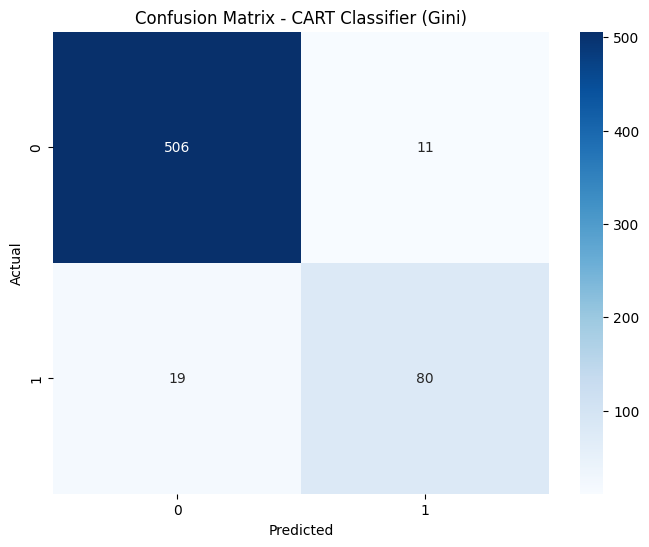

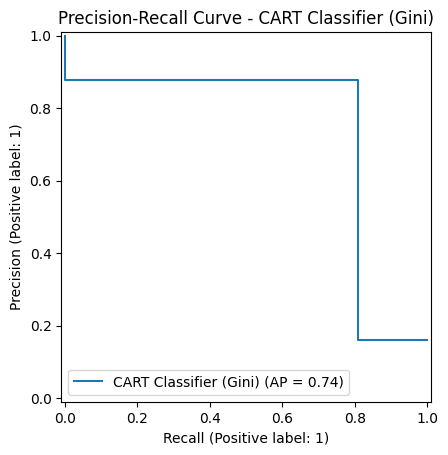

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       517
           1       0.89      0.81      0.85        99

    accuracy                           0.95       616
   macro avg       0.93      0.89      0.91       616
weighted avg       0.95      0.95      0.95       616



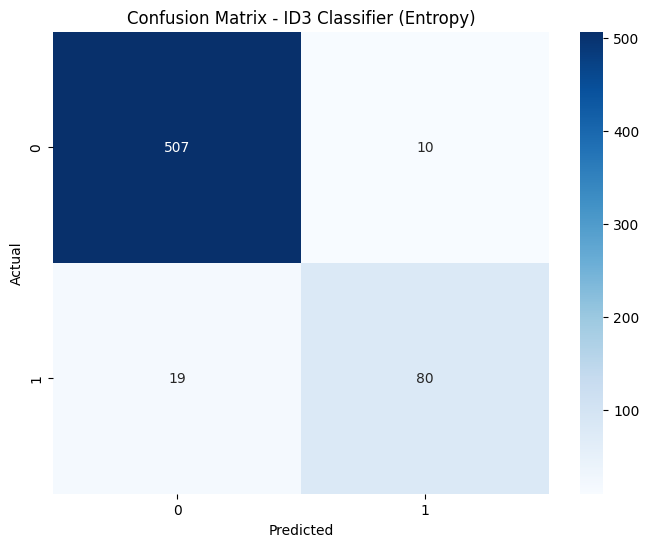

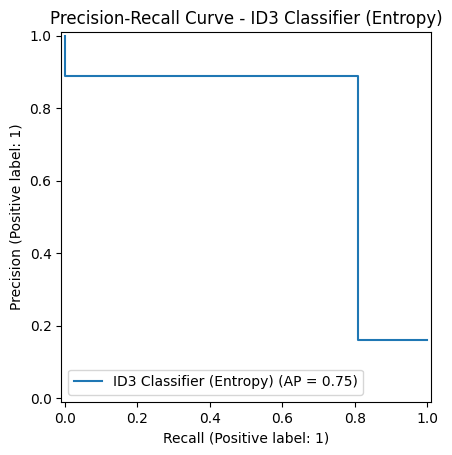

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       517
           1       0.89      0.81      0.85        99

    accuracy                           0.95       616
   macro avg       0.93      0.89      0.91       616
weighted avg       0.95      0.95      0.95       616



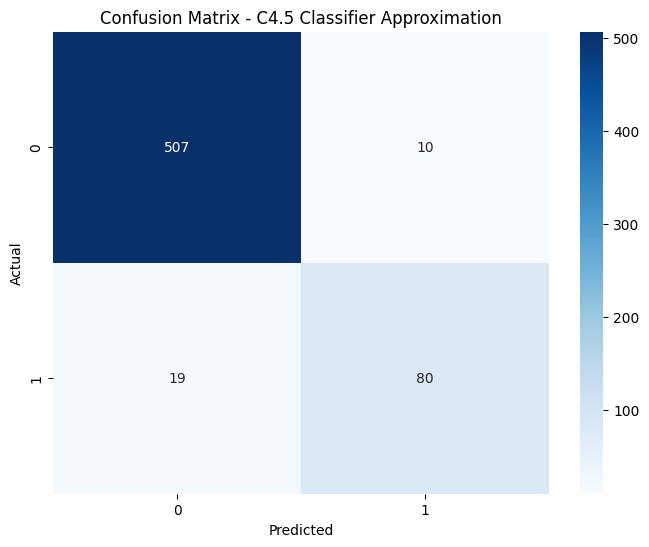

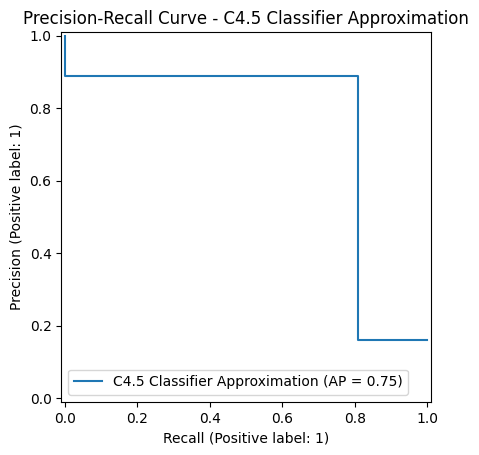

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       517
           1       0.84      0.85      0.84        99

    accuracy                           0.95       616
   macro avg       0.91      0.91      0.91       616
weighted avg       0.95      0.95      0.95       616



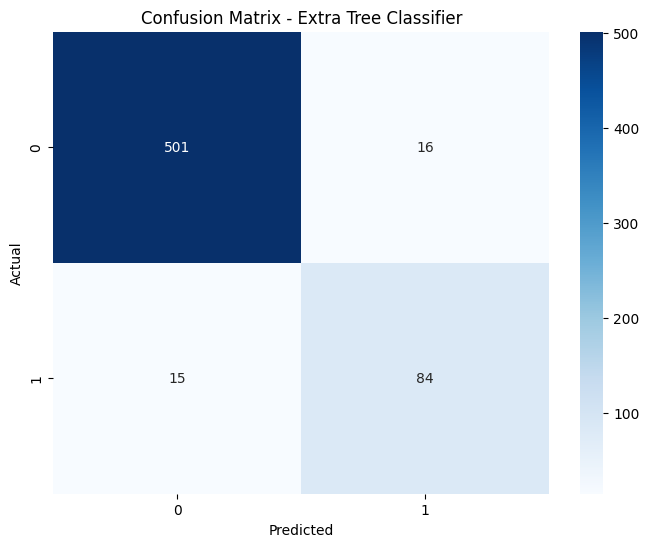

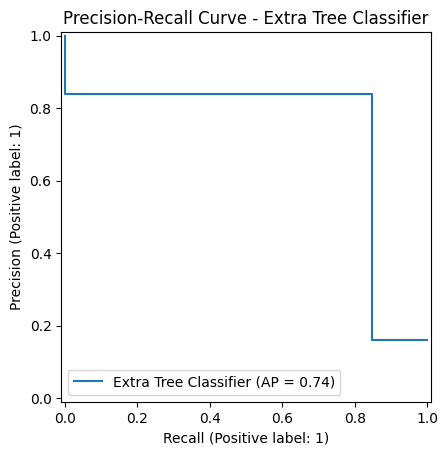

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       517
           1       0.96      0.86      0.90        99

    accuracy                           0.97       616
   macro avg       0.96      0.93      0.94       616
weighted avg       0.97      0.97      0.97       616



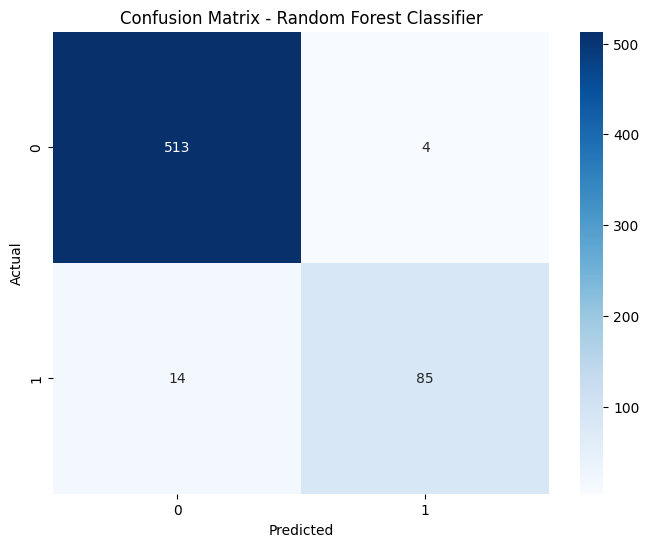

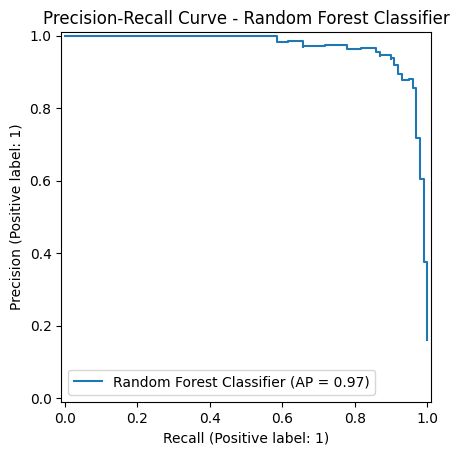

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       517
           1       0.95      0.76      0.84        99

    accuracy                           0.95       616
   macro avg       0.95      0.87      0.91       616
weighted avg       0.95      0.95      0.95       616



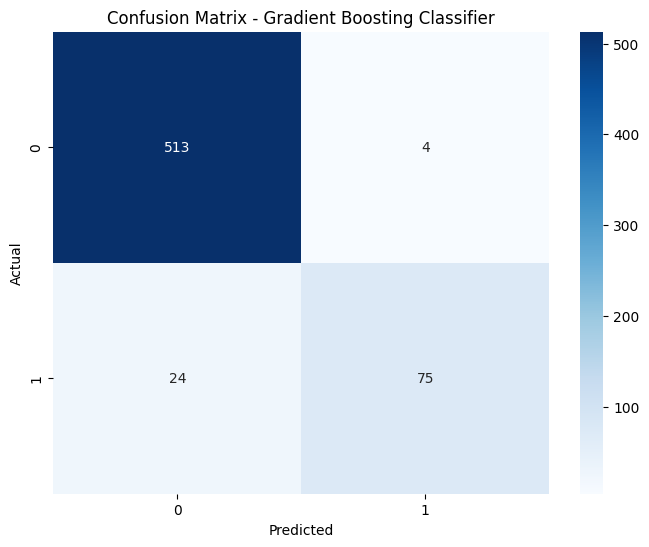

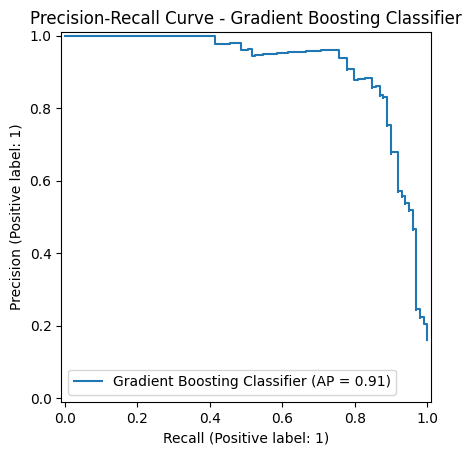

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       517
           1       0.89      0.83      0.86        99

    accuracy                           0.96       616
   macro avg       0.93      0.90      0.92       616
weighted avg       0.96      0.96      0.96       616



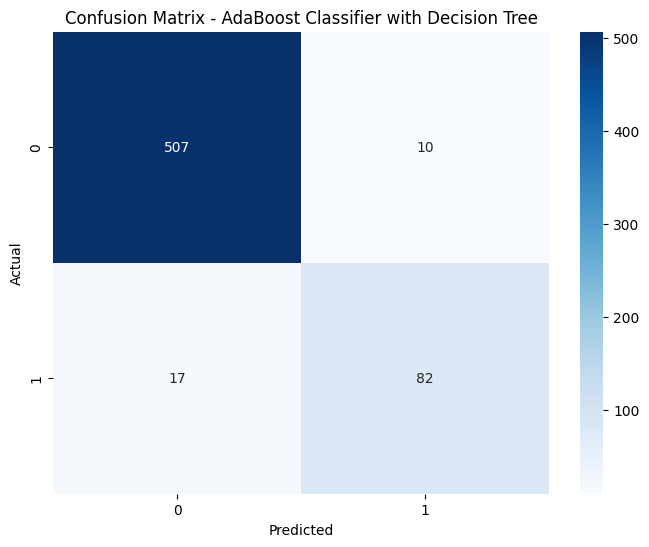

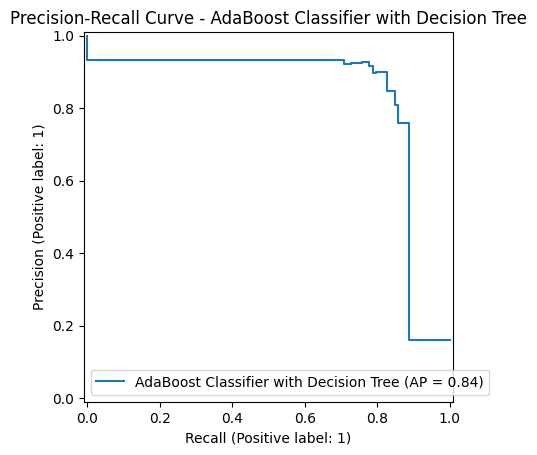

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       517
           1       0.96      0.91      0.93        99

    accuracy                           0.98       616
   macro avg       0.97      0.95      0.96       616
weighted avg       0.98      0.98      0.98       616



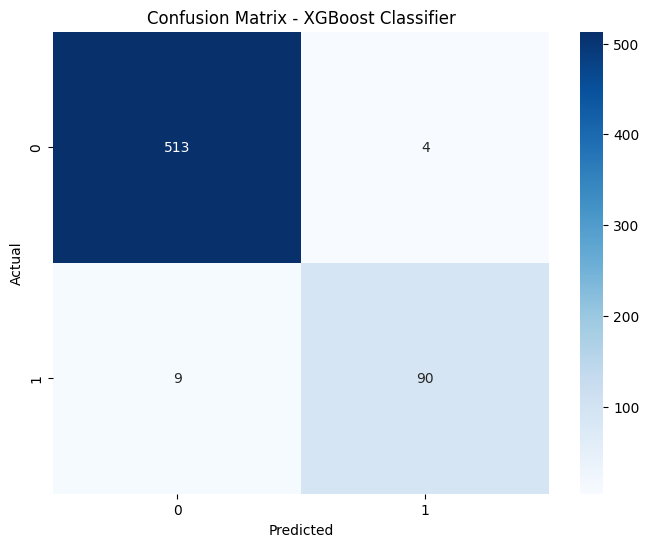

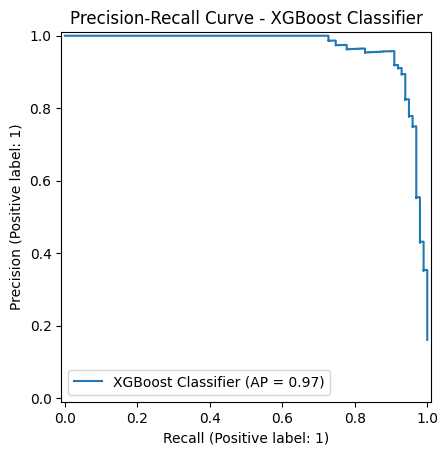

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




In [111]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [114]:
dataset = pd.read_csv('Customer_Churn.csv')


column_0 = dataset.iloc[:, 0]
column_4 = dataset.iloc[:, 4]  
column_5 = dataset.iloc[:, 5]
column_13 = dataset.iloc[:, 13]


zero_indices_ch0 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 0))].index.tolist()




zero_indices_ch1 = dataset[((column_0 == 0) & (column_4 == 0) & (column_5 == 0) & (column_13 == 1))].index.tolist()

dataset = dataset.drop(index=zero_indices_ch1)

columns_to_fill = [0, 3, 4, 5, 6, 7, 12]


for col_idx in columns_to_fill:

    col_med = dataset.iloc[:, col_idx].median()
    
   
    dataset.loc[zero_indices_ch0, dataset.columns[col_idx]] = col_med




In [115]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (86.5%)
Class 1: 331 (13.5%)

Test set proportions:
Class 0: 531 (86.5%)
Class 1: 83 (13.5%)


Results for CART Classifier (Gini):
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.84      0.82      0.83        83

    accuracy                           0.95       614
   macro avg       0.91      0.90      0.90       614
weighted avg       0.95      0.95      0.95       614



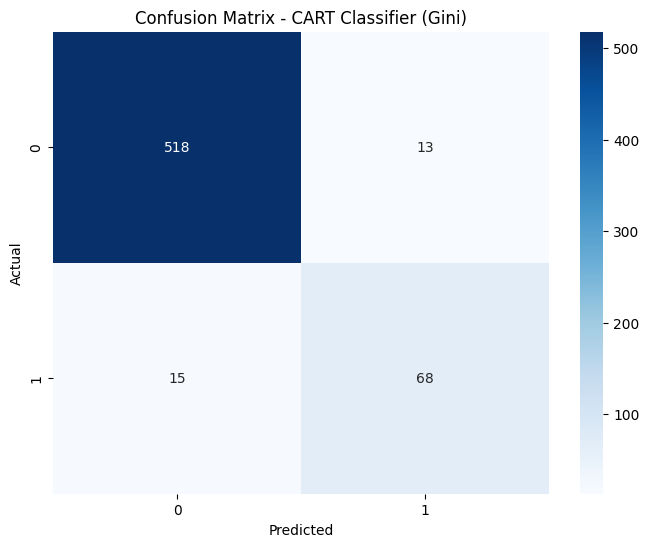

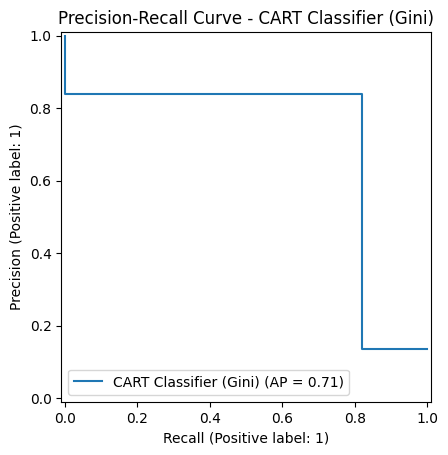

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.88      0.90      0.89        83

    accuracy                           0.97       614
   macro avg       0.93      0.94      0.94       614
weighted avg       0.97      0.97      0.97       614



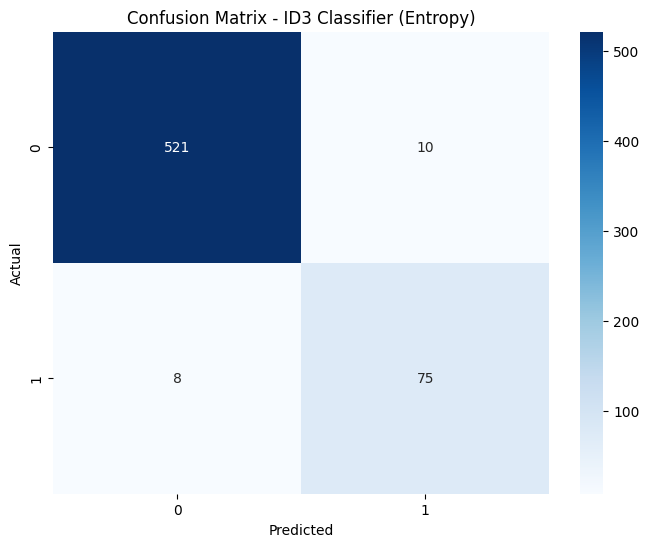

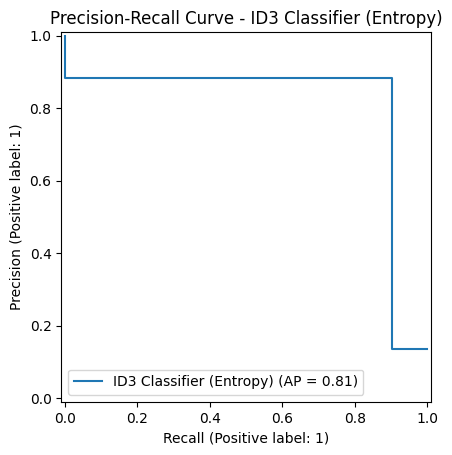

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.88      0.90      0.89        83

    accuracy                           0.97       614
   macro avg       0.93      0.94      0.94       614
weighted avg       0.97      0.97      0.97       614



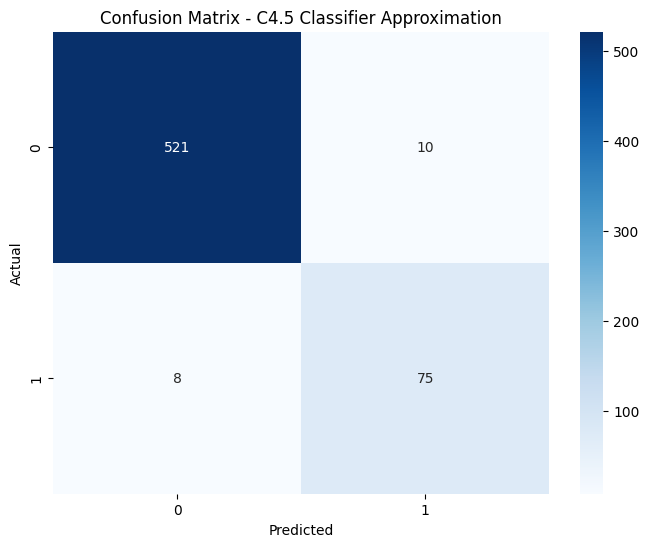

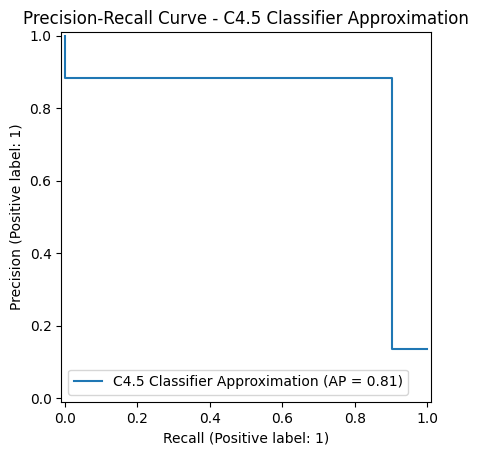

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       531
           1       0.77      0.90      0.83        83

    accuracy                           0.95       614
   macro avg       0.87      0.93      0.90       614
weighted avg       0.95      0.95      0.95       614



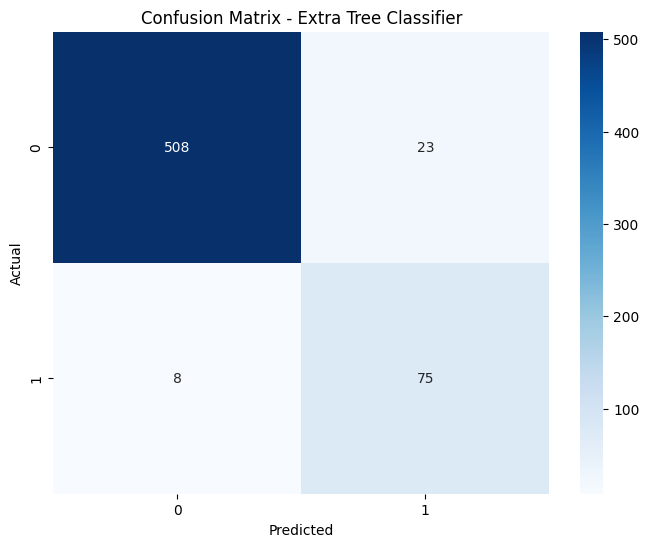

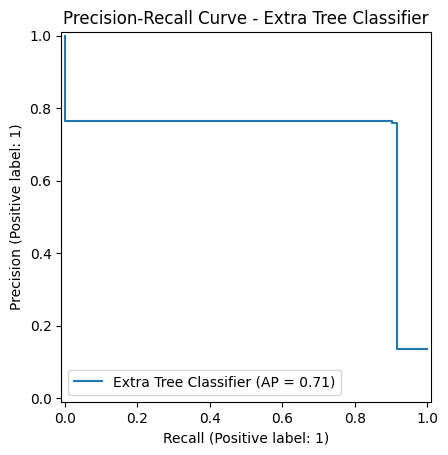

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       531
           1       0.99      0.83      0.90        83

    accuracy                           0.98       614
   macro avg       0.98      0.91      0.94       614
weighted avg       0.98      0.98      0.97       614



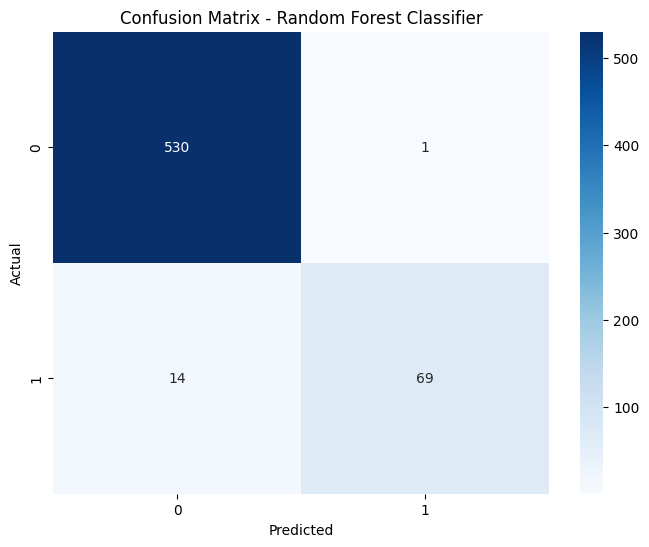

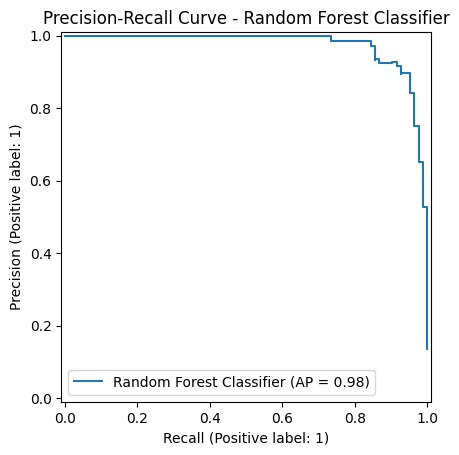

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       531
           1       0.97      0.76      0.85        83

    accuracy                           0.96       614
   macro avg       0.97      0.88      0.92       614
weighted avg       0.96      0.96      0.96       614



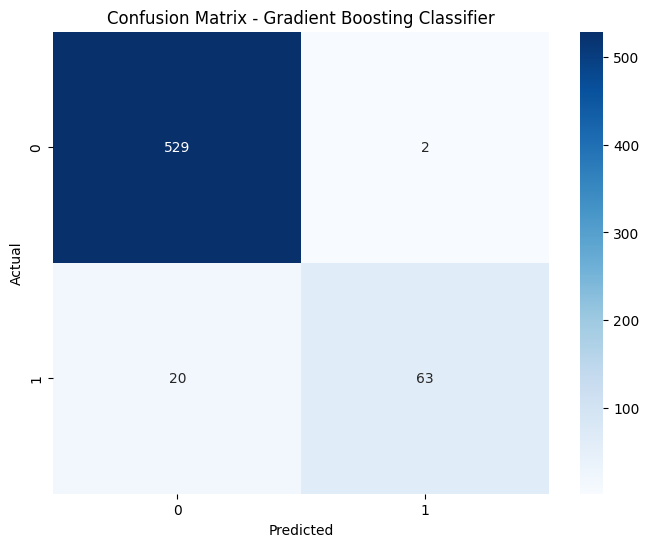

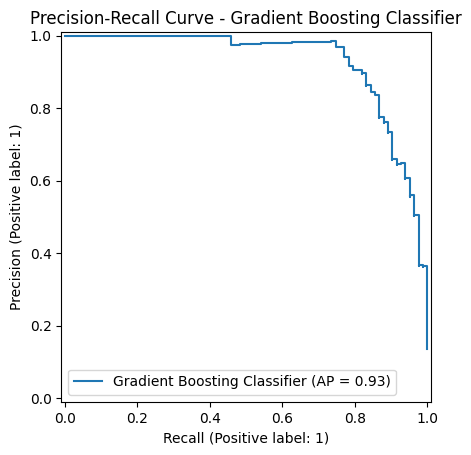

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       531
           1       0.81      0.82      0.81        83

    accuracy                           0.95       614
   macro avg       0.89      0.89      0.89       614
weighted avg       0.95      0.95      0.95       614



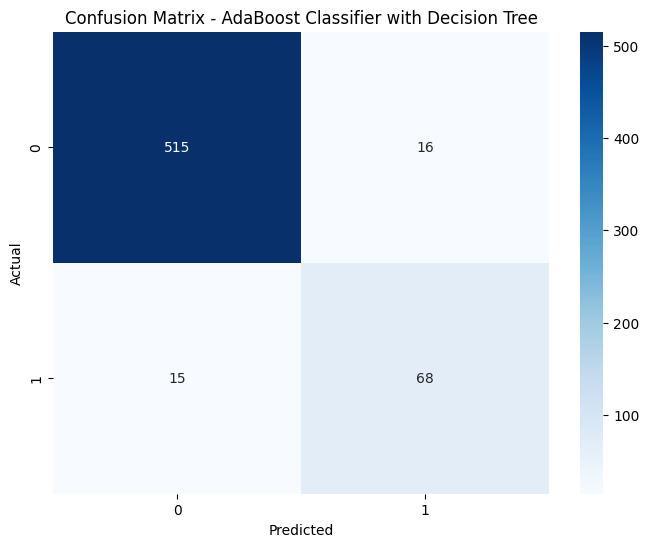

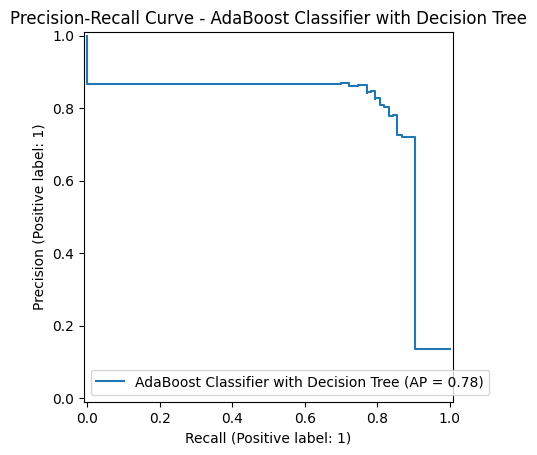

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.97      0.87      0.92        83

    accuracy                           0.98       614
   macro avg       0.98      0.93      0.95       614
weighted avg       0.98      0.98      0.98       614



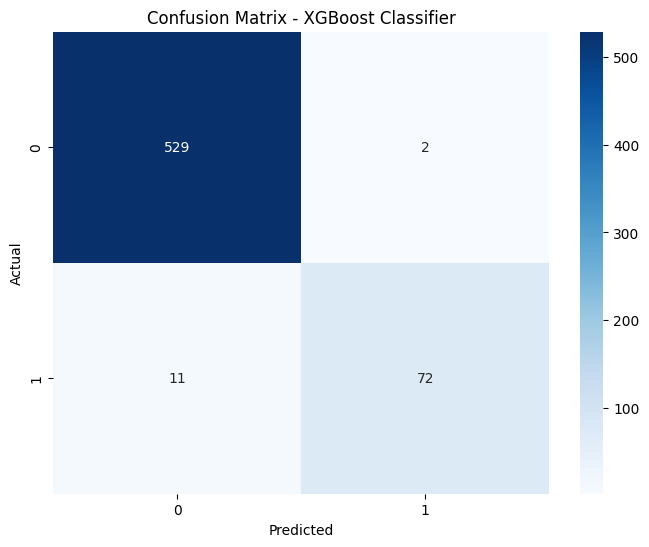

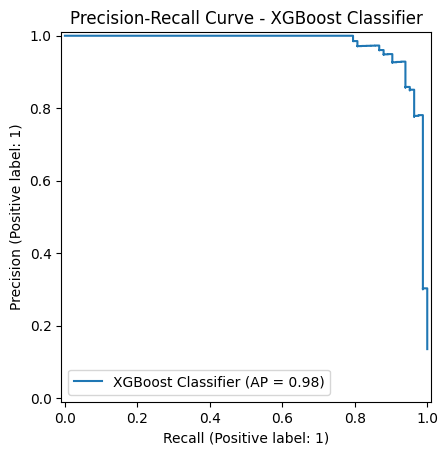

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]




In [116]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


dataset = pd.read_csv("Customer_Churn.csv")


df_cluster = dataset.copy()


scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)


best_k = None
best_score = -1.0


for k in range(2, 10):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    cluster_labels_tmp = kmeans_tmp.fit_predict(df_cluster_scaled)
    sil_score = silhouette_score(df_cluster_scaled, cluster_labels_tmp)
    print(f"  k = {k}, silhouette = {sil_score:.4f}")
    
    if sil_score > best_score:
        best_score = sil_score
        best_k = k

print(f"\nBest k based on silhouette score: {best_k} (score = {best_score:.4f})")


kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)


df_cluster["cluster"] = cluster_labels


cluster_means = df_cluster.groupby("cluster").mean()


cols_must_be_zero = [0, 3, 4, 5, 6, 7, 12]
col_names_must_be_zero = dataset.columns[cols_must_be_zero]


all_zeros_mask = np.all(df_cluster[col_names_must_be_zero] == 0, axis=1)

print(f"\nNumber of records where all specified columns are zero: {all_zeros_mask.sum()}")

# Perform imputation only on records where ALL specified columns are zero
for cluster_id in range(best_k):
    # Rows that belong to this cluster AND have all zeros
    cluster_mask = (df_cluster["cluster"] == cluster_id) & all_zeros_mask
    
    # Only proceed if there are any rows meeting our criteria in this cluster
    if cluster_mask.any():
        for col_name in col_names_must_be_zero:
            # Mean for this column in this cluster
            cluster_col_mean = cluster_means.loc[cluster_id, col_name]
            
            # Replace values for rows that meet our criteria
            df_cluster.loc[cluster_mask, col_name] = cluster_col_mean

# Update the original dataset
for col_idx in cols_must_be_zero:
    col_name = dataset.columns[col_idx]
    dataset[col_name] = df_cluster[col_name]

# Save the updated dataset
dataset.to_csv("Customer_Churn_Modified.csv", index=False)
print("\nImputation completed. Only records with ALL zeros in specified columns were imputed.")
print("Updated dataset saved as 'Customer_Churn_ClusterImputed_AllZeros.csv'")

# Print summary of changes
print("\nSummary of imputation:")
print(f"Total records processed: {len(dataset)}")
print(f"Records modified: {all_zeros_mask.sum()}")
print("Modified columns:", list(col_names_must_be_zero))

  k = 2, silhouette = 0.2108
  k = 3, silhouette = 0.2221
  k = 4, silhouette = 0.1920
  k = 5, silhouette = 0.2150
  k = 6, silhouette = 0.2455
  k = 7, silhouette = 0.2514
  k = 8, silhouette = 0.2720
  k = 9, silhouette = 0.2738

Best k based on silhouette score: 9 (score = 0.2738)

Number of records where all specified columns are zero: 130

Imputation completed. Only records with ALL zeros in specified columns were imputed.
Updated dataset saved as 'Customer_Churn_ClusterImputed_AllZeros.csv'

Summary of imputation:
Total records processed: 3150
Records modified: 130
Modified columns: ['Call  Failure', 'Charge  Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12520\2261655055.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.404938271604938' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[cluster_mask, col_name] = cluster_col_mean
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12520\2261655055.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '949.5432098765432' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[cluster_mask, col_name] = cluster_col_mean
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12520\2261655055.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.720987654320986' has dtype incompatible with int64

In [5]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (84.3%)
Class 1: 396 (15.7%)

Test set proportions:
Class 0: 531 (84.3%)
Class 1: 99 (15.7%)


Results for CART Classifier (Gini):
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       531
           1       0.93      0.85      0.89        99

    accuracy                           0.97       630
   macro avg       0.95      0.92      0.93       630
weighted avg       0.97      0.97      0.97       630



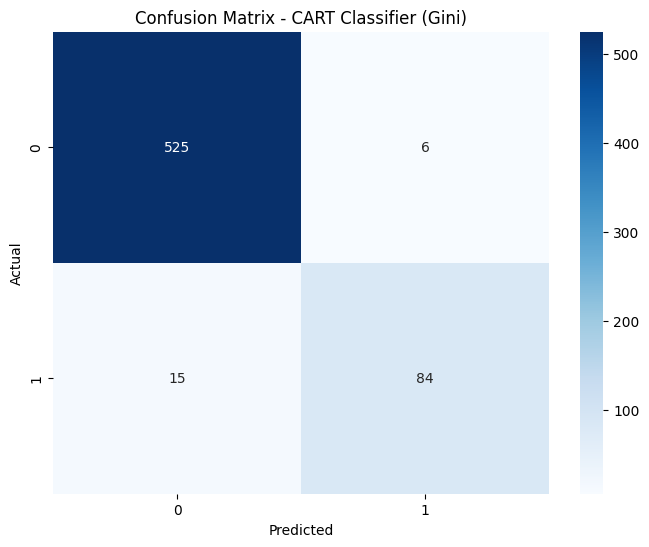

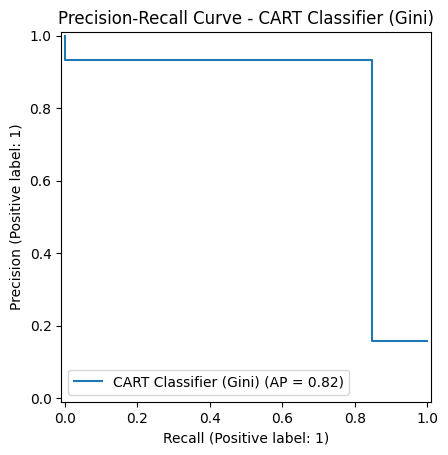

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       531
           1       0.84      0.88      0.86        99

    accuracy                           0.96       630
   macro avg       0.91      0.92      0.92       630
weighted avg       0.96      0.96      0.96       630



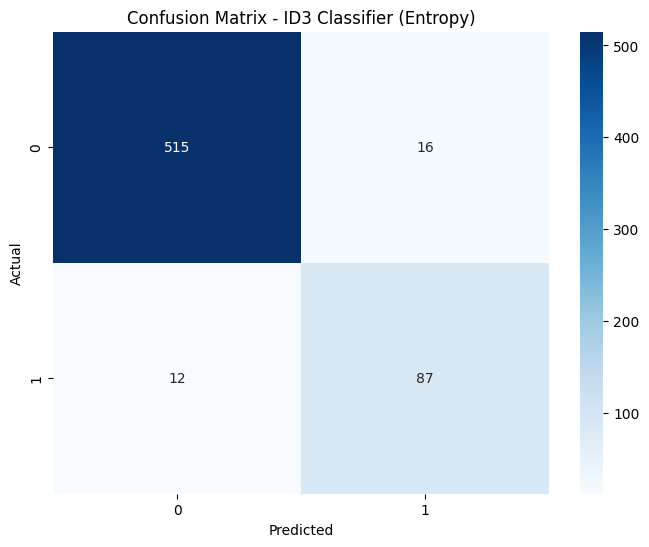

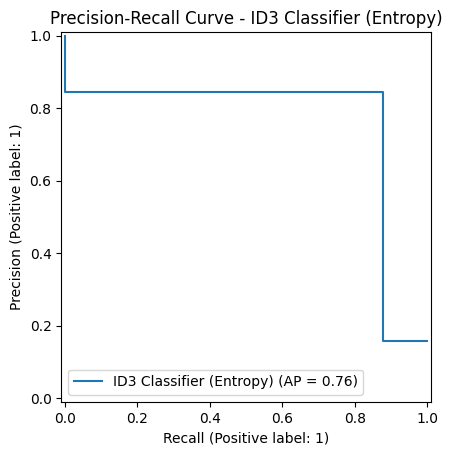

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       531
           1       0.84      0.88      0.86        99

    accuracy                           0.96       630
   macro avg       0.91      0.92      0.92       630
weighted avg       0.96      0.96      0.96       630



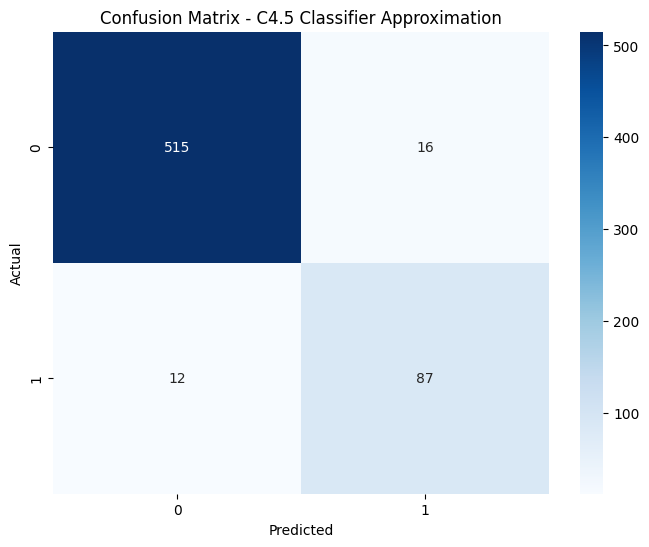

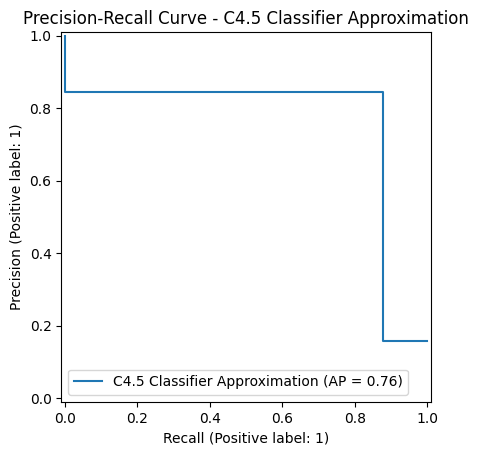

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.89      0.83      0.86        99

    accuracy                           0.96       630
   macro avg       0.93      0.90      0.92       630
weighted avg       0.96      0.96      0.96       630



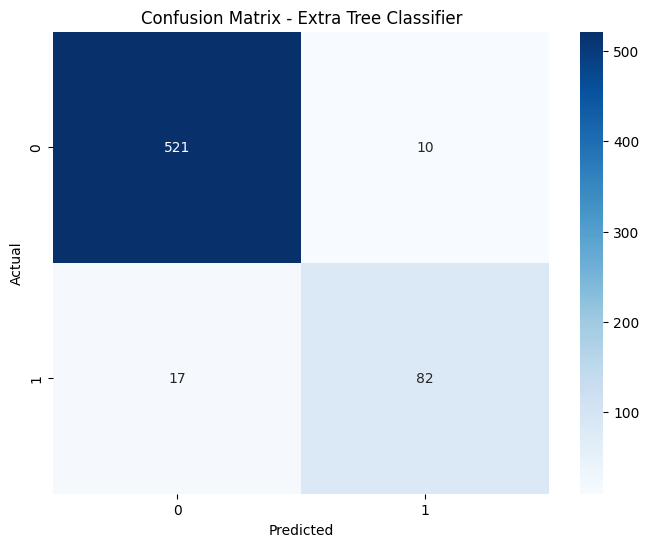

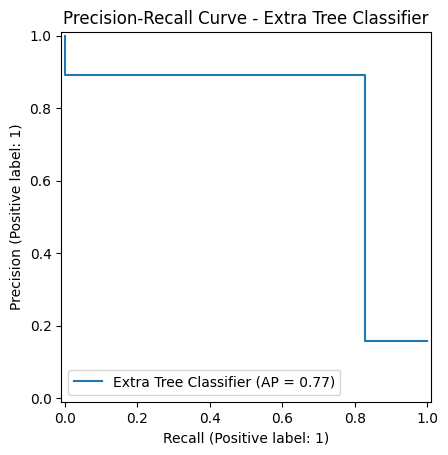

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.99      0.88      0.93        99

    accuracy                           0.98       630
   macro avg       0.98      0.94      0.96       630
weighted avg       0.98      0.98      0.98       630



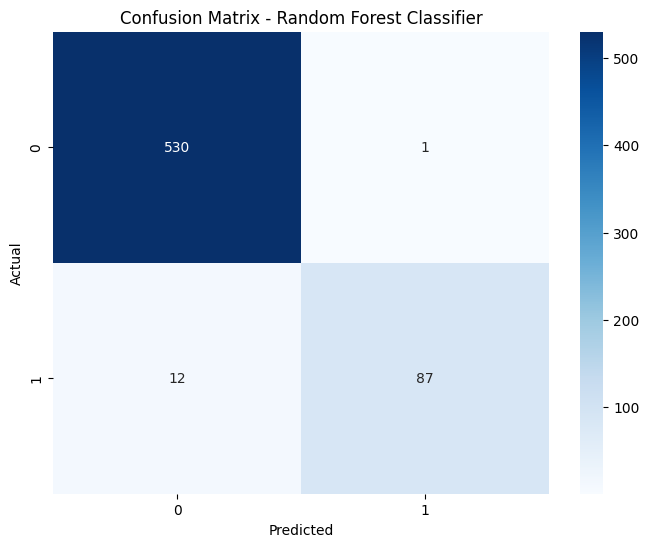

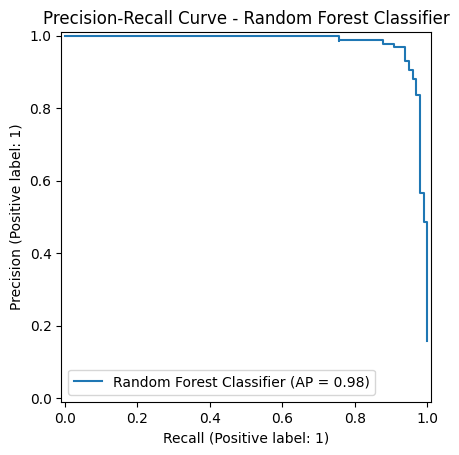

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       531
           1       0.94      0.75      0.83        99

    accuracy                           0.95       630
   macro avg       0.95      0.87      0.90       630
weighted avg       0.95      0.95      0.95       630



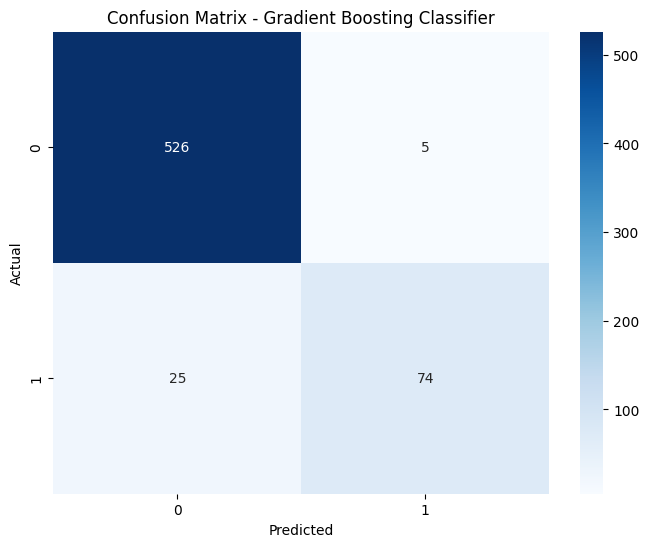

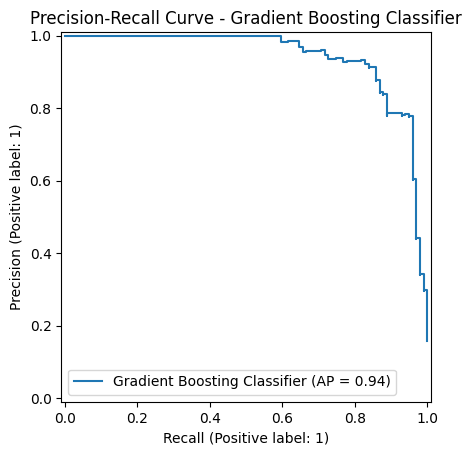

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.88      0.85      0.86        99

    accuracy                           0.96       630
   macro avg       0.92      0.91      0.92       630
weighted avg       0.96      0.96      0.96       630



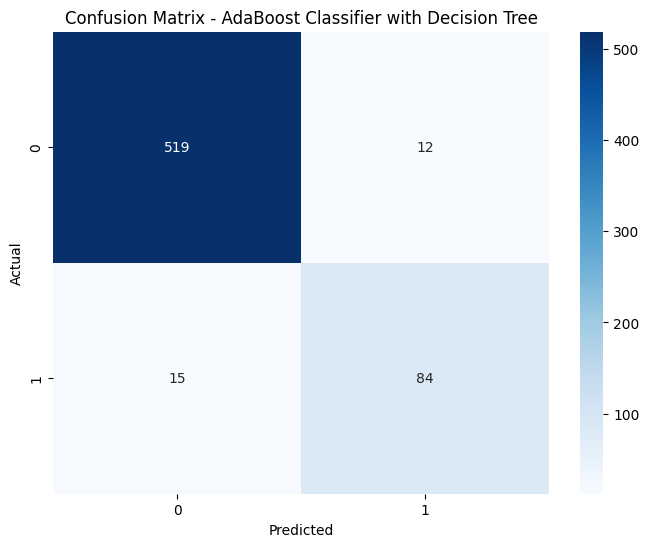

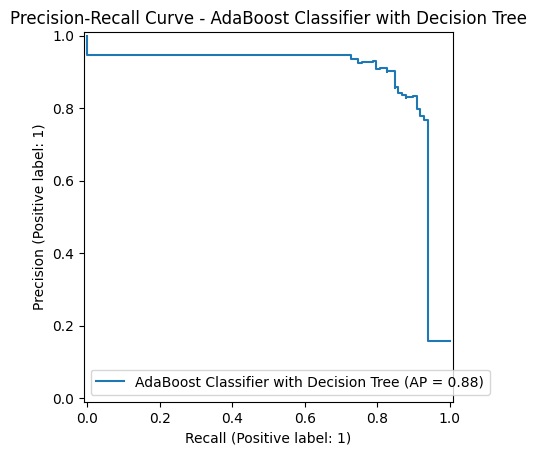

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       531
           1       0.95      0.93      0.94        99

    accuracy                           0.98       630
   macro avg       0.97      0.96      0.96       630
weighted avg       0.98      0.98      0.98       630



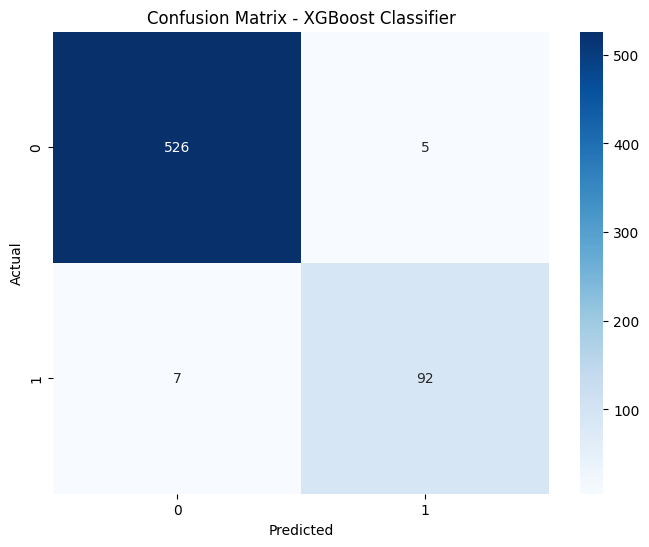

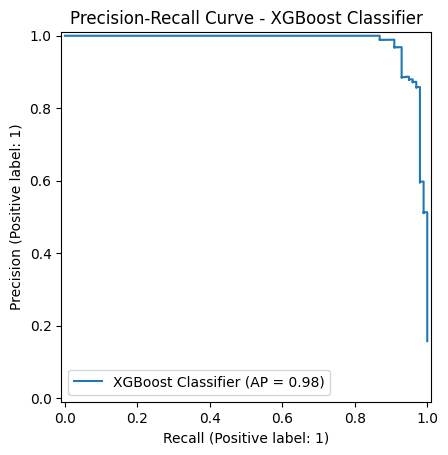

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




In [6]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [151]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the dataset
dataset = pd.read_csv("Customer_Churn.csv")

# Create a copy for clustering
df_cluster = dataset.copy()

# Scale the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Find the best number of clusters
best_k = None
best_score = -1.0

for k in range(2, 10):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    cluster_labels_tmp = kmeans_tmp.fit_predict(df_cluster_scaled)
    sil_score = silhouette_score(df_cluster_scaled, cluster_labels_tmp)
    print(f"  k = {k}, silhouette = {sil_score:.4f}")
    
    if sil_score > best_score:
        best_score = sil_score
        best_k = k

print(f"\nBest k based on silhouette score: {best_k} (score = {best_score:.4f})")

# Fit K-Means with the best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)

# Add cluster labels
df_cluster["cluster"] = cluster_labels

# Compute cluster medians
cluster_medians = df_cluster.groupby("cluster").median()

# Specify columns that must ALL be zero for imputation
cols_must_be_zero = [0, 3, 4, 5, 6, 7, 12]
col_names_must_be_zero = dataset.columns[cols_must_be_zero]

# Create a mask for rows where ALL specified columns are zero
all_zeros_mask = np.all(df_cluster[col_names_must_be_zero] == 0, axis=1)

print(f"\nNumber of records where all specified columns are zero: {all_zeros_mask.sum()}")

# Perform imputation only on records where ALL specified columns are zero
for cluster_id in range(best_k):
    # Rows that belong to this cluster AND have all zeros
    cluster_mask = (df_cluster["cluster"] == cluster_id) & all_zeros_mask
    
    # Only proceed if there are any rows meeting our criteria in this cluster
    if cluster_mask.any():
        for col_name in col_names_must_be_zero:
            # Median for this column in this cluster
            cluster_col_median = cluster_medians.loc[cluster_id, col_name]
            
            # Replace values for rows that meet our criteria
            df_cluster.loc[cluster_mask, col_name] = cluster_col_median

# Update the original dataset
for col_idx in cols_must_be_zero:
    col_name = dataset.columns[col_idx]
    dataset[col_name] = df_cluster[col_name]



# Print summary of changes
print("\nSummary of imputation:")
print(f"Total records processed: {len(dataset)}")
print(f"Records modified: {all_zeros_mask.sum()}")
print("Modified columns:", list(col_names_must_be_zero))


  k = 2, silhouette = 0.2108
  k = 3, silhouette = 0.2221
  k = 4, silhouette = 0.1920
  k = 5, silhouette = 0.2150
  k = 6, silhouette = 0.2455
  k = 7, silhouette = 0.2514
  k = 8, silhouette = 0.2720
  k = 9, silhouette = 0.2738

Best k based on silhouette score: 9 (score = 0.2738)

Number of records where all specified columns are zero: 130

Summary of imputation:
Total records processed: 3150
Records modified: 130
Modified columns: ['Call  Failure', 'Charge  Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\30726449.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1966.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[cluster_mask, col_name] = cluster_col_median


In [152]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (84.3%)
Class 1: 396 (15.7%)

Test set proportions:
Class 0: 531 (84.3%)
Class 1: 99 (15.7%)


Results for CART Classifier (Gini):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       531
           1       0.88      0.85      0.87        99

    accuracy                           0.96       630
   macro avg       0.93      0.91      0.92       630
weighted avg       0.96      0.96      0.96       630



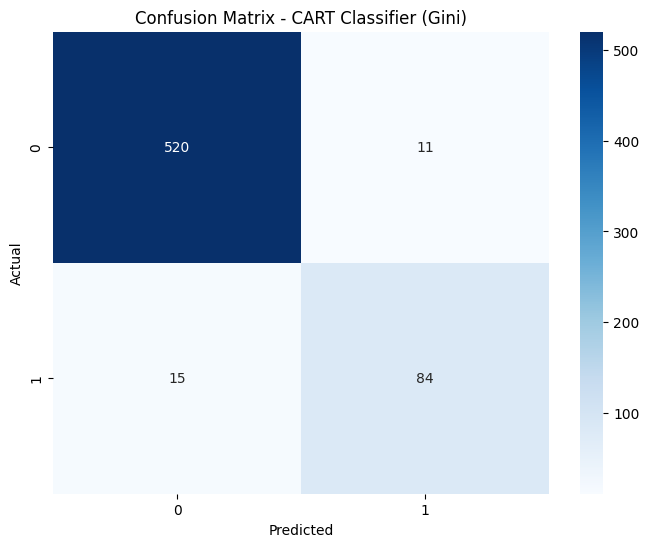

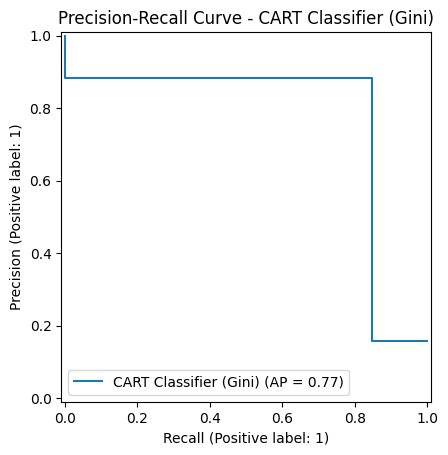

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.88      0.89      0.88        99

    accuracy                           0.96       630
   macro avg       0.93      0.93      0.93       630
weighted avg       0.96      0.96      0.96       630



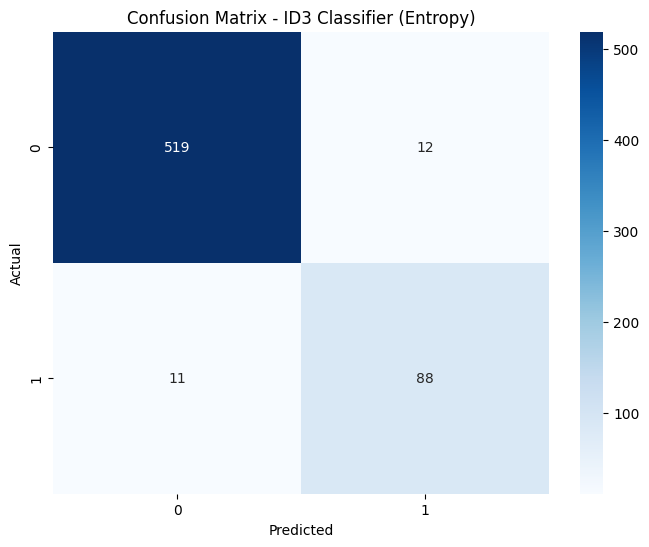

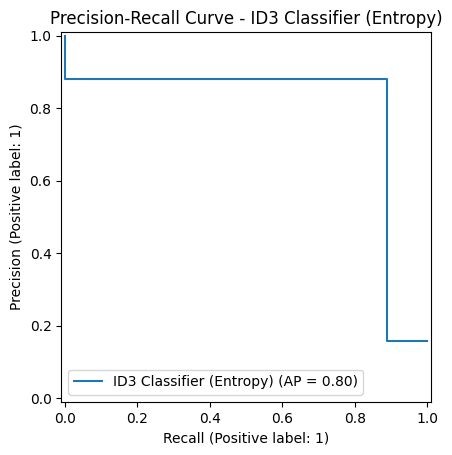

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.88      0.89      0.88        99

    accuracy                           0.96       630
   macro avg       0.93      0.93      0.93       630
weighted avg       0.96      0.96      0.96       630



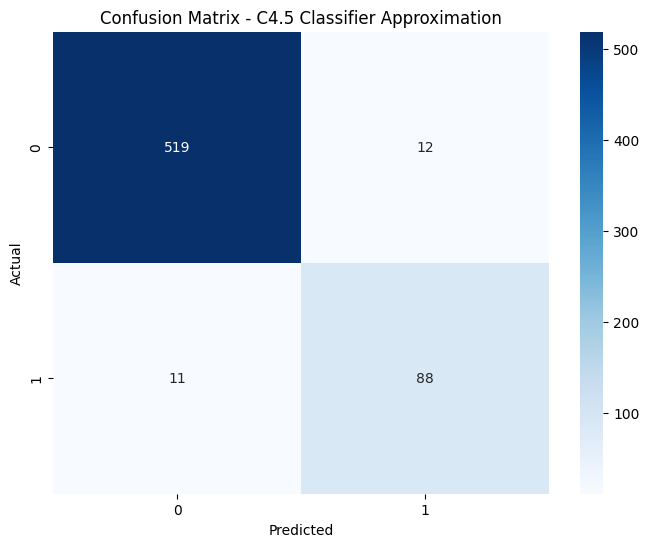

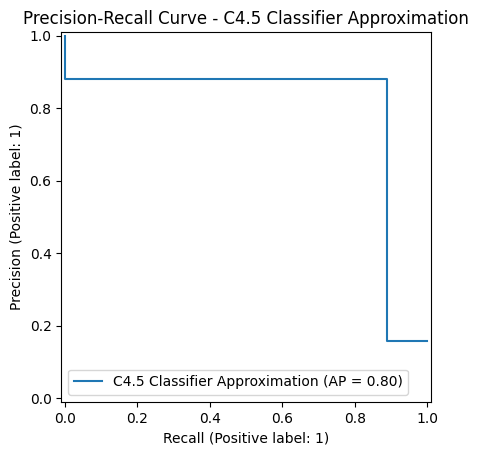

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Extra Tree Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       531
           1       0.90      0.84      0.87        99

    accuracy                           0.96       630
   macro avg       0.94      0.91      0.92       630
weighted avg       0.96      0.96      0.96       630



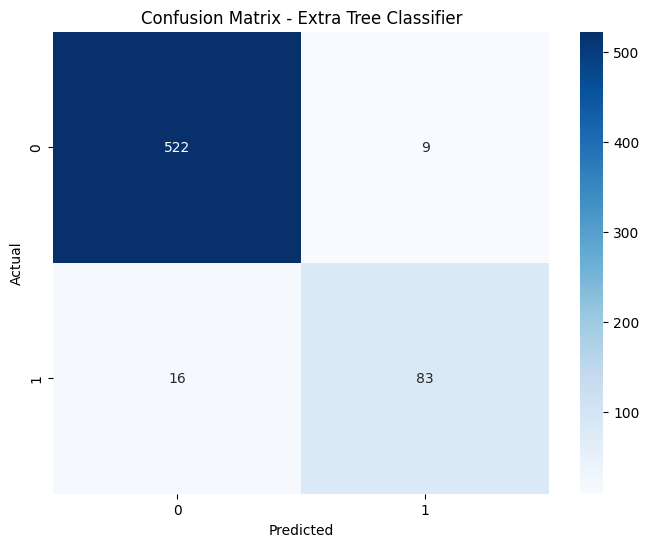

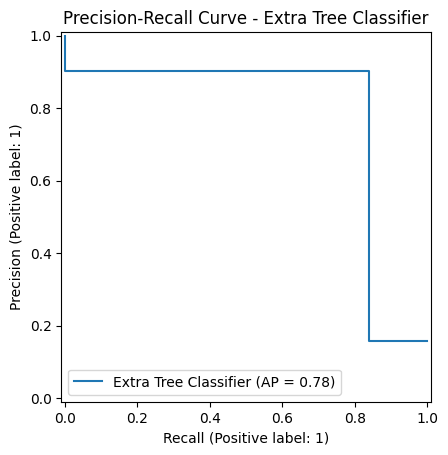

Example Results (Actual vs Predicted) for Extra Tree Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Random Forest Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       531
           1       0.96      0.87      0.91        99

    accuracy                           0.97       630
   macro avg       0.97      0.93      0.95       630
weighted avg       0.97      0.97      0.97       630



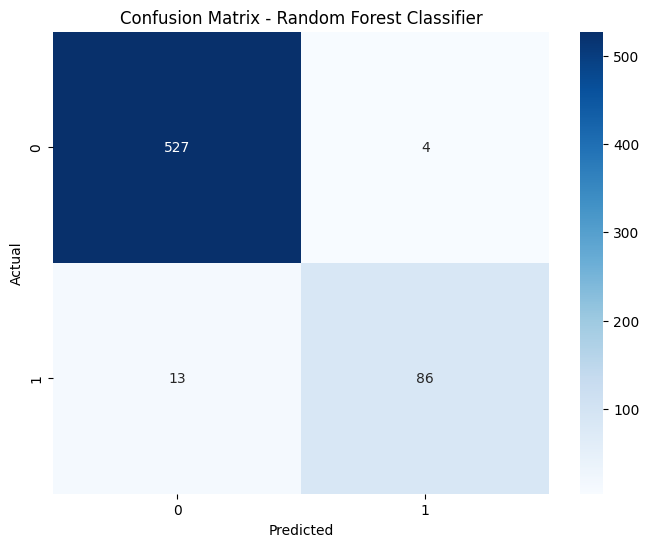

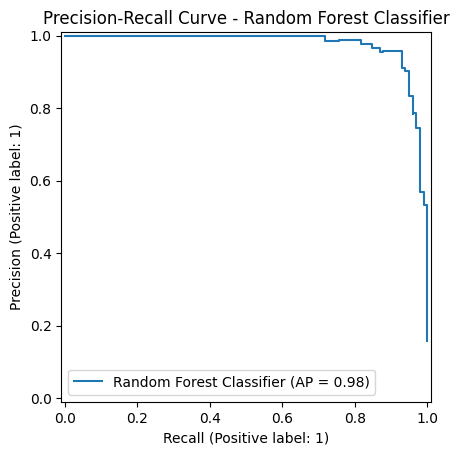

Example Results (Actual vs Predicted) for Random Forest Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for Gradient Boosting Classifier:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       531
           1       0.95      0.79      0.86        99

    accuracy                           0.96       630
   macro avg       0.96      0.89      0.92       630
weighted avg       0.96      0.96      0.96       630



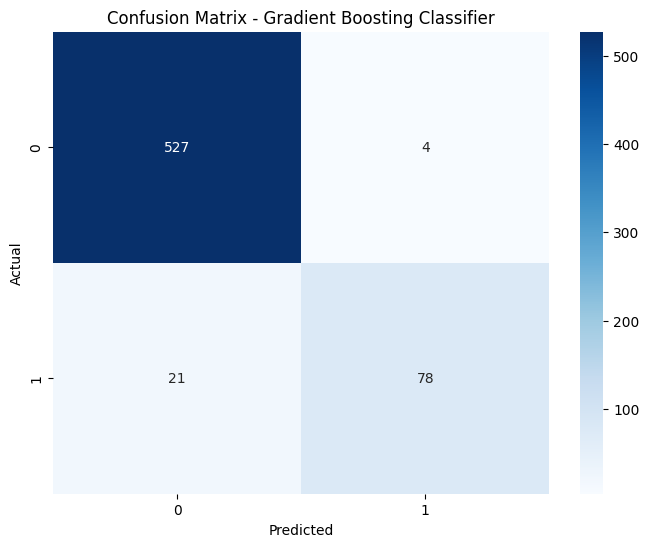

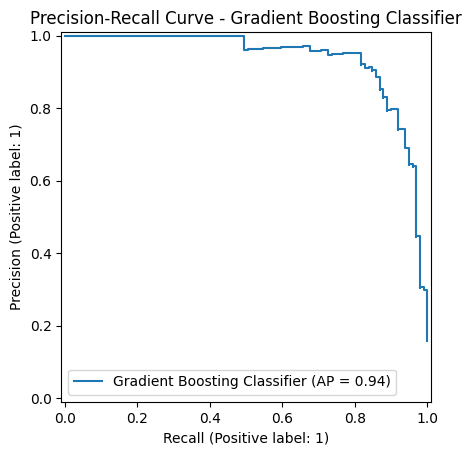

Example Results (Actual vs Predicted) for Gradient Boosting Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost Classifier with Decision Tree:
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       531
           1       0.91      0.85      0.88        99

    accuracy                           0.96       630
   macro avg       0.94      0.92      0.93       630
weighted avg       0.96      0.96      0.96       630



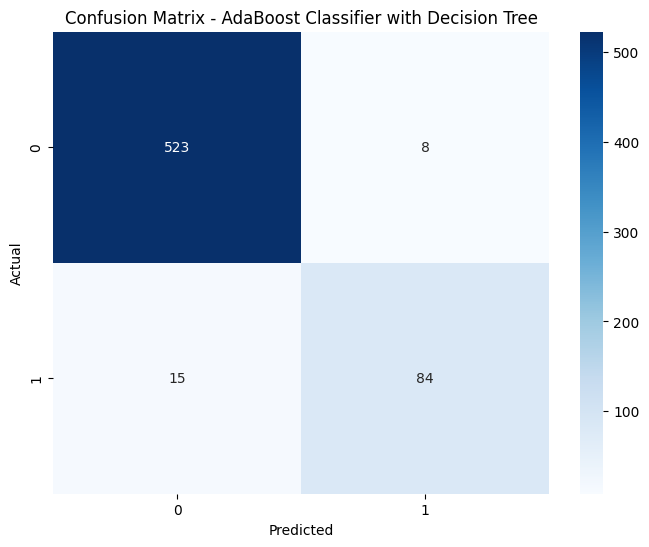

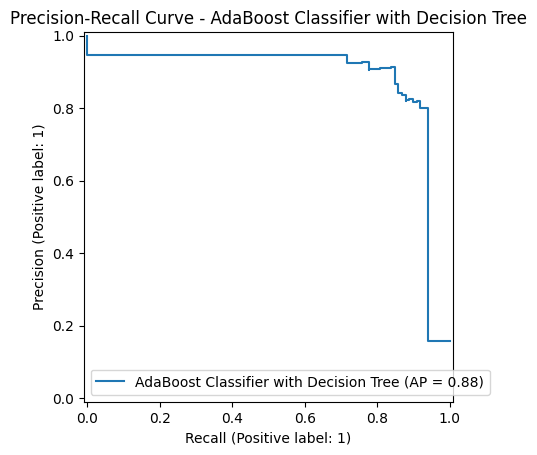

Example Results (Actual vs Predicted) for AdaBoost Classifier with Decision Tree: [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for XGBoost Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.93      0.92      0.92        99

    accuracy                           0.98       630
   macro avg       0.96      0.95      0.95       630
weighted avg       0.98      0.98      0.98       630



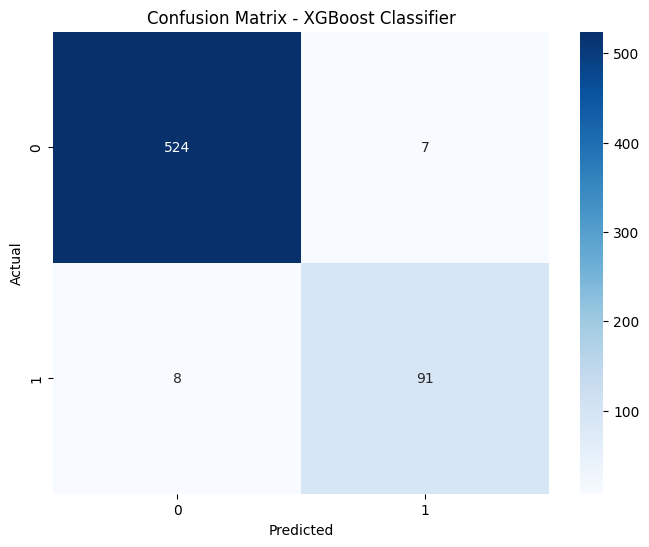

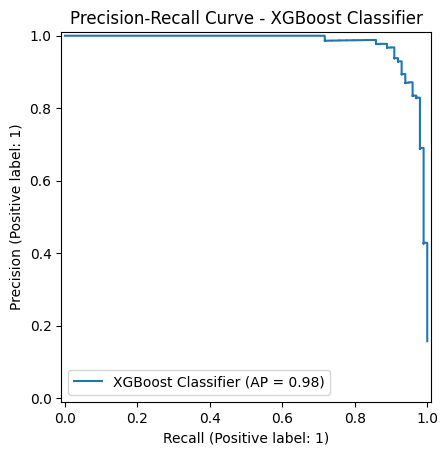

Example Results (Actual vs Predicted) for XGBoost Classifier: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]




In [153]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [154]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the dataset
dataset = pd.read_csv("Customer_Churn.csv")

# Create a copy for clustering
df_cluster = dataset.copy()

# Scale the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Find the best number of clusters
best_k = None
best_score = -1.0

for k in range(2, 10):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    cluster_labels_tmp = kmeans_tmp.fit_predict(df_cluster_scaled)
    sil_score = silhouette_score(df_cluster_scaled, cluster_labels_tmp)
    print(f"  k = {k}, silhouette = {sil_score:.4f}")
    
    if sil_score > best_score:
        best_score = sil_score
        best_k = k

print(f"\nBest k based on silhouette score: {best_k} (score = {best_score:.4f})")

# Fit K-Means with the best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)

# Add cluster labels
df_cluster["cluster"] = cluster_labels

# Compute cluster medians
cluster_medians = df_cluster.groupby("cluster").median()

# Specify columns that must ALL be zero for filtering
cols_must_be_zero = [0, 3, 4, 5, 6, 7, 12]
col_names_must_be_zero = dataset.columns[cols_must_be_zero]

# Create a mask for rows where ALL specified columns are zero
all_zeros_mask = np.all(df_cluster[col_names_must_be_zero] == 0, axis=1)

# Filter out records where column 13 is also zero
column_13_is_zero = df_cluster.iloc[:, 13] == 0
records_to_remove = all_zeros_mask & column_13_is_zero
print(f"\nNumber of records removed: {records_to_remove.sum()}")

# Keep only records not marked for removal
df_cluster = df_cluster[~records_to_remove]

# Proceed with imputation on the remaining data
# (These are now the rows where all specified columns are zero and column 13 is not zero)
all_zeros_mask = np.all(df_cluster[col_names_must_be_zero] == 0, axis=1)

# Perform imputation only on records where ALL specified columns are zero
for cluster_id in range(best_k):
    # Rows that belong to this cluster AND have all zeros
    cluster_mask = (df_cluster["cluster"] == cluster_id) & all_zeros_mask
    
    # Only proceed if there are any rows meeting our criteria in this cluster
    if cluster_mask.any():
        for col_name in col_names_must_be_zero:
            # Median for this column in this cluster
            cluster_col_median = cluster_medians.loc[cluster_id, col_name]
            
            # Replace values for rows that meet our criteria
            df_cluster.loc[cluster_mask, col_name] = cluster_col_median

# Update the original dataset
for col_idx in cols_must_be_zero:
    col_name = dataset.columns[col_idx]
    dataset[col_name] = df_cluster[col_name]

# Print summary of changes
print("\nSummary of imputation:")
print(f"Total records processed: {len(dataset)}")
print(f"Records modified: {all_zeros_mask.sum()}")
print("Modified columns:", list(col_names_must_be_zero))


  k = 2, silhouette = 0.2108
  k = 3, silhouette = 0.2221
  k = 4, silhouette = 0.1920
  k = 5, silhouette = 0.2150
  k = 6, silhouette = 0.2455
  k = 7, silhouette = 0.2514
  k = 8, silhouette = 0.2720
  k = 9, silhouette = 0.2738

Best k based on silhouette score: 9 (score = 0.2738)

Number of records removed: 61

Summary of imputation:
Total records processed: 3150
Records modified: 69
Modified columns: ['Call  Failure', 'Charge  Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20188\692453133.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1966.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[cluster_mask, col_name] = cluster_col_median


In [155]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (84.3%)
Class 1: 396 (15.7%)

Test set proportions:
Class 0: 531 (84.3%)
Class 1: 99 (15.7%)


Results for CART Classifier (Gini):
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.87      0.86      0.86        99

    accuracy                           0.96       630
   macro avg       0.92      0.92      0.92       630
weighted avg       0.96      0.96      0.96       630



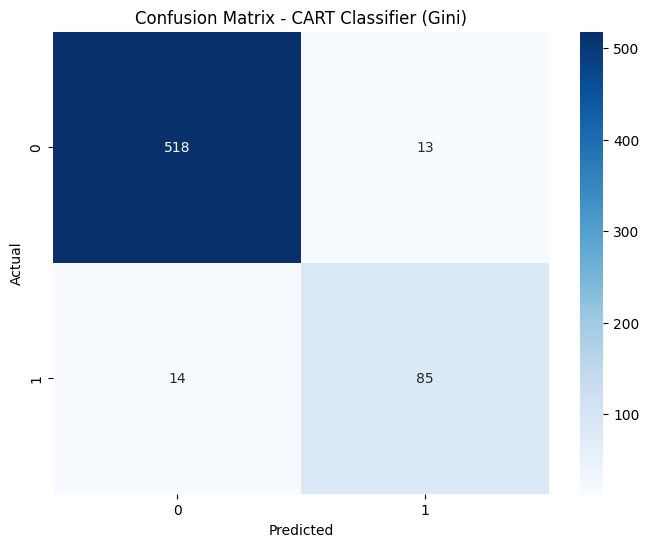

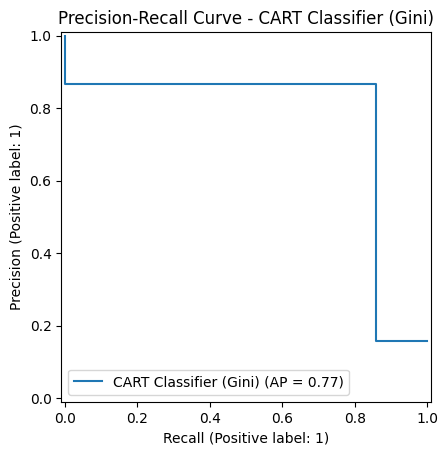

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       531
           1       0.84      0.87      0.86        99

    accuracy                           0.95       630
   macro avg       0.91      0.92      0.91       630
weighted avg       0.95      0.95      0.95       630



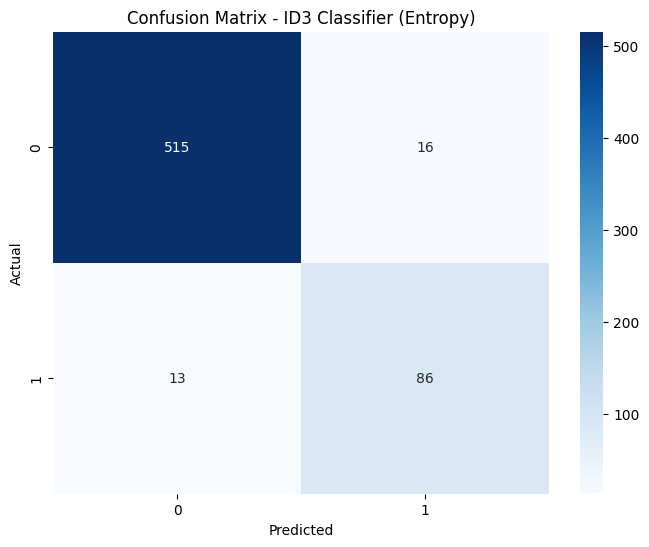

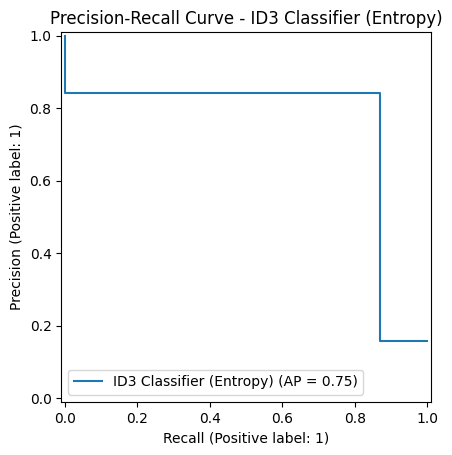

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       531
           1       0.84      0.87      0.86        99

    accuracy                           0.95       630
   macro avg       0.91      0.92      0.91       630
weighted avg       0.95      0.95      0.95       630



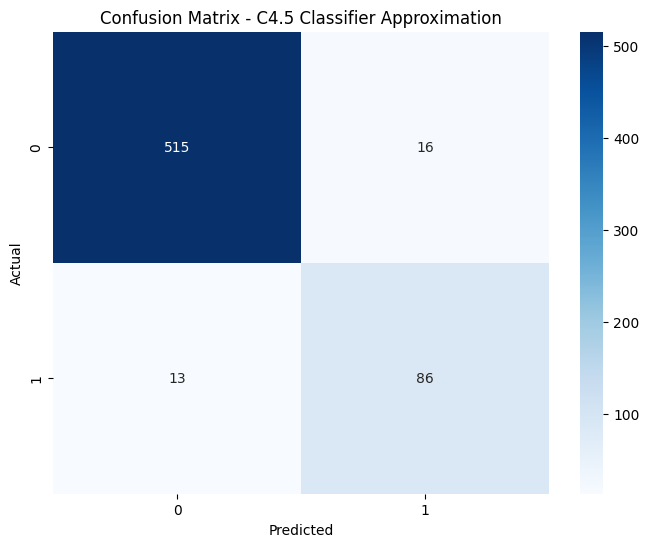

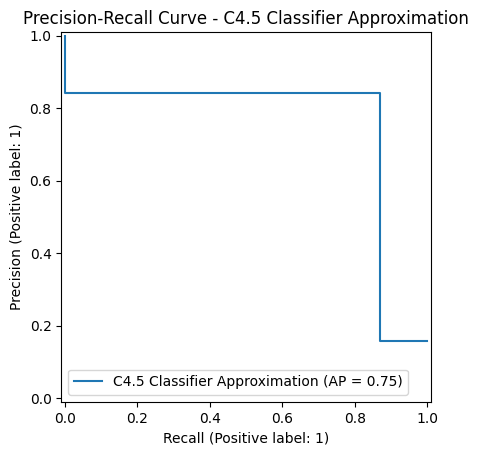

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]




ValueError: Input X contains NaN.
ExtraTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [156]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")


In [157]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the dataset
dataset = pd.read_csv("Customer_Churn.csv")

# Create a copy for clustering
df_cluster = dataset.copy()

# Scale the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Find the best number of clusters
best_k = None
best_score = -1.0

for k in range(2, 10):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    cluster_labels_tmp = kmeans_tmp.fit_predict(df_cluster_scaled)
    sil_score = silhouette_score(df_cluster_scaled, cluster_labels_tmp)
    print(f"  k = {k}, silhouette = {sil_score:.4f}")
    
    if sil_score > best_score:
        best_score = sil_score
        best_k = k

print(f"\nBest k based on silhouette score: {best_k} (score = {best_score:.4f})")

# Fit K-Means with the best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)

# Add cluster labels
df_cluster["cluster"] = cluster_labels

# Compute cluster medians
cluster_medians = df_cluster.groupby("cluster").median()

# Specify columns that must ALL be zero for filtering
cols_must_be_zero = [0, 3, 4, 5, 6, 7, 12]
col_names_must_be_zero = dataset.columns[cols_must_be_zero]

# Create a mask for rows where ALL specified columns are zero
all_zeros_mask = np.all(df_cluster[col_names_must_be_zero] == 0, axis=1)

# Filter out records where column 13 is equal to 1
column_13_is_one = df_cluster.iloc[:, 13] == 1
records_to_remove = all_zeros_mask & column_13_is_one
print(f"\nNumber of records removed: {records_to_remove.sum()}")

# Keep only records not marked for removal
df_cluster = df_cluster[~records_to_remove]

# Proceed with imputation on the remaining data
# (These are now the rows where all specified columns are zero and column 13 is not 1)
all_zeros_mask = np.all(df_cluster[col_names_must_be_zero] == 0, axis=1)

# Perform imputation only on records where ALL specified columns are zero
for cluster_id in range(best_k):
    # Rows that belong to this cluster AND have all zeros
    cluster_mask = (df_cluster["cluster"] == cluster_id) & all_zeros_mask
    
    # Only proceed if there are any rows meeting our criteria in this cluster
    if cluster_mask.any():
        for col_name in col_names_must_be_zero:
            # Median for this column in this cluster
            cluster_col_median = cluster_medians.loc[cluster_id, col_name]
            
            # Replace values for rows that meet our criteria
            df_cluster.loc[cluster_mask, col_name] = cluster_col_median

# Update the original dataset
for col_idx in cols_must_be_zero:
    col_name = dataset.columns[col_idx]
    dataset[col_name] = df_cluster[col_name]

# Save the updated dataset
dataset.to_csv("Customer_Churn_ClusterImputed_AllZeros.csv", index=False)
print("\nImputation completed. Only records with ALL zeros in specified columns were imputed.")
print("Updated dataset saved as 'Customer_Churn_ClusterImputed_AllZeros.csv'")

# Print summary of changes
print("\nSummary of imputation:")
print(f"Total records processed: {len(dataset)}")
print(f"Records modified: {all_zeros_mask.sum()}")
print("Modified columns:", list(col_names_must_be_zero))


  k = 2, silhouette = 0.2108
  k = 3, silhouette = 0.2221
  k = 4, silhouette = 0.1920
  k = 5, silhouette = 0.2150
  k = 6, silhouette = 0.2455
  k = 7, silhouette = 0.2514
  k = 8, silhouette = 0.2720
  k = 9, silhouette = 0.2738

Best k based on silhouette score: 9 (score = 0.2738)

Number of records removed: 69

Imputation completed. Only records with ALL zeros in specified columns were imputed.
Updated dataset saved as 'Customer_Churn_ClusterImputed_AllZeros.csv'

Summary of imputation:
Total records processed: 3150
Records modified: 61
Modified columns: ['Call  Failure', 'Charge  Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']


In [158]:
# Define feature columns (X) and target column (y)
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

# Split the dataset into training and testing sets
def custom_train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to print class proportions
def print_proportions(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for val, count in zip(unique, counts):
        print(f"Class {val}: {count} ({count/total*100:.1f}%)")

print("\nTraining set proportions:")
print_proportions(y_train)
print("\nTest set proportions:")
print_proportions(y_test)


Training set proportions:
Class 0: 2124 (84.3%)
Class 1: 396 (15.7%)

Test set proportions:
Class 0: 531 (84.3%)
Class 1: 99 (15.7%)


Results for CART Classifier (Gini):
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       531
           1       0.95      0.84      0.89        99

    accuracy                           0.97       630
   macro avg       0.96      0.92      0.94       630
weighted avg       0.97      0.97      0.97       630



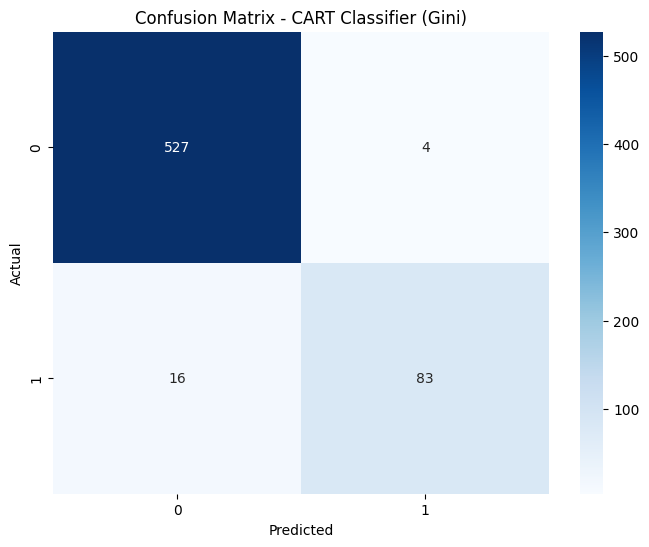

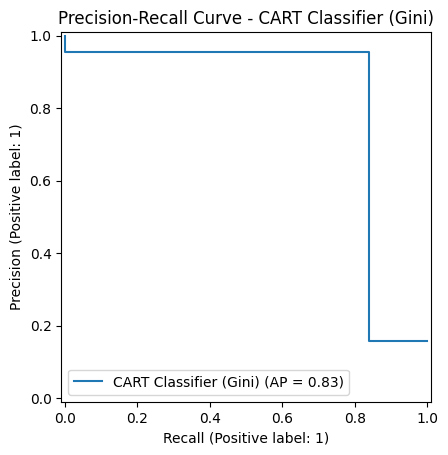

Example Results (Actual vs Predicted) for CART Classifier (Gini): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


Results for ID3 Classifier (Entropy):
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       531
           1       0.86      0.85      0.85        99

    accuracy                           0.95       630
   macro avg       0.91      0.91      0.91       630
weighted avg       0.95      0.95      0.95       630



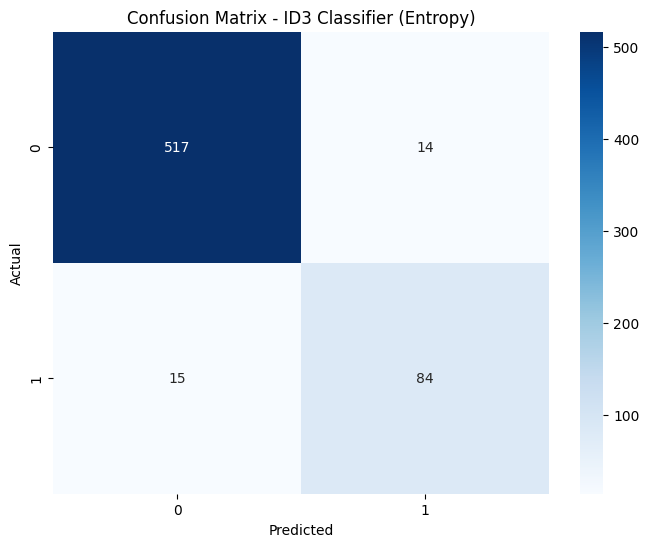

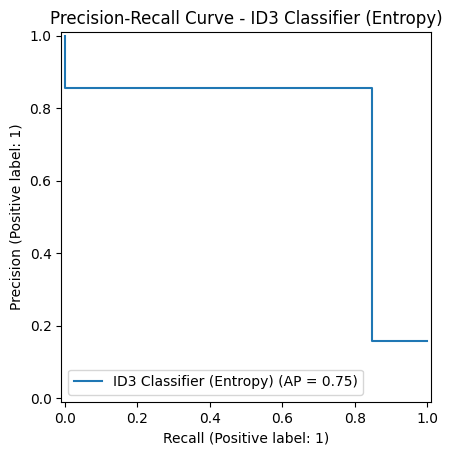

Example Results (Actual vs Predicted) for ID3 Classifier (Entropy): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]


Results for C4.5 Classifier Approximation:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       531
           1       0.86      0.85      0.85        99

    accuracy                           0.95       630
   macro avg       0.91      0.91      0.91       630
weighted avg       0.95      0.95      0.95       630



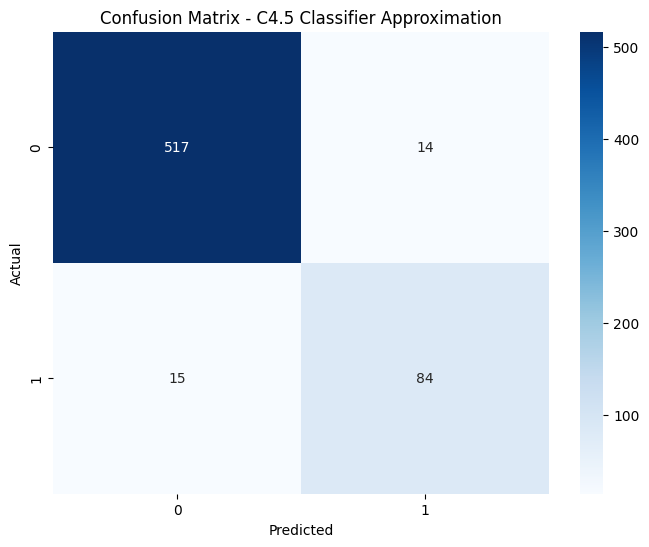

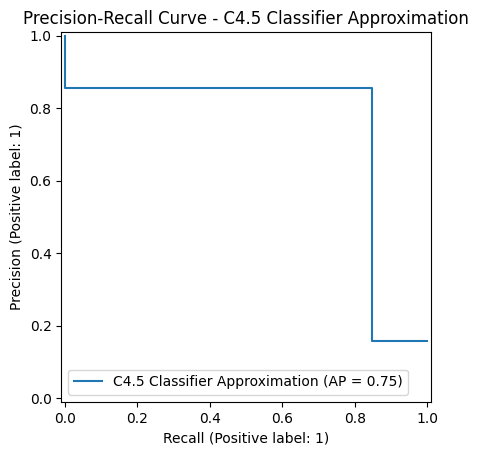

Example Results (Actual vs Predicted) for C4.5 Classifier Approximation: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1)]




ValueError: Input X contains NaN.
ExtraTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [159]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Display Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save Classification Report to Excel
    df_report = pd.DataFrame(class_report).transpose()
    excel_filename = f"Decision Tree Results/NoneOutlier_Classification_Report_{model_name.replace(' ', '_')}.xlsx"
    df_report.to_excel(excel_filename)
    

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Precision-Recall Curve
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name)
        display.ax_.set_title(f"Precision-Recall Curve - {model_name}")
        plt.show()
    except AttributeError:
        print(f"Warning: {model_name} does not support probability predictions.")

    # Example Output
    example = list(zip(y_test[:10], y_pred[:10]))  # Display the first 10 actual vs predicted
    print(f"Example Results (Actual vs Predicted) for {model_name}: {example}")

    print("\n" + "="*50 + "\n")

# 1. CART (Classification and Regression Tree) - Gini impurity
cart_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
train_and_evaluate_model(cart_classifier, "CART Classifier (Gini)")

# 2. ID3 - Approximated using entropy as the criterion
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(id3_classifier, "ID3 Classifier (Entropy)")

# 3. C4.5 - Approximated using entropy, similar to ID3
c4_5_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
train_and_evaluate_model(c4_5_classifier, "C4.5 Classifier Approximation")

# 4. Extra Tree Classifier (another variant of decision trees)
extra_tree_classifier = ExtraTreeClassifier(random_state=42)
train_and_evaluate_model(extra_tree_classifier, "Extra Tree Classifier")

# 5. Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
train_and_evaluate_model(random_forest_classifier, "Random Forest Classifier")

# 6. Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gradient_boosting_classifier, "Gradient Boosting Classifier")

# 7. AdaBoost Classifier (with a Decision Tree as the base estimator)
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
train_and_evaluate_model(adaboost_classifier, "AdaBoost Classifier with Decision Tree")

# 8. XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_classifier, "XGBoost Classifier")
